In [1]:
# todo: housekeeping. get rid of obsolete data and files
# todo: Modelling: SARIMA, Prophet, LSTM, 
# todo: Metrics, MAE, RMSE, 
# todo: plots for train error and test error
# todo: definition of accuracy - MSE, RMSE, MAPE, MAE
# Todo: how accurate is the current forecast by these metrics?
# question: do we have all the temperature index is consistent. Temp is missing values for certain months and we're trying to merge on it
# question: 

In [2]:
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
import os
import matplotlib.pyplot as plt
import functools
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa
import statsmodels.api as sm
import statsmodels.formula.api as smf
from config import CFG
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from utils import csv_to_parquet, normalize_columns, month_to_season, plot_correlation_heatmap

In [3]:
CFG = CFG()

plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

# preprocess data

In [4]:
csv_to_parquet(
    csv_folder=CFG.data_path, 
    parquet_folder=CFG.data_path
)

Parquet file for forecastdemand_nsw.csv exists. Skipping conversion...
Parquet file for temperature_nsw.csv exists. Skipping conversion...
Parquet file for totaldemand_nsw.csv exists. Skipping conversion...
Parquet file for price_cleaned_data.csv exists. Skipping conversion...


# load data

In [5]:
nsw_forecastdemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'forecastdemand_nsw.parquet'),
).groupby('DATETIME').agg({'FORECASTDEMAND': 'mean'})

- we should try to understand what `periodid` represents
- for now we will `groupby` datetime and use `mean()` as the agg function

In [6]:
nsw_totaldemand = pd.read_parquet(
    os.path.join(CFG.data_path, 'totaldemand_nsw.parquet'),
)

In [7]:
nsw_temperature = pd.read_parquet(
    os.path.join(CFG.data_path, 'temperature_nsw.parquet'),
).resample('30min').mean()
nsw_temperature['TEMPERATURE'] = nsw_temperature['TEMPERATURE'].interpolate(method='time')

In [8]:
price_df = pd.read_parquet(
    os.path.join(CFG.data_path, 'price_cleaned_data.parquet'), 
)
price_df['rrp'] = price_df['rrp'].interpolate(method='time')

# merge

In [9]:
dfs = [
    nsw_totaldemand, 
    nsw_forecastdemand, 
    nsw_temperature, 
    price_df
]

nsw_df = functools.reduce(
    lambda left, right: 
    pd.merge(
        left, 
        right, 
        left_index=True, 
        right_index=True, 
        how='inner'
    ), dfs
)

# EDA

In [10]:
nsw_df.describe()

TOTALDEMAND  FORECASTDEMAND    TEMPERATURE            rrp
count  196512.000000   196512.000000  196512.000000  196512.000000
mean     8113.146242     8107.153035      17.528241      56.878814
std      1299.536070     1303.190137       5.877381     158.199128
min      5074.630000     4878.596667      -1.300000    -264.310000
25%      7150.067500     7129.623620      13.500000      31.430000
50%      8053.230000     8061.563409      17.900000      47.720000
75%      8958.550000     8965.041462      21.500000      63.930000
max     14579.860000    14601.171964      44.700000   14700.000000

In [11]:
nsw_df.corr()

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE       rrp
TOTALDEMAND        1.000000        0.987169     0.148978  0.122342
FORECASTDEMAND     0.987169        1.000000     0.144837  0.114135
TEMPERATURE        0.148978        0.144837     1.000000  0.056842
rrp                0.122342        0.114135     0.056842  1.000000

<Axes: >

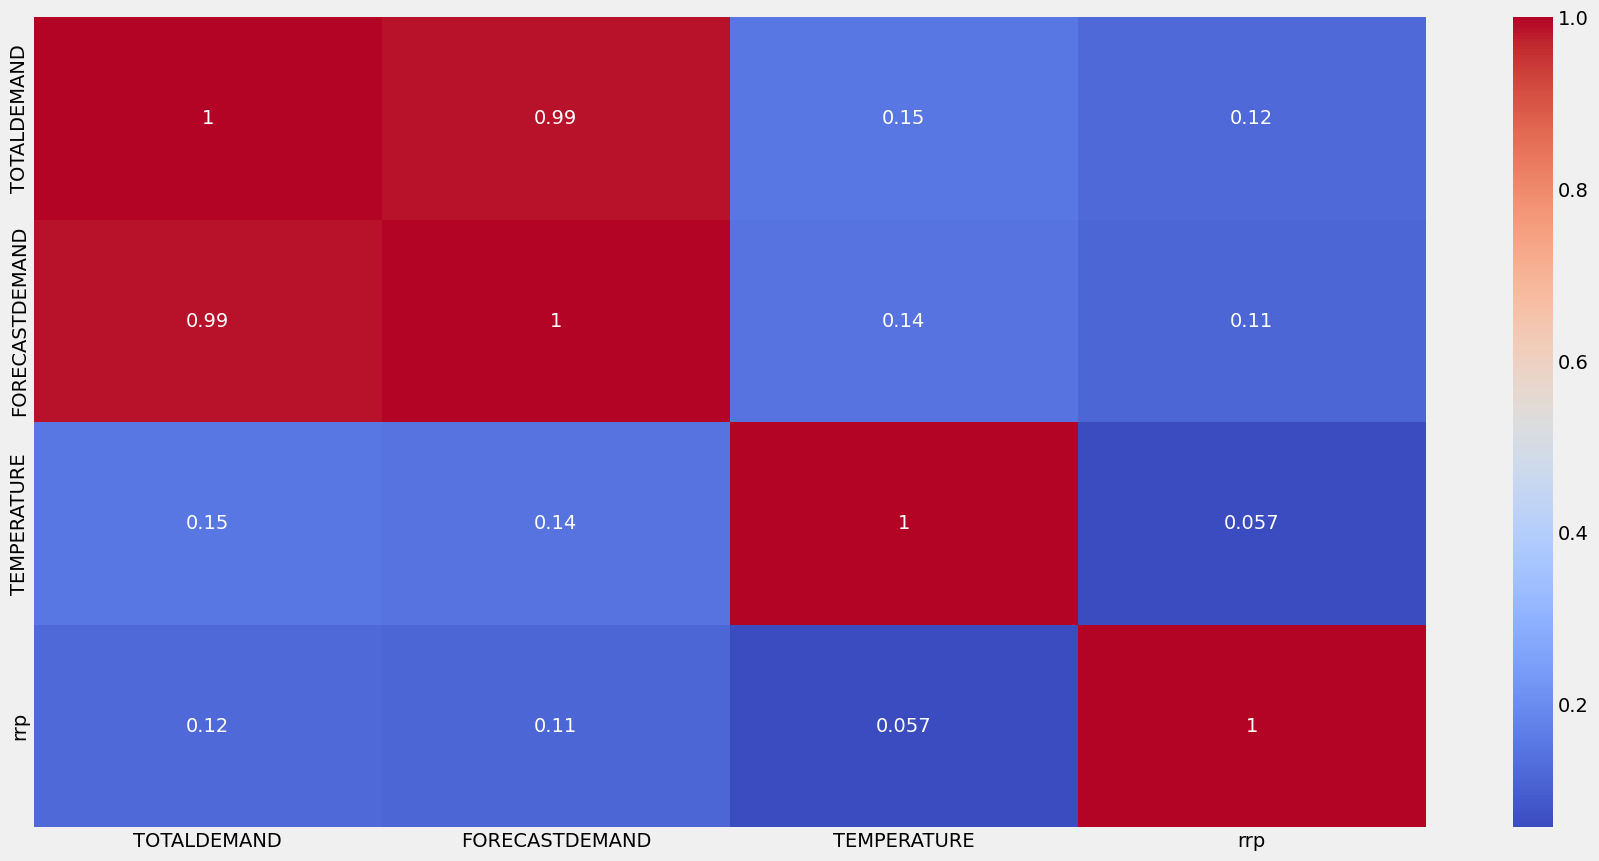

In [12]:
sns.heatmap(nsw_df.corr(), annot=True, cmap='coolwarm')

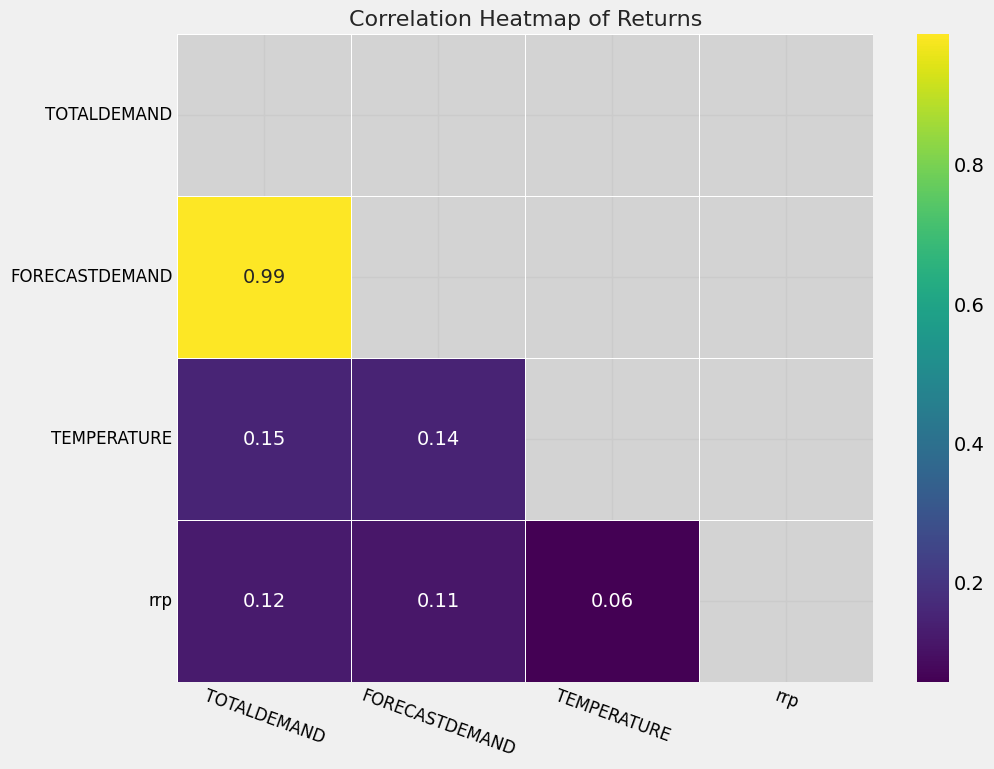

In [13]:
plot_correlation_heatmap(nsw_df)

# Forecast and actual demand over time

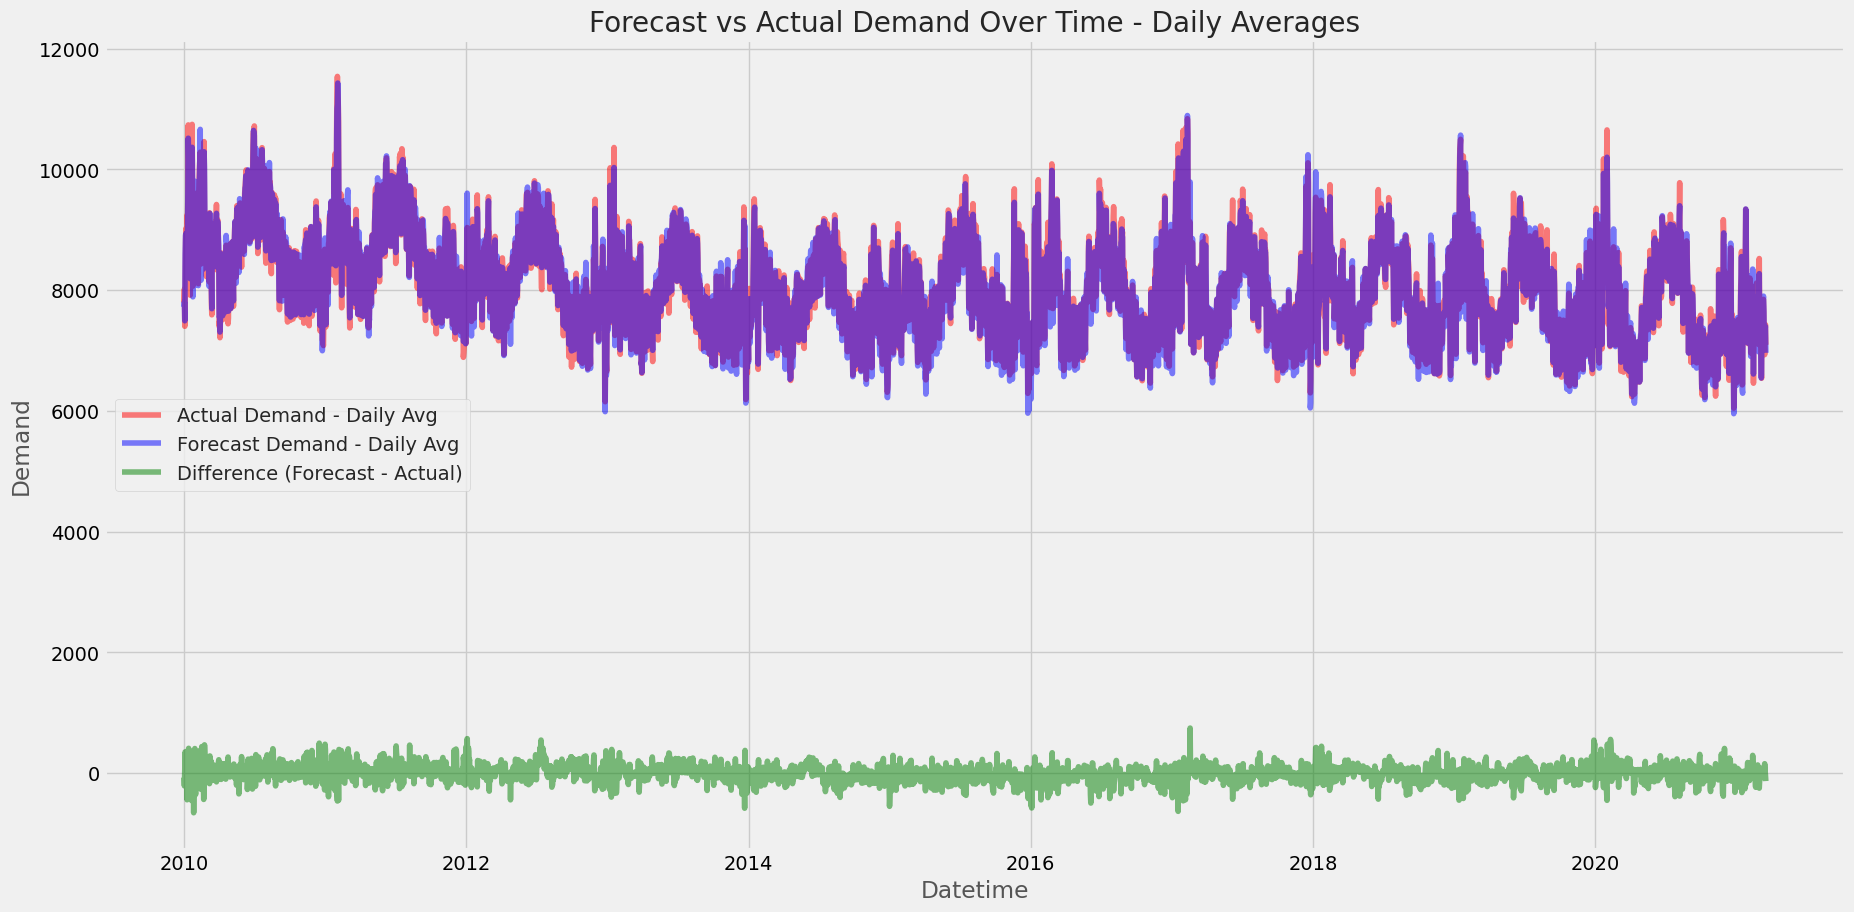

In [14]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

daily_avg_actual = nsw_df['TOTALDEMAND'].resample('D').mean()
daily_avg_forecast = nsw_df['FORECASTDEMAND'].resample('D').mean()

plt.plot(
    daily_avg_actual.index, 
    daily_avg_actual, 
    label='Actual Demand - Daily Avg', 
    color='red', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast, 
    label='Forecast Demand - Daily Avg', 
    color='blue', 
    alpha=0.5
)

plt.plot(
    daily_avg_forecast.index, 
    daily_avg_forecast - daily_avg_actual, 
    label='Difference (Forecast - Actual)', 
    color='green', 
    alpha=0.5
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast vs Actual Demand Over Time - Daily Averages')
plt.legend()
plt.show()

In [15]:
daily_avg_actual_reindexed = daily_avg_actual.reindex(nsw_df.index)
daily_avg_actua = daily_avg_actual_reindexed
nsw_df['daily_avg_actual'] = daily_avg_actual
# nsw_df['daily_avg_actual']

## backfill daily average reindexed

In [16]:
daily_avg_forecast_reindexed = daily_avg_forecast.reindex(nsw_df.index)
daily_avg_forecast = daily_avg_forecast_reindexed
nsw_df['daily_avg_forecast'] = daily_avg_forecast

# calculate average error

In [17]:
daily_avg_error = daily_avg_forecast - daily_avg_actual
daily_avg_error_reindexed = daily_avg_error.reindex(nsw_df.index)
daily_avg_error_filled = daily_avg_error_reindexed.bfill()
nsw_df['forecast_error'] = daily_avg_error_filled

In [18]:
nsw_df

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-01 00:30:00      7809.31     7680.510417        22.80  21.50   
2010-01-01 01:00:00      7483.69     7428.971370        22.60  20.98   
2010-01-01 01:30:00      7117.23     7084.802162        22.50  20.06   
2010-01-01 02:00:00      6812.03     6751.369600        22.50  17.93   
2010-01-01 02:30:00      6544.33     6484.270789        22.40  17.43   
...                          ...             ...          ...    ...   
2021-03-17 22:00:00      7419.77     7317.702687        19.70  32.00   
2021-03-17 22:30:00      7417.91     7266.887647        19.50  37.01   
2021-03-17 23:00:00      7287.32     7173.866522        19.05  34.49   
2021-03-17 23:30:00      7172.39     7043.236857        18.80  32.55   
2021-03-18 00:00:00      7094.51     6961.076901        18.60  32.63   

                     daily_avg_actual  daily_avg_forecast  forecast_error  
2010-01-01 00:30:00               NaN                 NaN     -212.791200  
2010-01-01 01:00:00               NaN                 NaN     -212.791200  
2010-01-01 01:30:00               NaN                 NaN     -212.791200  
2010-01-01 02:00:00               NaN                 NaN     -212.791200  
2010-01-01 02:30:00               NaN                 NaN     -212.791200  
...                               ...                 ...             ...  
2021-03-17 22:00:00               NaN                 NaN     -133.433099  
2021-03-17 22:30:00               NaN                 NaN     -133.433099  
2021-03-17 23:00:00               NaN                 NaN     -133.433099  
2021-03-17 23:30:00               NaN                 NaN     -133.433099  
2021-03-18 00:00:00           7094.51         6961.076901     -133.433099  

[196512 rows x 7 columns]

# Forecast Demand over time
I've made some changes to try to improve this plot:
- **Smoothing**: The plot is quite noisy, so applying a rolling mean (moving average) can help to smooth out short-term fluctuations and highlight longer-term trends.
- **Highlighting Peaks and Troughs**: You could programmatically identify and annotate significant peaks and troughs to draw attention to them.
- **Resampling**: If the data is too dense, consider resampling it to a larger time frame, such as daily or weekly averages.

In [19]:
rolling_window = 48
nsw_df['smoothed_forecast_demand'] = nsw_df['FORECASTDEMAND'].rolling(window=rolling_window).mean()
index_range = nsw_df.index[:rolling_window]
nsw_df.loc[index_range, 'smoothed_forecast_demand'] = nsw_df['smoothed_forecast_demand'][rolling_window:].bfill().head(rolling_window)

In [20]:
# calculate the index of the 50th entry
fifty_index = nsw_df.head(50).index[-1]

In [21]:
# perform backfill on the first 50 entries
nsw_df.loc[:fifty_index, 'smoothed_forecast_demand'] = nsw_df.loc[:fifty_index, 'smoothed_forecast_demand'].bfill()

In [22]:
nsw_df_daily = nsw_df['FORECASTDEMAND'].resample('D').mean()
# nsw_df_daily  # daily average forecast demand

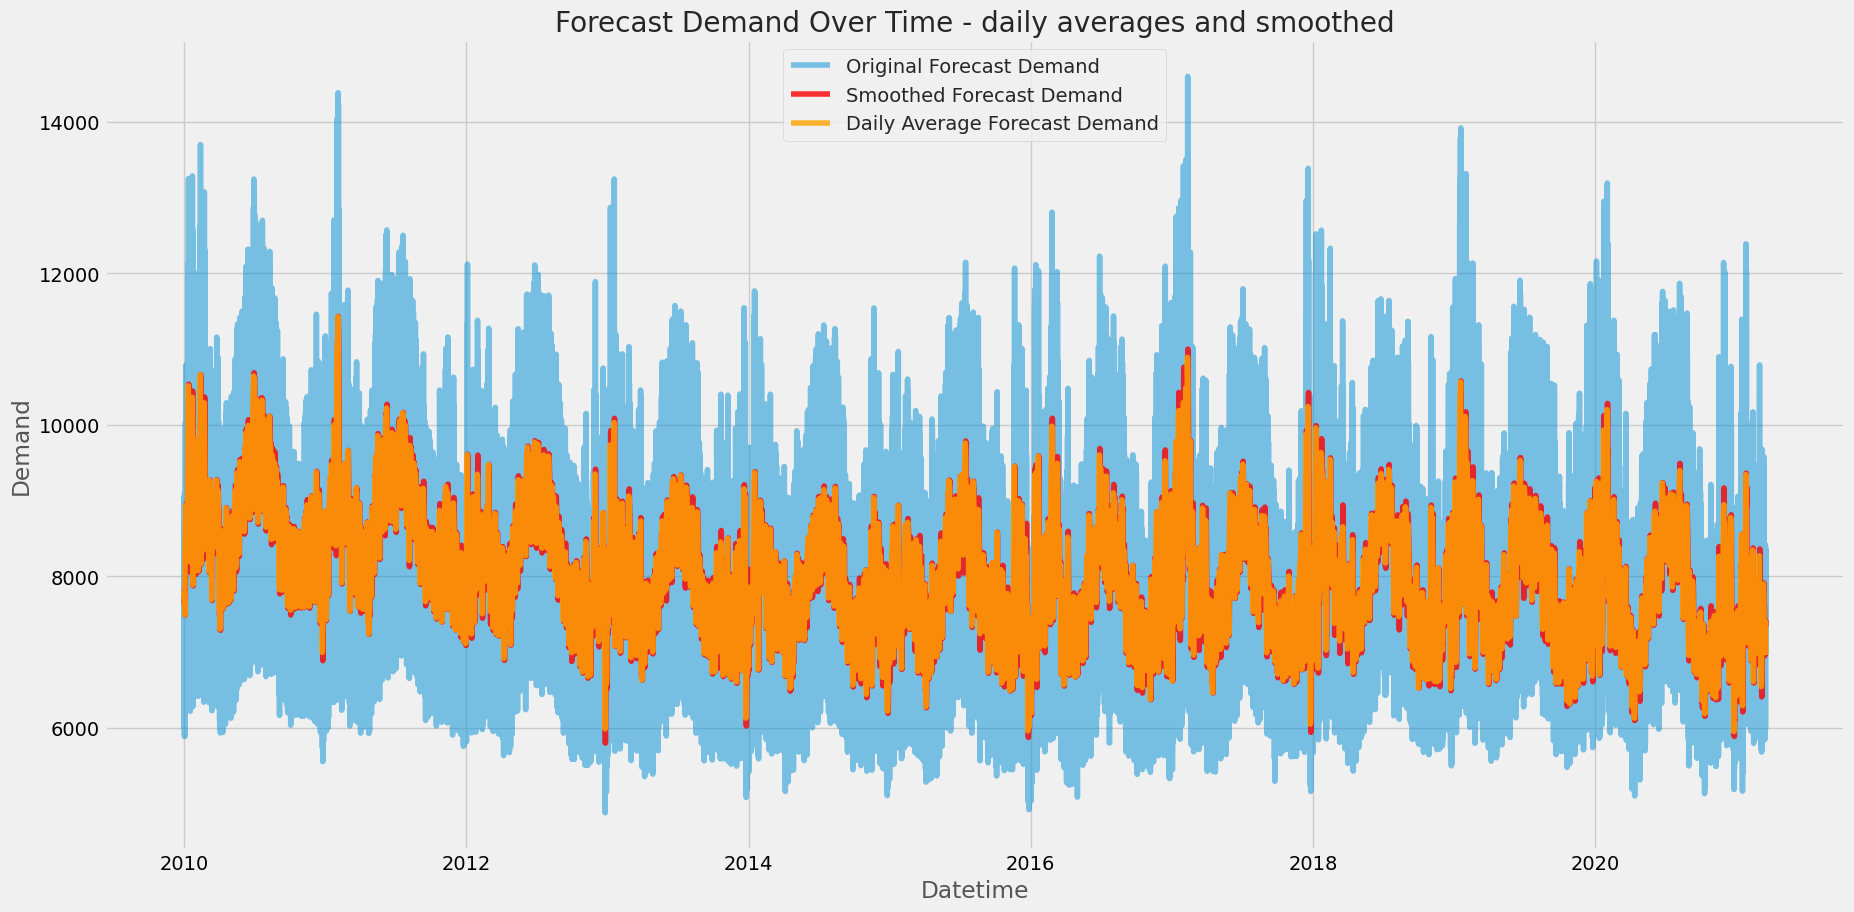

In [23]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Original Forecast Demand', 
    alpha=0.5
)

# 
plt.plot(
    nsw_df['smoothed_forecast_demand'], 
    label='Smoothed Forecast Demand', 
    color='red', 
    alpha=0.8
)

# 
plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Forecast Demand', 
    color='orange', 
    alpha=0.8
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast Demand Over Time - daily averages and smoothed')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
nsw_df

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-01 00:30:00      7809.31     7680.510417        22.80  21.50   
2010-01-01 01:00:00      7483.69     7428.971370        22.60  20.98   
2010-01-01 01:30:00      7117.23     7084.802162        22.50  20.06   
2010-01-01 02:00:00      6812.03     6751.369600        22.50  17.93   
2010-01-01 02:30:00      6544.33     6484.270789        22.40  17.43   
...                          ...             ...          ...    ...   
2021-03-17 22:00:00      7419.77     7317.702687        19.70  32.00   
2021-03-17 22:30:00      7417.91     7266.887647        19.50  37.01   
2021-03-17 23:00:00      7287.32     7173.866522        19.05  34.49   
2021-03-17 23:30:00      7172.39     7043.236857        18.80  32.55   
2021-03-18 00:00:00      7094.51     6961.076901        18.60  32.63   

                     daily_avg_actual  daily_avg_forecast  forecast_error  \
2010-01-01 00:30:00               NaN                 NaN     -212.791200   
2010-01-01 01:00:00               NaN                 NaN     -212.791200   
2010-01-01 01:30:00               NaN                 NaN     -212.791200   
2010-01-01 02:00:00               NaN                 NaN     -212.791200   
2010-01-01 02:30:00               NaN                 NaN     -212.791200   
...                               ...                 ...             ...   
2021-03-17 22:00:00               NaN                 NaN     -133.433099   
2021-03-17 22:30:00               NaN                 NaN     -133.433099   
2021-03-17 23:00:00               NaN                 NaN     -133.433099   
2021-03-17 23:30:00               NaN                 NaN     -133.433099   
2021-03-18 00:00:00           7094.51         6961.076901     -133.433099   

                     smoothed_forecast_demand  
2010-01-01 00:30:00               7699.974365  
2010-01-01 01:00:00               7699.974365  
2010-01-01 01:30:00               7699.974365  
2010-01-01 02:00:00               7699.974365  
2010-01-01 02:30:00               7699.974365  
...                                       ...  
2021-03-17 22:00:00               7400.366626  
2021-03-17 22:30:00               7399.723912  
2021-03-17 23:00:00               7399.132502  
2021-03-17 23:30:00               7398.573481  
2021-03-18 00:00:00               7398.131553  

[196512 rows x 8 columns]

In [25]:
# Add new time-related columns directly to nsw_df
nsw_df['year'] = nsw_df.index.year
nsw_df['quarter'] = nsw_df.index.quarter
nsw_df['month'] = nsw_df.index.month
nsw_df['dow'] = nsw_df.index.dayofweek
nsw_df['doy'] = nsw_df.index.dayofyear
nsw_df['hour'] = nsw_df.index.hour
# todo: week of the year, holidays & other special days

In [26]:
# Apply the function to create the 'season' column
nsw_df['season'] = nsw_df['month'].apply(month_to_season)

In [27]:
nsw_df

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-01 00:30:00      7809.31     7680.510417        22.80  21.50   
2010-01-01 01:00:00      7483.69     7428.971370        22.60  20.98   
2010-01-01 01:30:00      7117.23     7084.802162        22.50  20.06   
2010-01-01 02:00:00      6812.03     6751.369600        22.50  17.93   
2010-01-01 02:30:00      6544.33     6484.270789        22.40  17.43   
...                          ...             ...          ...    ...   
2021-03-17 22:00:00      7419.77     7317.702687        19.70  32.00   
2021-03-17 22:30:00      7417.91     7266.887647        19.50  37.01   
2021-03-17 23:00:00      7287.32     7173.866522        19.05  34.49   
2021-03-17 23:30:00      7172.39     7043.236857        18.80  32.55   
2021-03-18 00:00:00      7094.51     6961.076901        18.60  32.63   

                     daily_avg_actual  daily_avg_forecast  forecast_error  \
2010-01-01 00:30:00               NaN                 NaN     -212.791200   
2010-01-01 01:00:00               NaN                 NaN     -212.791200   
2010-01-01 01:30:00               NaN                 NaN     -212.791200   
2010-01-01 02:00:00               NaN                 NaN     -212.791200   
2010-01-01 02:30:00               NaN                 NaN     -212.791200   
...                               ...                 ...             ...   
2021-03-17 22:00:00               NaN                 NaN     -133.433099   
2021-03-17 22:30:00               NaN                 NaN     -133.433099   
2021-03-17 23:00:00               NaN                 NaN     -133.433099   
2021-03-17 23:30:00               NaN                 NaN     -133.433099   
2021-03-18 00:00:00           7094.51         6961.076901     -133.433099   

                     smoothed_forecast_demand  year  quarter  month  dow  doy  \
2010-01-01 00:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:30:00               7699.974365  2010        1      1    4    1   
...                                       ...   ...      ...    ...  ...  ...   
2021-03-17 22:00:00               7400.366626  2021        1      3    2   76   
2021-03-17 22:30:00               7399.723912  2021        1      3    2   76   
2021-03-17 23:00:00               7399.132502  2021        1      3    2   76   
2021-03-17 23:30:00               7398.573481  2021        1      3    2   76   
2021-03-18 00:00:00               7398.131553  2021        1      3    3   77   

                     hour  season  
2010-01-01 00:30:00     0       1  
2010-01-01 01:00:00     1       1  
2010-01-01 01:30:00     1       1  
2010-01-01 02:00:00     2       1  
2010-01-01 02:30:00     2       1  
...                   ...     ...  
2021-03-17 22:00:00    22       2  
2021-03-17 22:30:00    22       2  
2021-03-17 23:00:00    23       2  
2021-03-17 23:30:00    23       2  
2021-03-18 00:00:00     0       2  

[196512 rows x 15 columns]

## Observations
The plot layers three time series: 
- the original forecast demand, 
- the smoothed forecast demand, 
- and the daily average forecast demand. 

Here are some potential conclusions and observations I draw from this plot:

1. **Volatility**: The original forecast demand shows significant volatility, as indicated by the frequent and sometimes sharp peaks and valleys.

2. **Smoothing Effect**: The smoothed forecast demand (the line in red) has reduced the short-term fluctuations, making the underlying trends more visible. It appears to follow the central tendency of the original forecast, reducing the impact of extreme values.

3. **Daily Patterns**: The daily average forecast demand (the line in yellow) simplifies the data to show the trend within each day, abstracting away the half-hourly variations. This line highlights the overall daily movement in demand without the noise of intra-day fluctuations.

4. **Long-term Trends**: Despite the daily and smoothed variations, there seems to be a consistent pattern that repeats over a longer cycle, perhaps weekly or seasonally, which would be worth investigating further.

5. **Comparative Analysis**: By overlaying the smoothed and daily averaged data over the original forecast demand, it's possible to compare short-term variations to longer-term patterns. This can be crucial for understanding both normal daily operations and the impact of specific events or anomalies.

6. **Anomaly Identification**: The points where the original demand significantly diverges from its smoothed or daily average counterpart may indicate anomalies or special events that caused unusual demand (such as holidays, heatwaves, etc.).

For further analysis, I should investigate the causes of the peaks and troughs in more detail, especially the outliers. For example, examining corresponding temperature data, special events, or other external factors could provide insights into why demand might spike or dip at various points in time.

# Total Demand over time

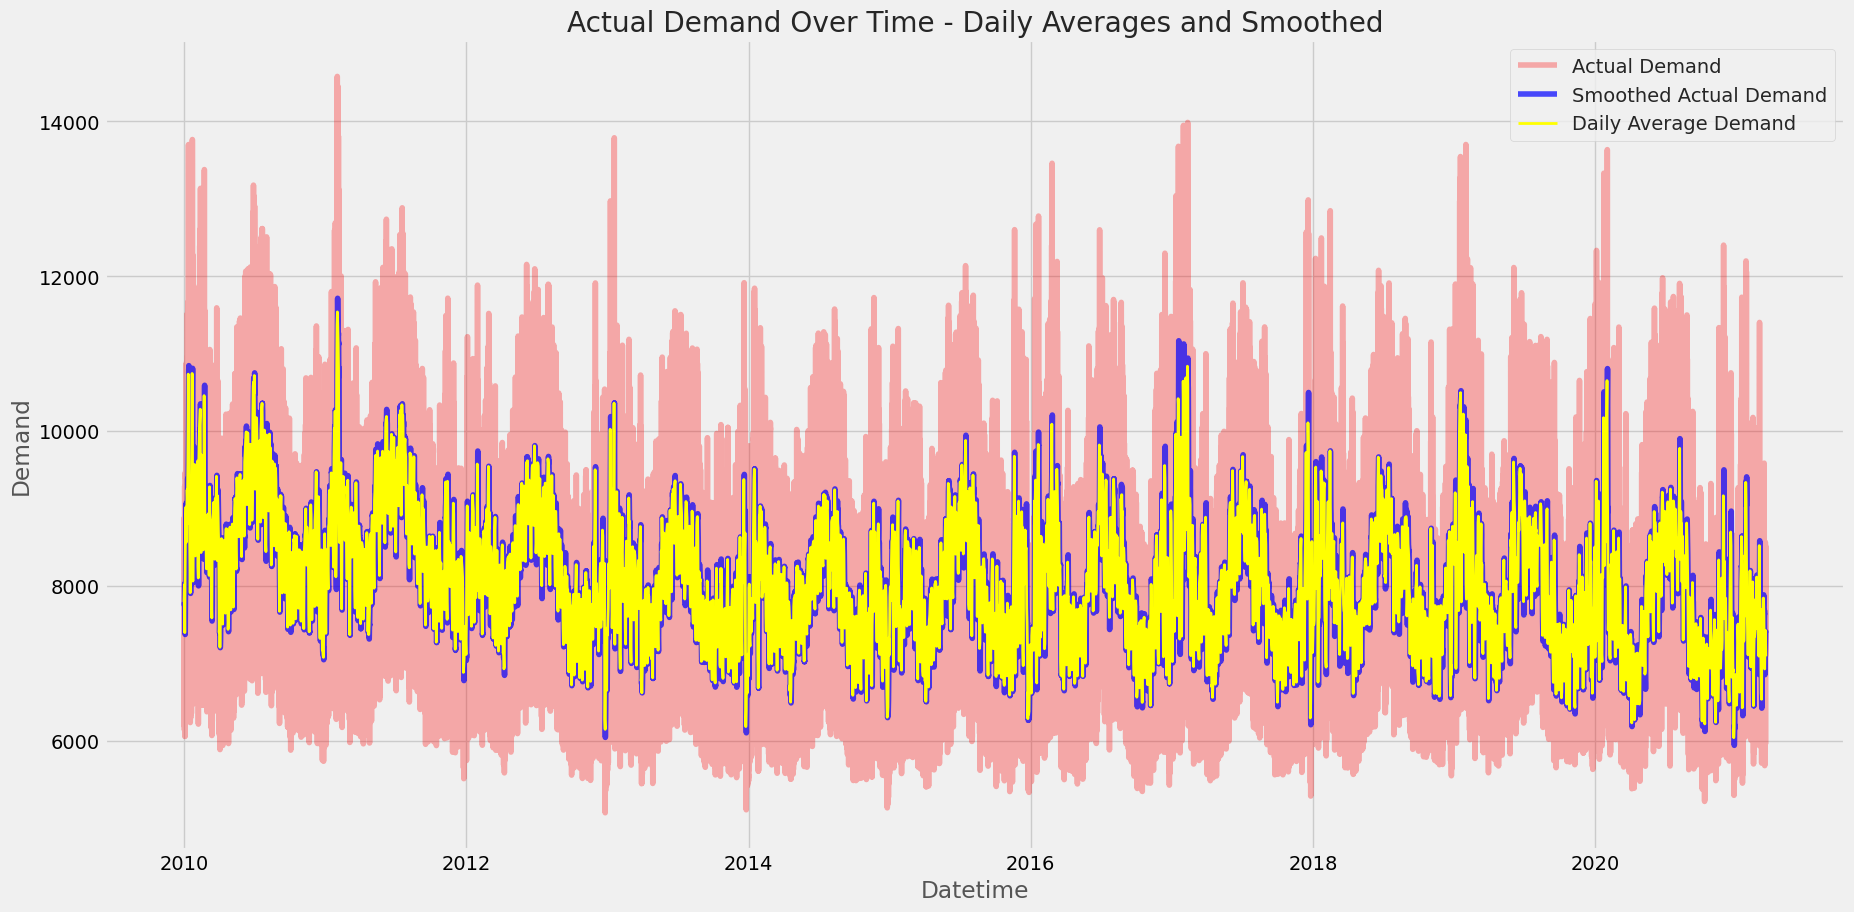

In [28]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

nsw_df_daily = nsw_df['TOTALDEMAND'].resample('D').mean()
rolling_window = 48
nsw_df['smoothed_total_demand'] = nsw_df['TOTALDEMAND'].rolling(window=rolling_window).mean()

plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.3
)

plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_total_demand'], 
    label='Smoothed Actual Demand', 
    color='blue', 
    alpha=0.7
)

plt.plot(
    nsw_df_daily.index, 
    nsw_df_daily, 
    label='Daily Average Demand', 
    color='yellow', 
    alpha=1.0, 
    linewidth=2
)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual Demand Over Time - Daily Averages and Smoothed')

plt.grid(True)
plt.legend()
plt.show()

## Observations
This plot, which shows actual demand over time along with its daily average and smoothed version, include:

1. **Cyclical Patterns**: There are visible patterns that repeat over time, which may correspond to weekly, monthly, or seasonal cycles in electricity demand.

2. **Daily Variations**: The daily average demand (in yellow) shows how demand fluctuates on a day-to-day basis. This line smooths out the intraday variations and reveals the general movement of demand throughout the dataset's timeline.

3. **Trend Indication**: The smoothed actual demand (in blue) helps to identify the underlying trend by minimizing the impact of short-term fluctuations. This can provide insights into longer-term movements in demand, such as gradual increases or decreases over the years.

4. **Peak Demand Periods**: There are significant spikes in actual demand (in red) that stand out above the smoothed and daily average trends. These peaks could indicate days of particularly high demand, which could be due to extreme weather, special events, or other factors.

5. **Volatility**: The red peaks suggest periods of high volatility in actual demand. Understanding the factors contributing to this volatility could be crucial for grid management and planning.

6. **Data Density**: The plot is dense and hard to interpret in detail, particularly over such a long timeframe. A more granular view (e.g., looking at shorter periods) is likely provide more actionable insights. This should be the next task for me

7. **Anomalies and Outliers**: The actual demand has several outliers which are significantly different from the smoothed trend and daily average. These could represent data anomalies that may need to be investigated further.

To better understand the demand patterns and to make informed decisions, I should segment the data into different periods (such as by year, season, week and day), and analyse it in conjunction with other relevant data (like temperature or economic activity).

# Temperature over time

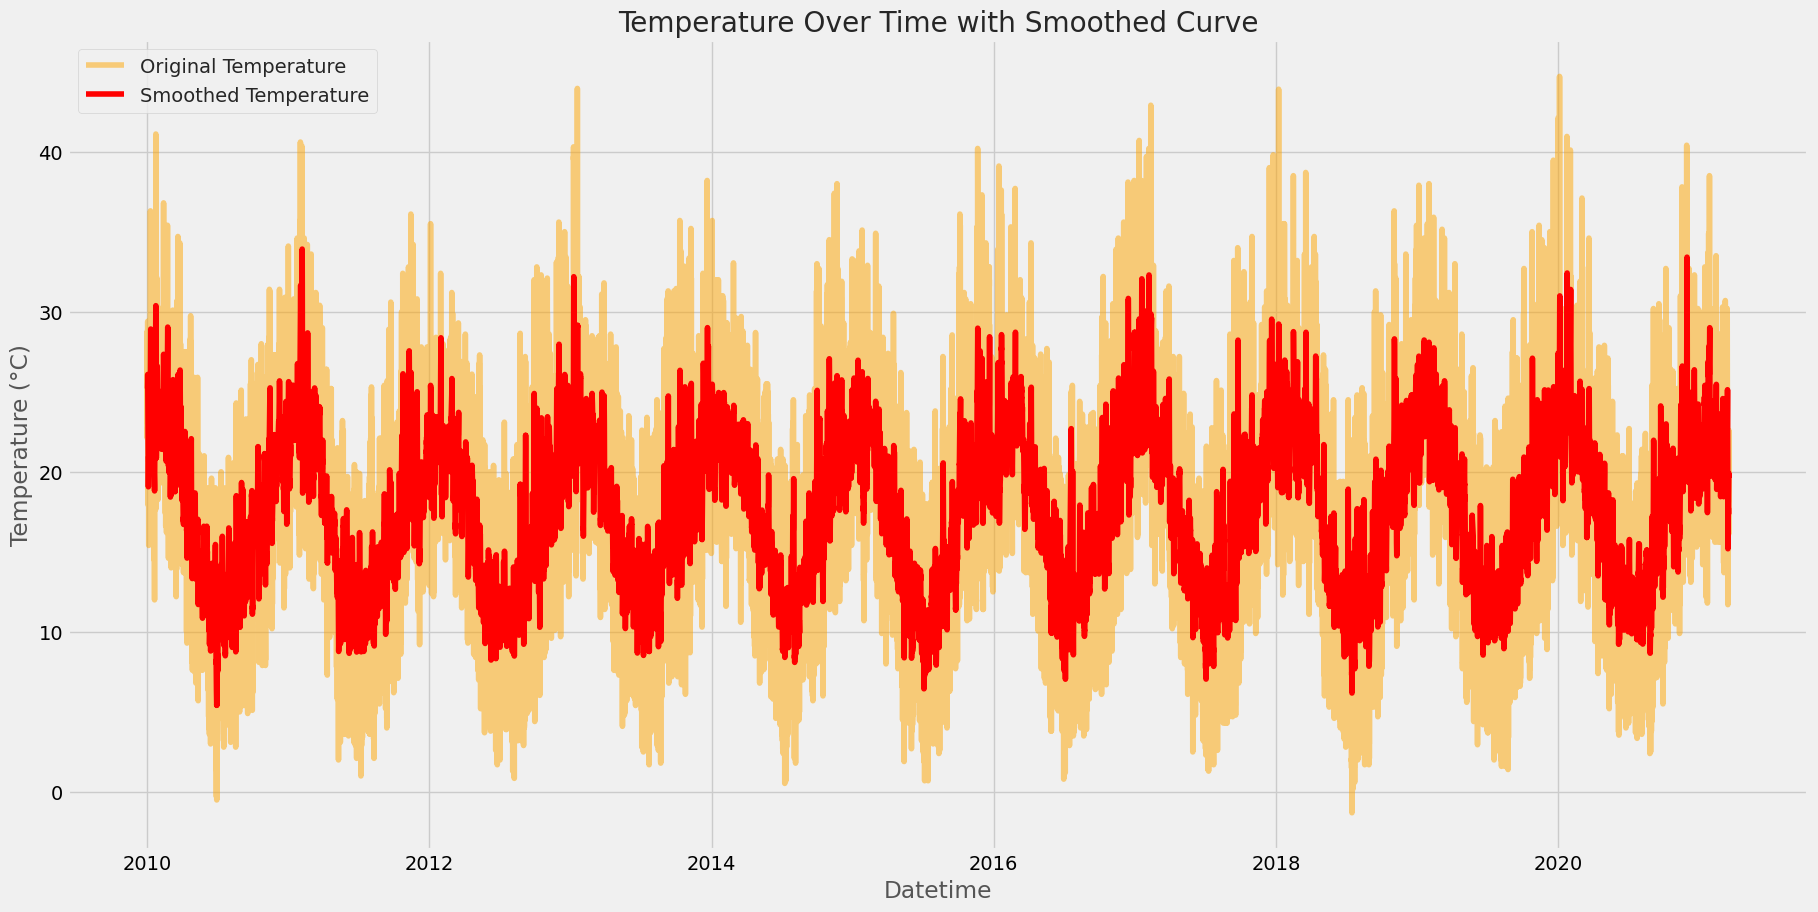

In [29]:
rolling_window = 48  # this should be changed. 48 represents 24 hours
# todo: kalman filter doesn't need us to specify threshold, so its less arbitrary 
nsw_df['smoothed_temperature'] = nsw_df['TEMPERATURE'].rolling(window=rolling_window).mean()

plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# original temperature
plt.plot(
    nsw_df.index, 
    nsw_df['TEMPERATURE'], 
    color='orange', 
    alpha=0.5, 
    label='Original Temperature'
)

# smoothed temperature
plt.plot(
    nsw_df.index, 
    nsw_df['smoothed_temperature'], 
    color='red', 
    label='Smoothed Temperature'
)

plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time with Smoothed Curve')
plt.legend()
plt.show()

## Observations
- tbc

# Scatter Plot: Temperature vs Demand
- to see if higher or lower temperatures correlate with higher or lower demand
- it looks like the line of best fit is quadratic to me

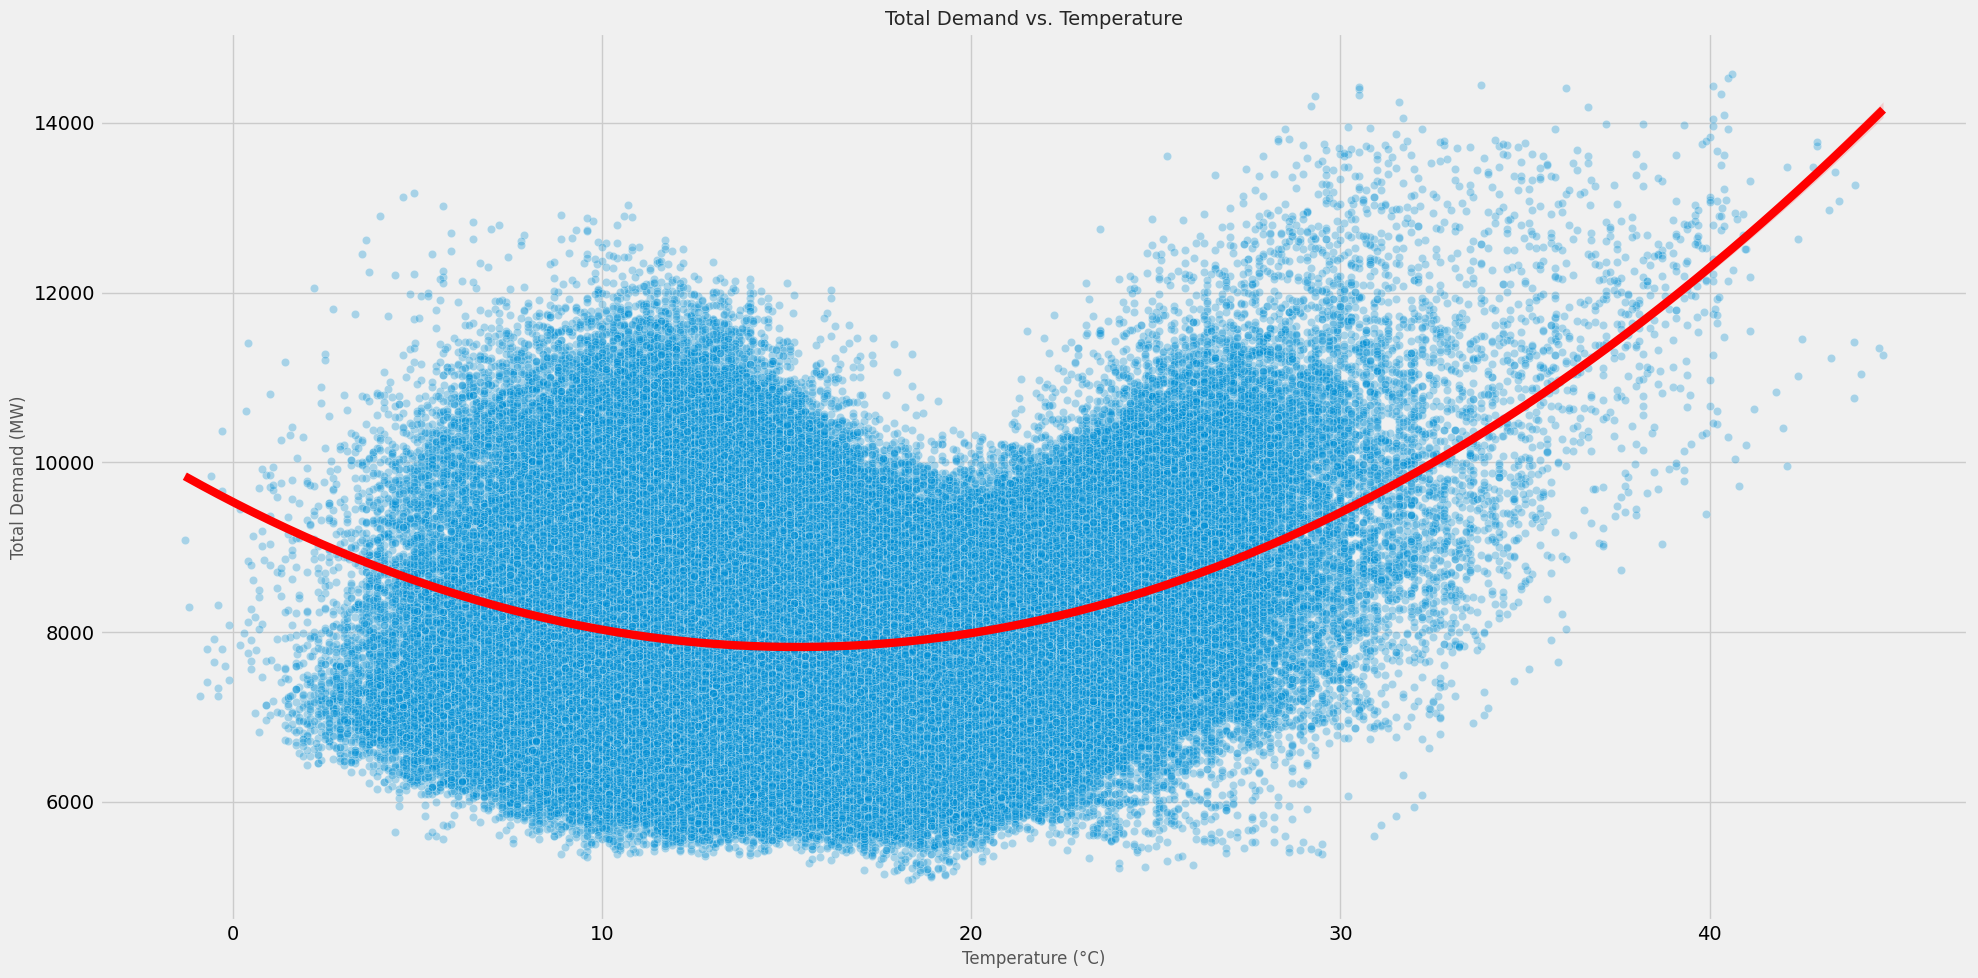

<Figure size 2000x1000 with 0 Axes>

In [30]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# temperature vs total demand
sns.scatterplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    alpha=0.3
)

# fit and plot a polynomial regression with order 2 (quadratic)
sns.regplot(
    x='TEMPERATURE', 
    y='TOTALDEMAND', 
    data=nsw_df, 
    order=2, 
    scatter=False, 
    color='red'
)

plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Temperature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join('./../images', 'total demand vs emperature.png'))

## Observations
The scatter plot shows Total Demand plotted against Temperature, with a quadratic trend line indicating the general pattern of the relationship between these two variables. Here are some observations we can infer from this plot:

1. **Non-linear Relationship**: There appears to be a non-linear, possibly quadratic relationship between temperature and total demand. Demand increases with temperature up to a certain point, after which it seems to plateau or even decline slightly.

2. **Increased Demand at Moderate Temperatures**: The highest total demand occurs at moderate temperatures, not at the extremes. This could indicate that the most energy-intensive activities (like heating and cooling) occur in a moderate temperature range.

3. **Lower Demand at Temperature Extremes**: There is a spread of demand at lower and higher temperatures, but the peaks are not as pronounced as in the moderate range. At low temperatures, this might mean adequate insulation or less need for electric heating. At high temperatures, it could imply that not all cooling is electric, or there may be a cap on how much cooling can be achieved.

4. **Possible Threshold Effect**: The trend line suggests that after a certain temperature threshold, increases in temperature do not result in significant increases in demand. This could be due to behavioral changes, energy-efficiency measures, or the saturation of cooling systems.

5. **Data Spread**: The considerable spread of data points at all temperature levels suggests that factors other than temperature also significantly influence total demand.

6. **High Variability**: There's significant variability in demand at specific temperatures, indicated by the vertical spread of points. This could be due to time-of-day effects, different days of the week, or other variables not accounted for in this two-dimensional plot.

In [31]:
# new feature
nsw_df['minutes_past_midnight'] = nsw_df.index.hour * 60 + nsw_df.index.minute

# Scatter plot: Total demand vs time of day (temp as color)
To visualize demand patterns at different times of the day.

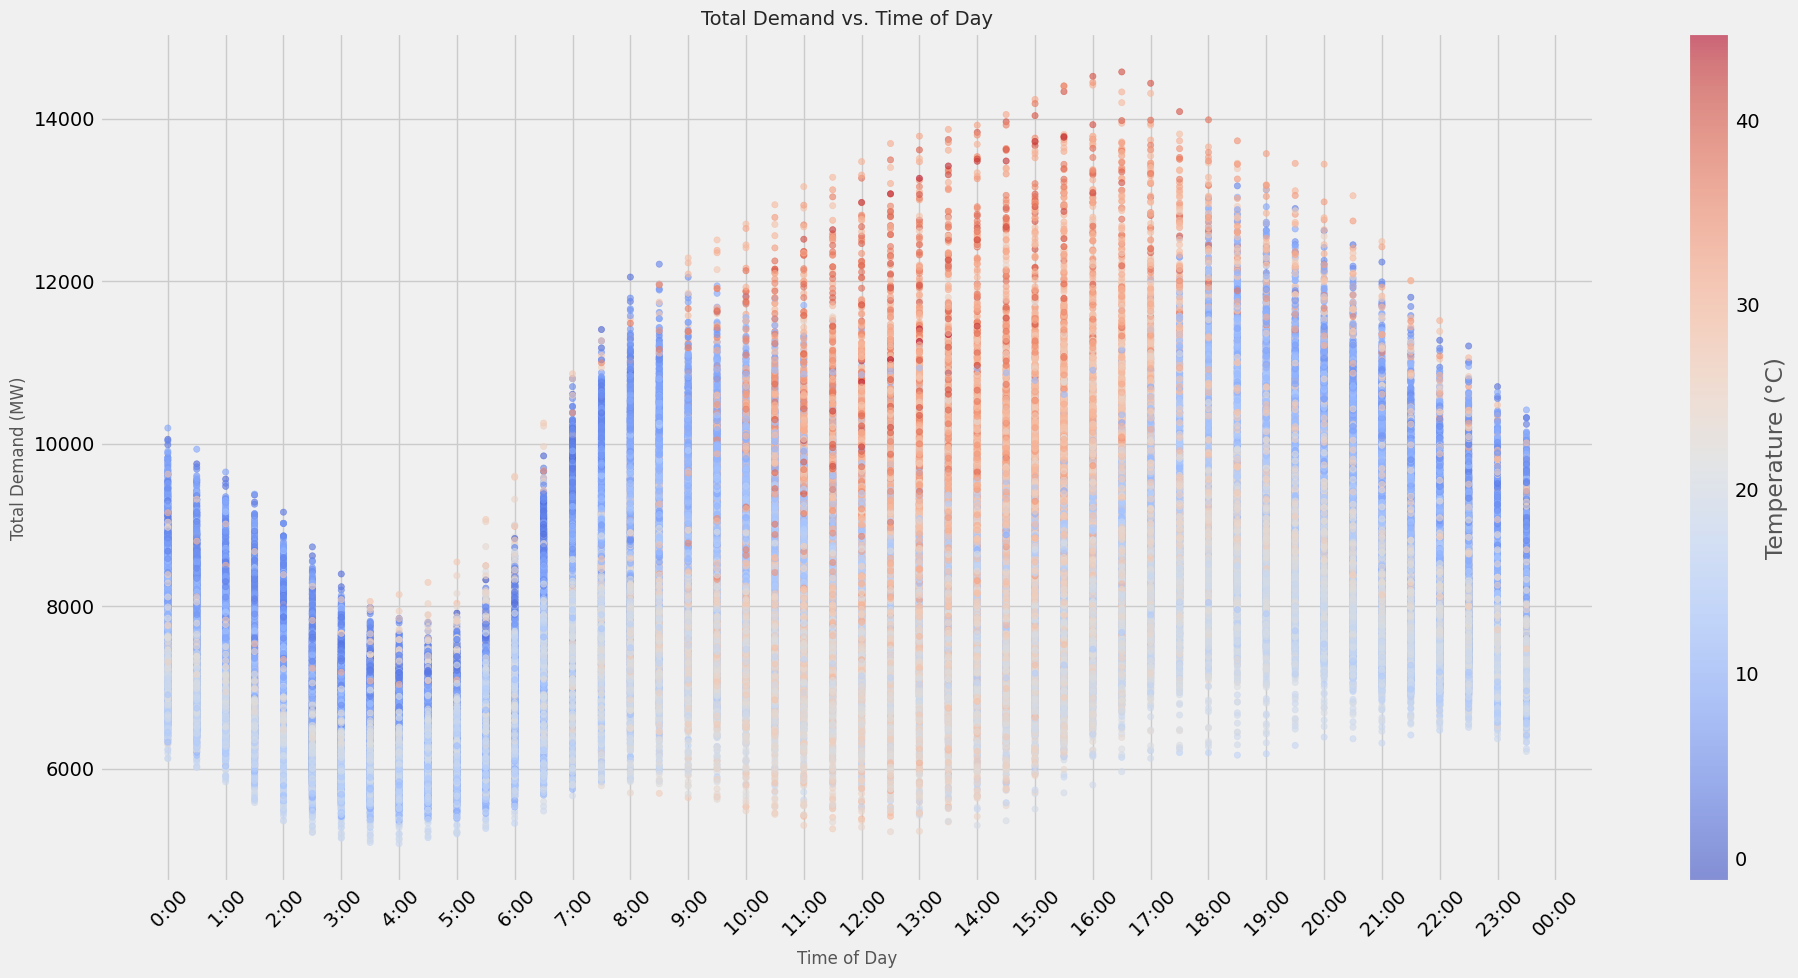

<Figure size 2000x1000 with 0 Axes>

In [32]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

# temperature, time and total demand
plt.scatter(
    nsw_df['minutes_past_midnight'], 
    nsw_df['TOTALDEMAND'], 
    c=nsw_df['TEMPERATURE'], 
    alpha=0.6, 
    cmap='coolwarm', 
    s=20
)  

plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Time of Day', fontsize=14)
plt.grid(True)
tick_positions = range(0, 1441, 60)
tick_labels = [f'{h: 02d}:00' for h in range(24)] + ['00:00']
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(os.path.join('./../images', 'total demand vs time of day.png'))

## Observations
1. **Demand Peaks**: It appears that there are two distinct peaks in electricity demand, likely corresponding to morning and evening hours. This is a common pattern in electricity usage, often related to increased activity as people prepare for work and school, and then again as they come home and use more appliances.

2. **Temperature Influence**: The color gradient indicates a relationship between temperature and total demand. Warmer colors at higher demand levels could suggest higher energy usage during warmer temperatures, which might be due to air conditioning and cooling systems.

3. **Cooler Temperatures**: At cooler temperatures (blue points), demand seems less intense compared to warmer temperatures, which might indicate less energy usage for heating compared to cooling, or it could suggest that the data is from a region where cooling needs are greater than heating needs.

4. **Demand Troughs**: There are clear periods where demand is lower, likely during the night when most activities cease, and there's little need for lighting and appliances.

5. **Midday Patterns**: There's a visible increase in demand around midday, which could be due to usage in commercial buildings or by industrial processes.

6. **Temperature Variability**: There's a spread of temperature values across all times, but particularly so during the times of peak demand. This suggests that on days with higher temperatures, the peaks in demand might be more pronounced.

7. **Intraday Variability**: There's significant variability in demand at any given time, which could be influenced by various factors including but not limited to temperature, such as the day of the week, holidays, or specific events.

# Histogram: total demand distribution
to get an idea of the most common demand levels

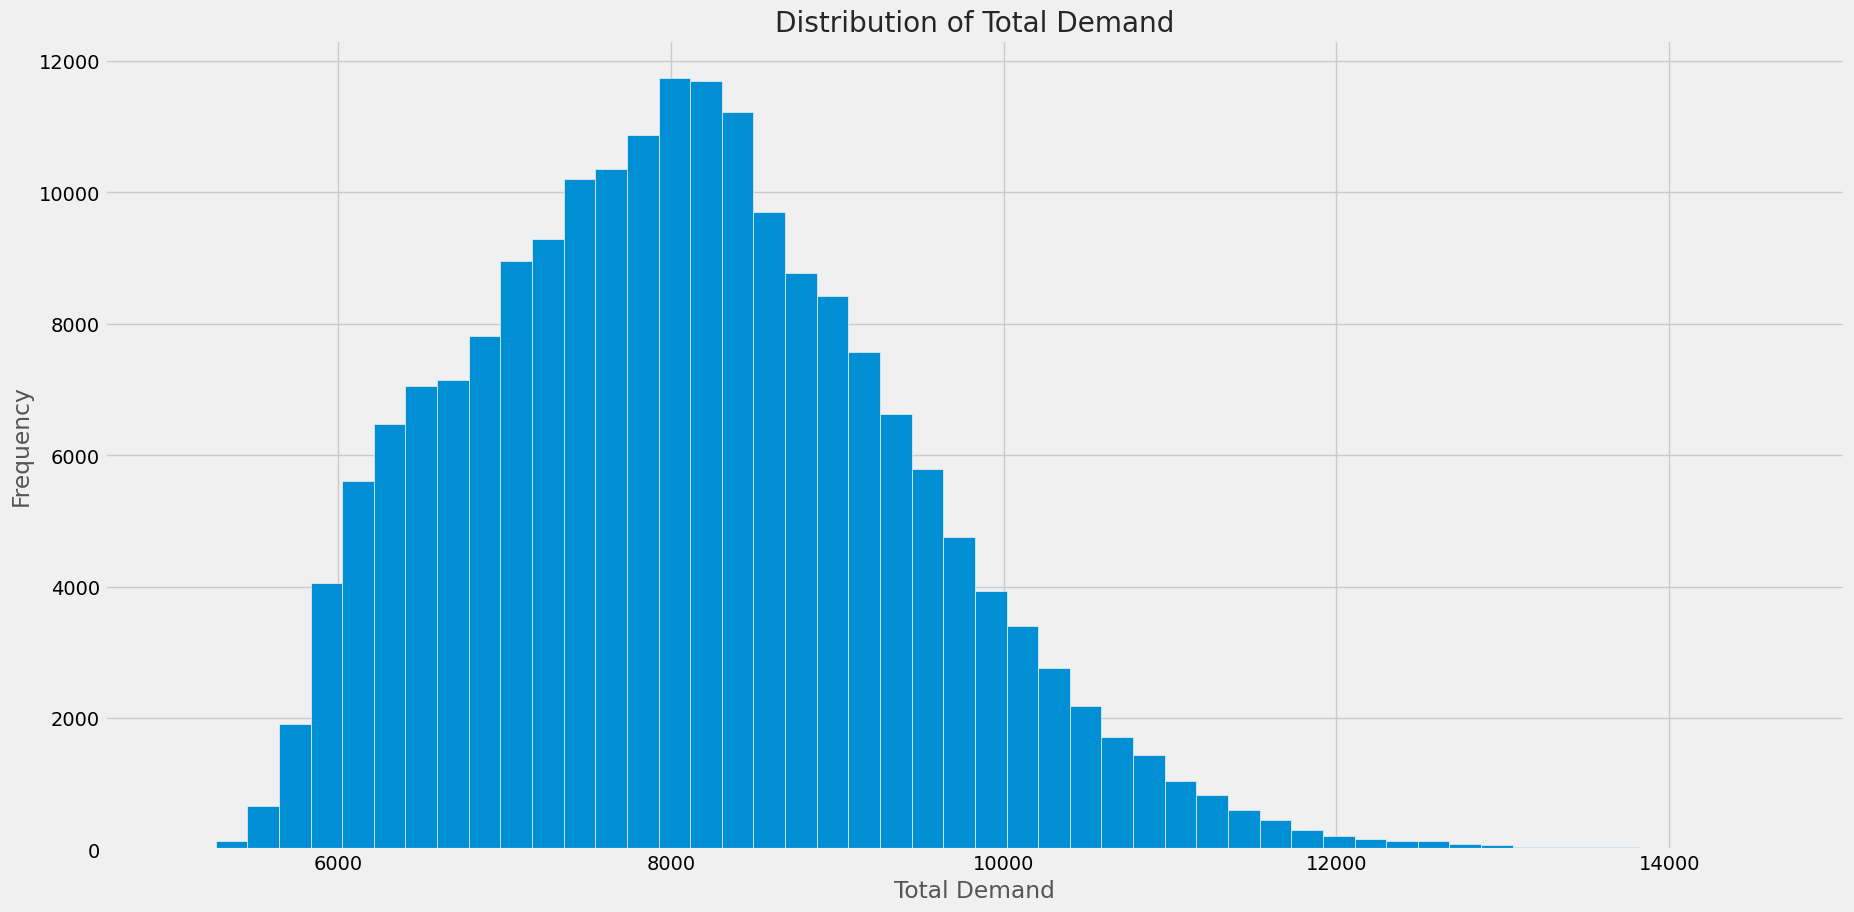

In [33]:
nsw_df['TOTALDEMAND'].hist(bins=50)
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

## Histogram: temperature distribution

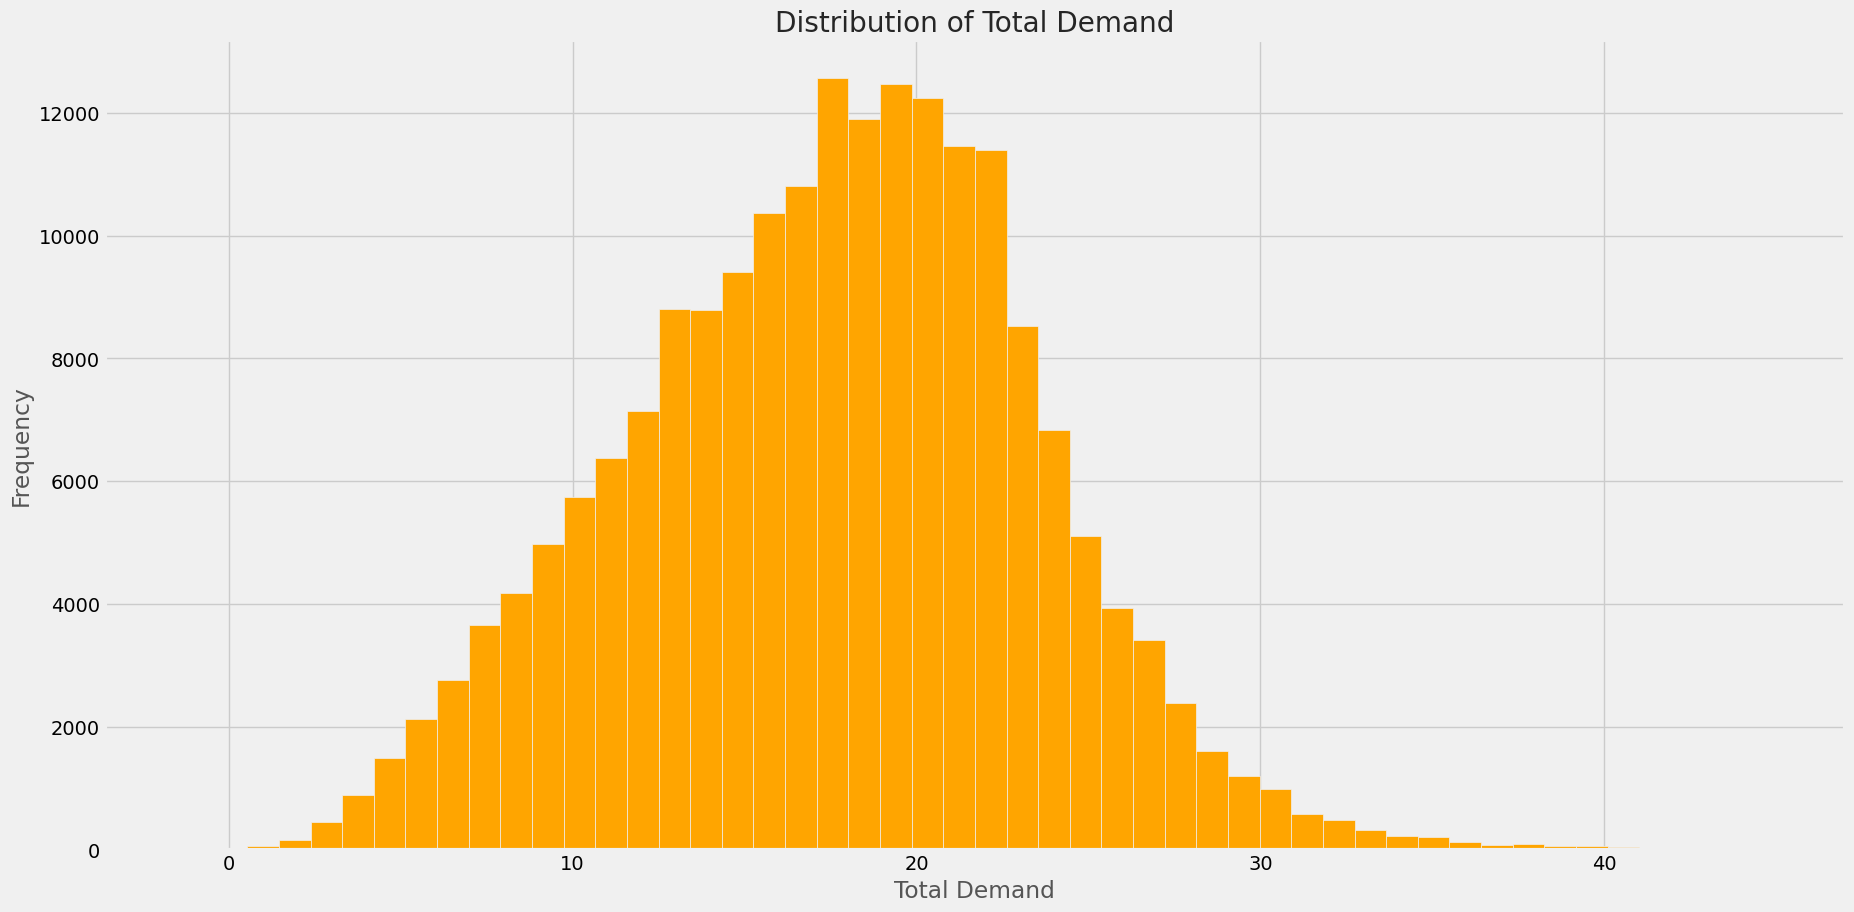

In [34]:
nsw_df['TEMPERATURE'].hist(bins=50, color='orange')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

# KDE of Total demand
to see the probability density of the total demand levels

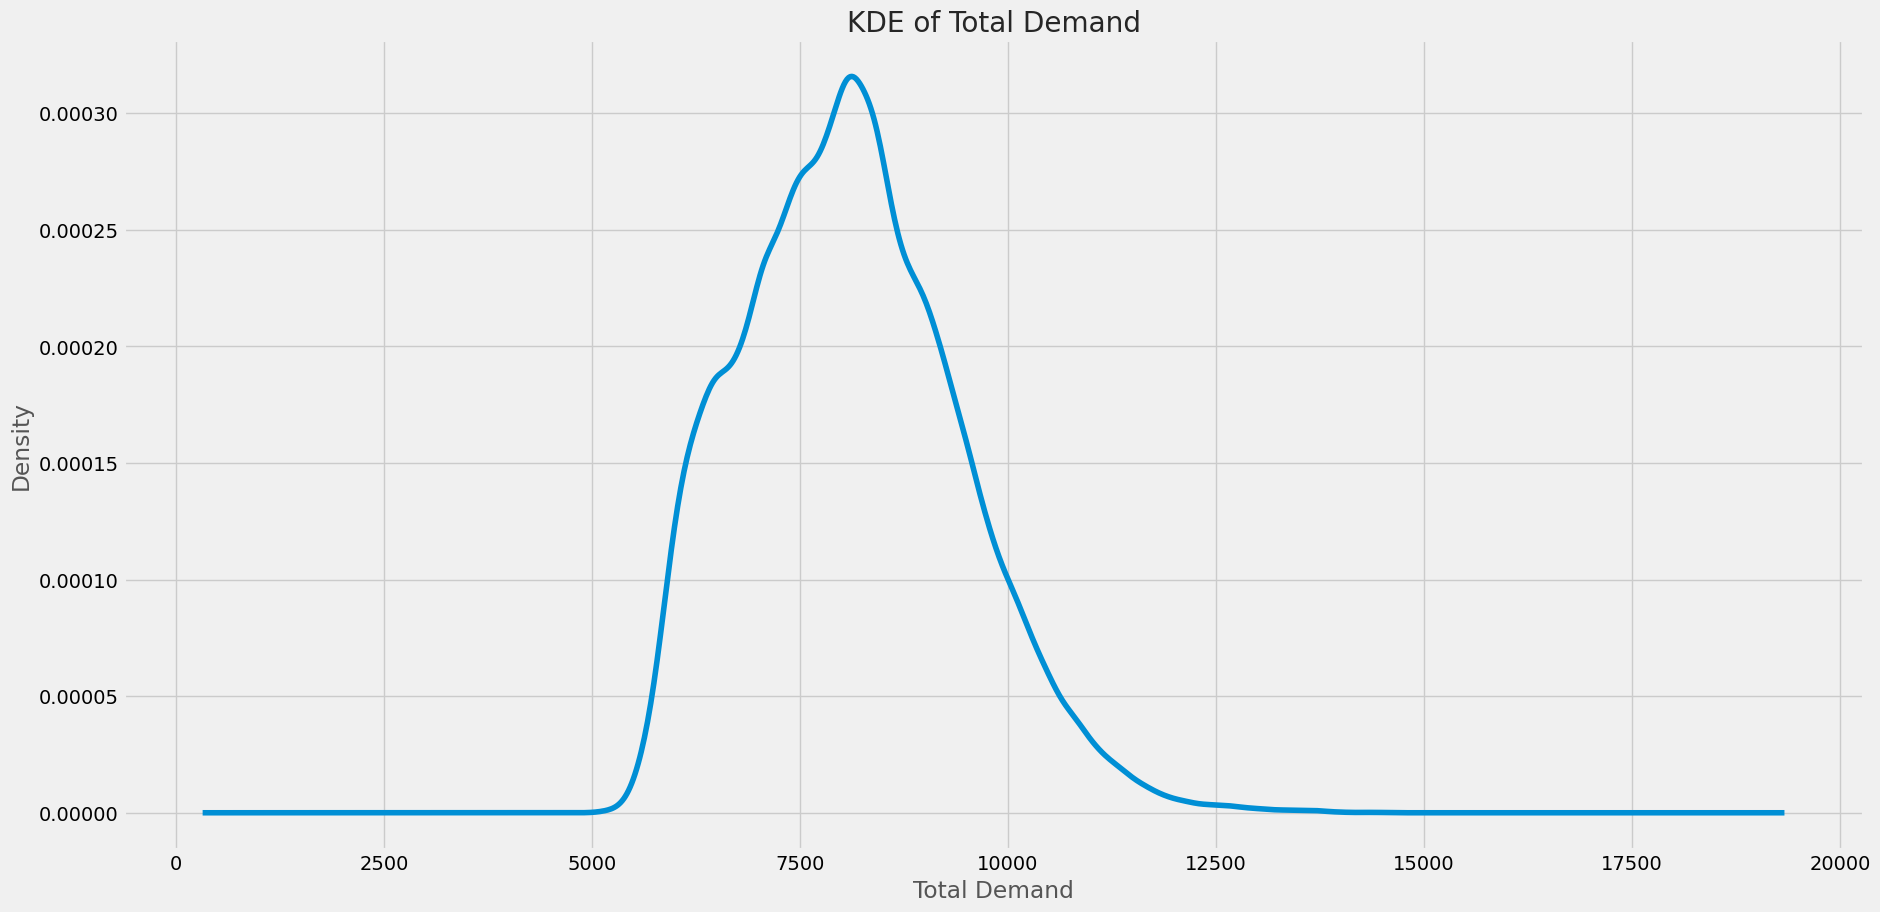

In [35]:
nsw_df['TOTALDEMAND'].plot(kind='kde')
plt.xlabel('Total Demand')
plt.title('KDE of Total Demand')
plt.show()
# plt.savefig(os.path.join('./../images', 'total demand vs time of day.png'))

# Autocorrelation plot

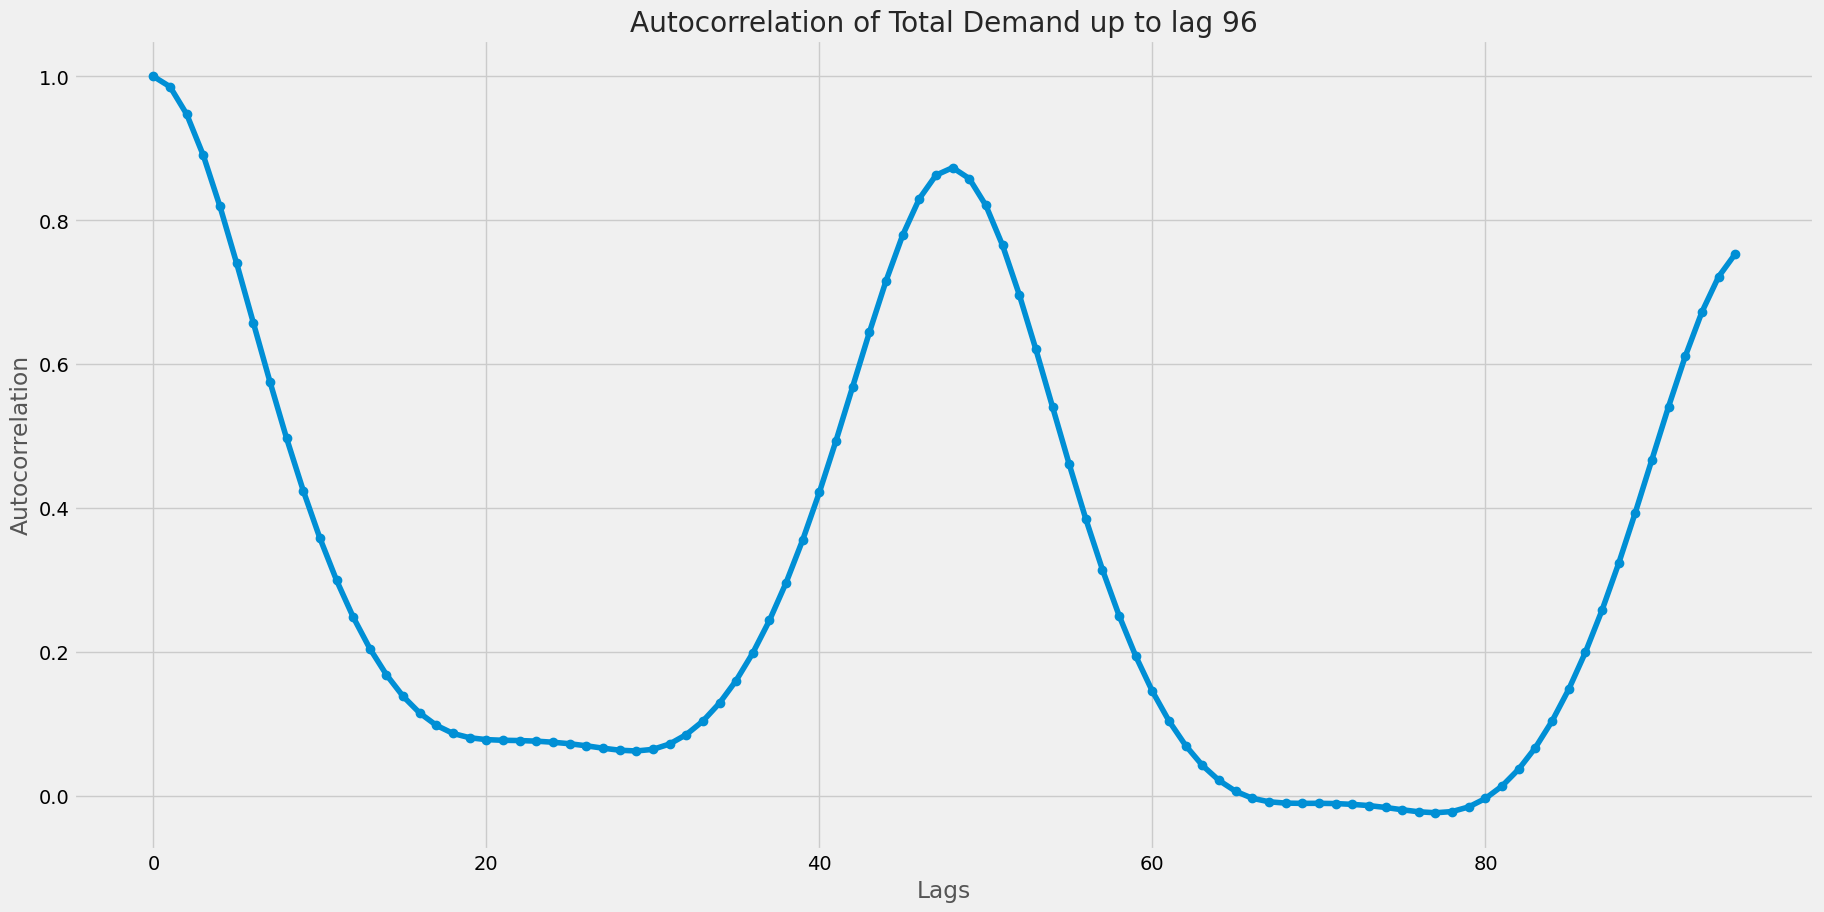

In [36]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
max_lags = 96
autocorrelation_values = [nsw_df['TOTALDEMAND'].autocorr(lag=i) for i in range(max_lags)]
plt.plot(autocorrelation_values, marker='o')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Total Demand up to lag {}'.format(max_lags))
plt.show()
# plt.savefig(os.path.join('./../images', 'total demand vs time of day.png'))

## Observations
For half-hourly data, 96 lags represent a full two days. From the autocorrelation plot, we can make some key interpretations:

1. **High Initial Autocorrelation**: The autocorrelation starts at 1 (as it must, since this represents correlation with itself at lag 0) and remains high over the initial lags, which suggests that the demand data is strongly influenced by its immediate past values. This could be due to consistent patterns of demand across adjacent time intervals.

2. **Daily Seasonality**: The peak in autocorrelation at lag 48 (which represents a full day's lag for half-hourly data) indicates a strong daily seasonal pattern. The demand at the same time on one day is highly correlated with the demand at the same time on the next day.

3. **Two-Day Cycle**: The second peak at lag 96 shows that the demand also correlates with itself two days apart. This reinforces the daily seasonality and suggests a stable pattern of demand that repeats every 48 half-hour period.

4. **Troughs at Intermediate Lags**: The troughs at lags that are halfway between the peaks (around 24 and 72) may suggest a less significant correlation at these intermediate points. This could be due to the contrast between daytime and nighttime demand or the differences in demand patterns between workdays and non-workdays.

This autocorrelation structure indicates that any models for forecasting or analysis should account for daily seasonality. Time series models such as ARIMA with seasonal components or machine learning models with lagged features might be well-suited to capture and predict these patterns.

# normalisation / standardisation
I'm using z-score normalisation instead of log transform because temperature contains zero and negative values. I started out using scipy.stats implementation but have moved to sklearn StandardScaler

In [37]:
# dict = {
#     "TOTALDEMAND": "normalised_total_demand",
#     "FORECASTDEMAND": "normalised_forecast_demand",
#     'TEMPERATURE': 'normalised_temperature'
# }
# nsw_df = normalize_columns(nsw_df, dict)

# Boxplot
plot the box plots for the normalised values

In [38]:
# plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
# plt.boxplot(
#     [
#         nsw_df['normalised_total_demand'], 
#         nsw_df['normalised_forecast_demand'],
#         nsw_df['normalised_temperature']
#     ],
#     labels=[
#         'Normalised Total Demand', 
#         'Normalised Forecast Demand', 
#         'Normalised Temperature'
#     ]
# )
# plt.title('Normalised Distributions of Demand and Temperature')
# plt.show()

## Observations
Based on the box plot for the normalised distributions of Total Demand, Forecast Demand, and Temperature:

1. **Central Tendency**: The median of the Total Demand and Forecast Demand (indicated by the line in the middle of the box) are at or near zero, which is expected after normalization. It seems the median for Temperature is also close to zero after normalization.

2. **Variability**: The interquartile range (IQR, represented by the box) is more extended for Total Demand compared to Forecast Demand, indicating greater variability in actual demand. The IQR for Temperature appears much smaller, suggesting less variability relative to its mean.

3. **Outliers**: The presence of outliers is indicated by the points beyond the whiskers in both Total Demand and Forecast Demand. These are individual data points that lie beyond the typical range (1.5 times the IQR).

4. **Symmetry**: The distributions for both demand variables appear reasonably symmetrical around their median, though Total Demand has a notable number of high outliers.

5. **Comparison of Distributions**: The fact that both demands have similar box heights (IQRs) but Total Demand has more outliers could indicate that extreme values are more common in the actual demand than forecasted. 

6. **Temperature Distribution**: Even though the temperature is normalized, the small IQR and the presence of outliers suggest that there are times when the temperature is significantly different from the mean temperature.

# Decomposition

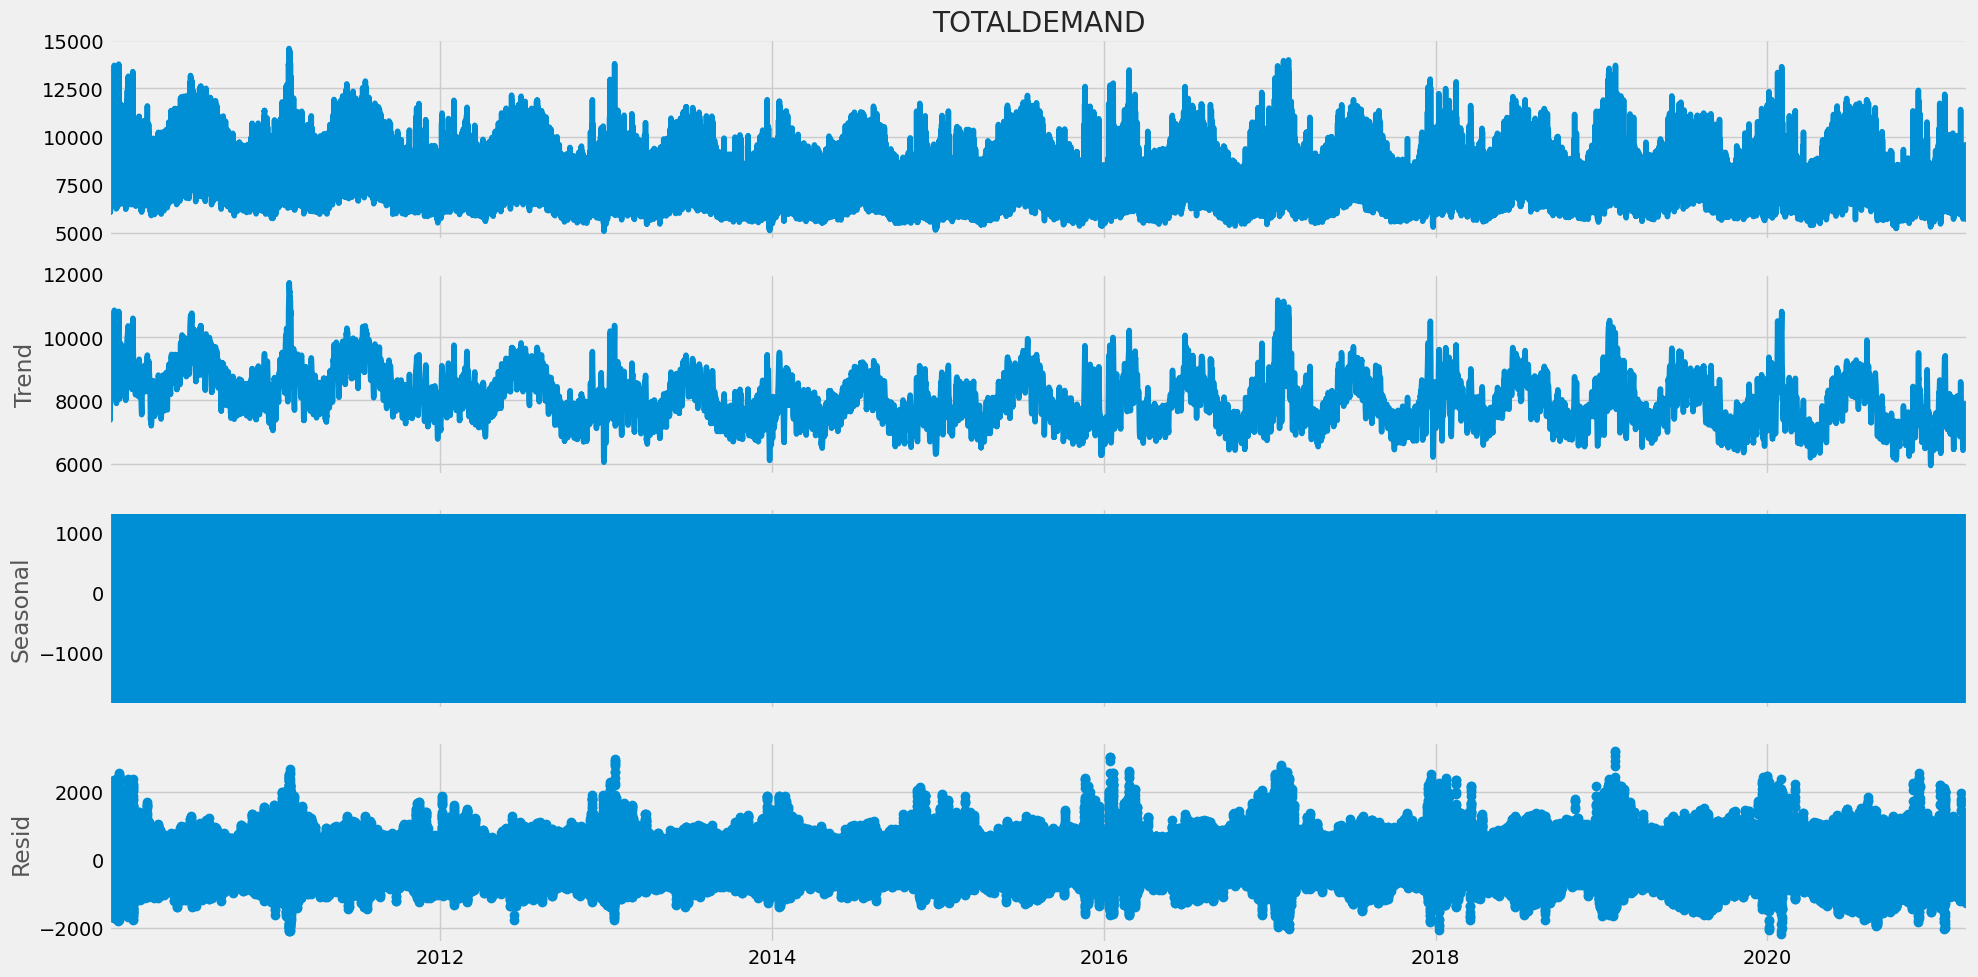

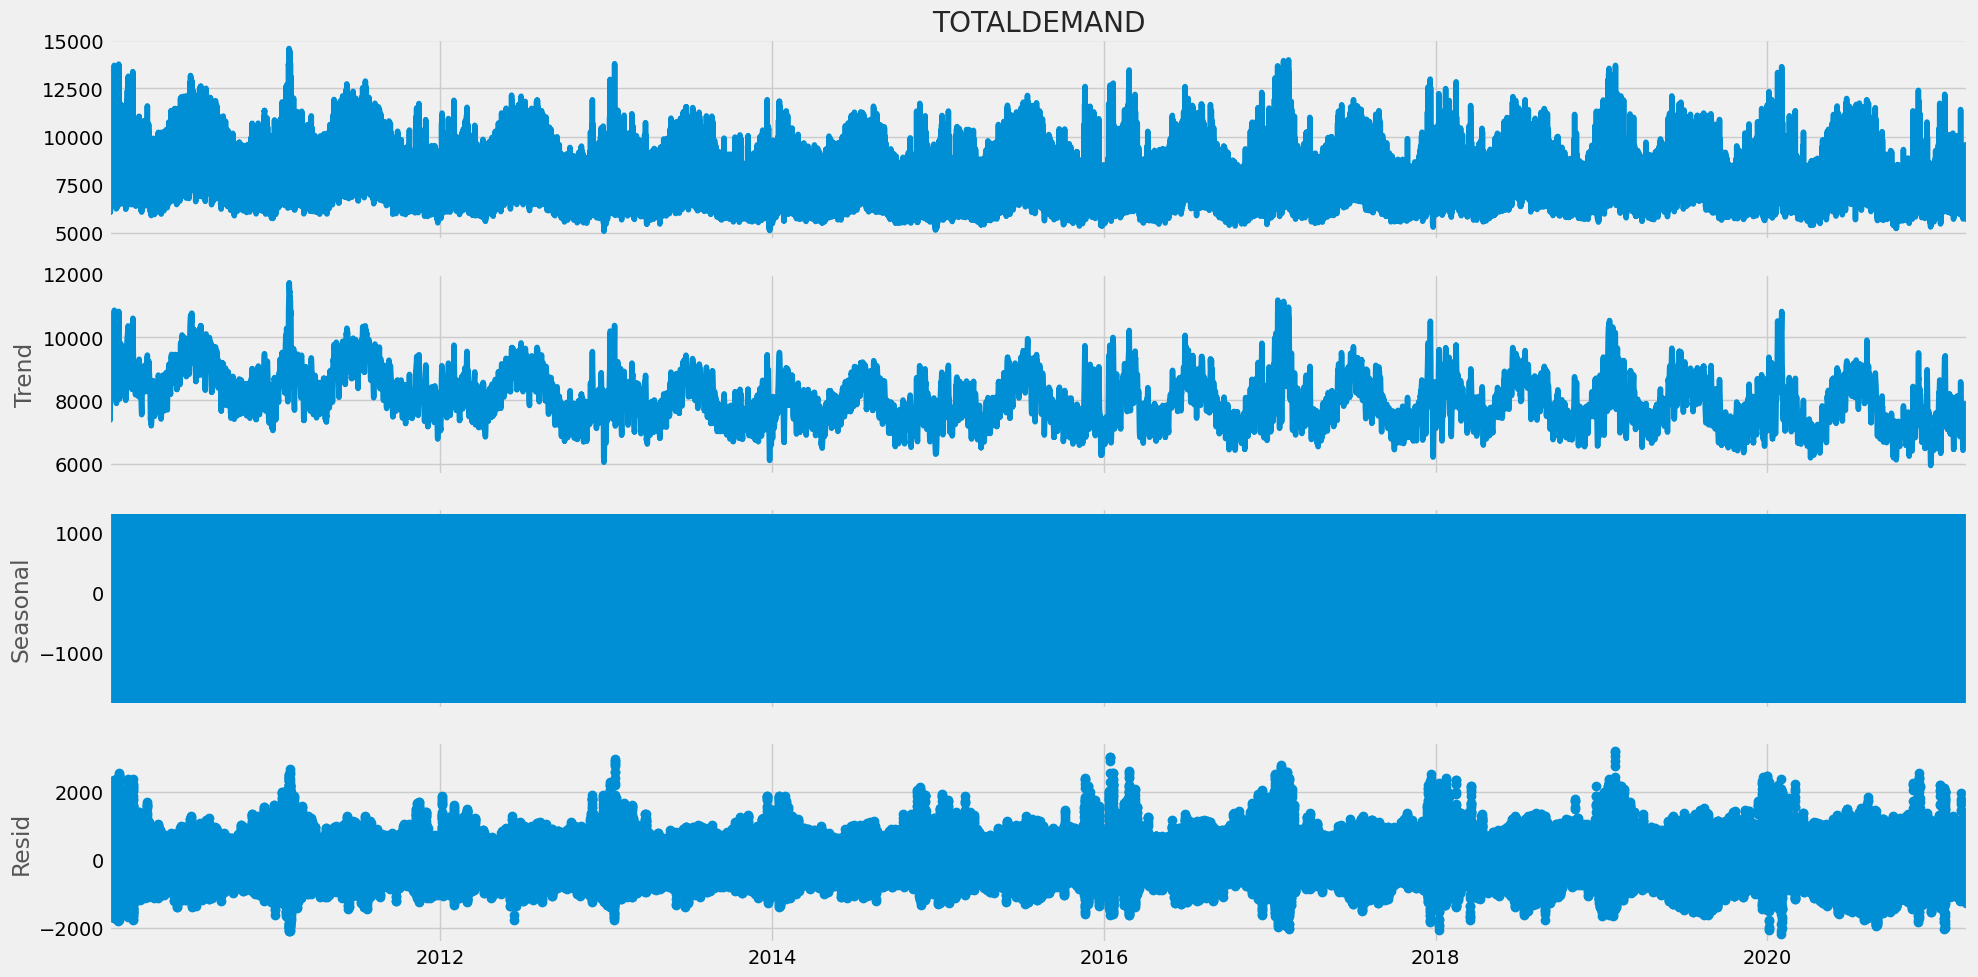

In [39]:
res = seasonal_decompose(
    nsw_df['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res.plot()

# Decomposition of 1 year of data

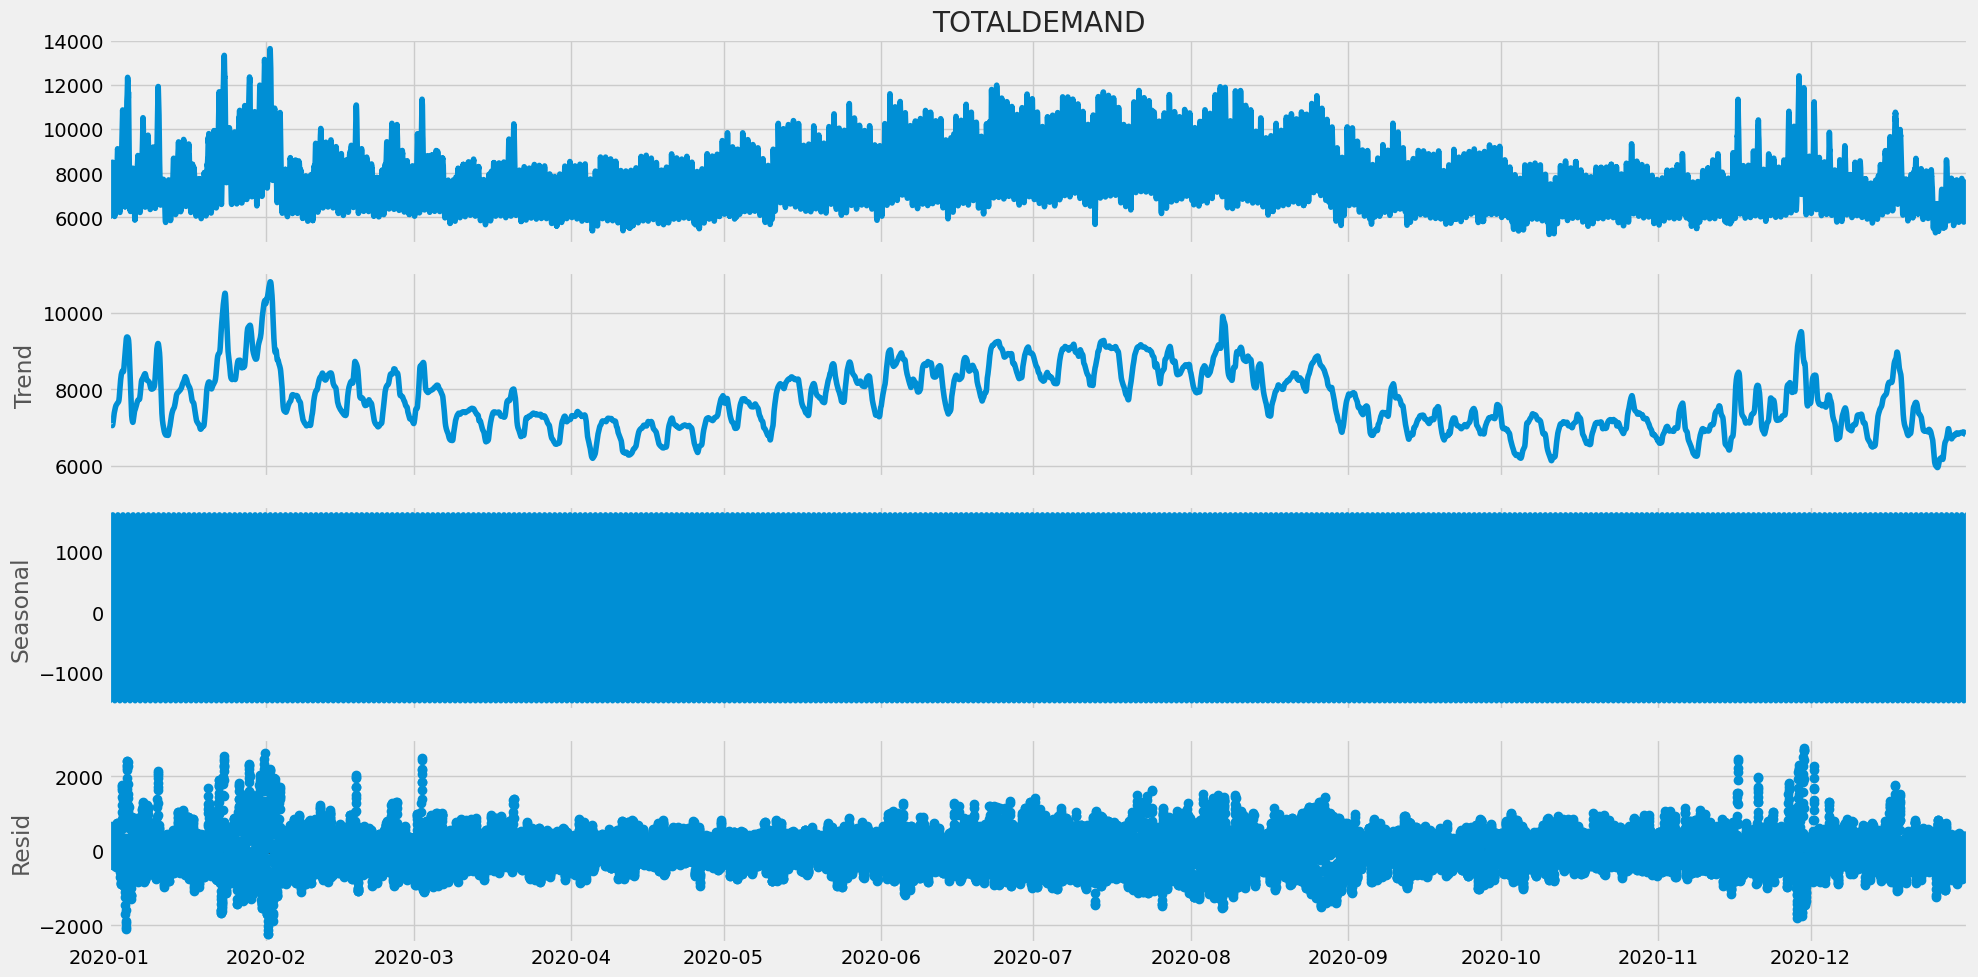

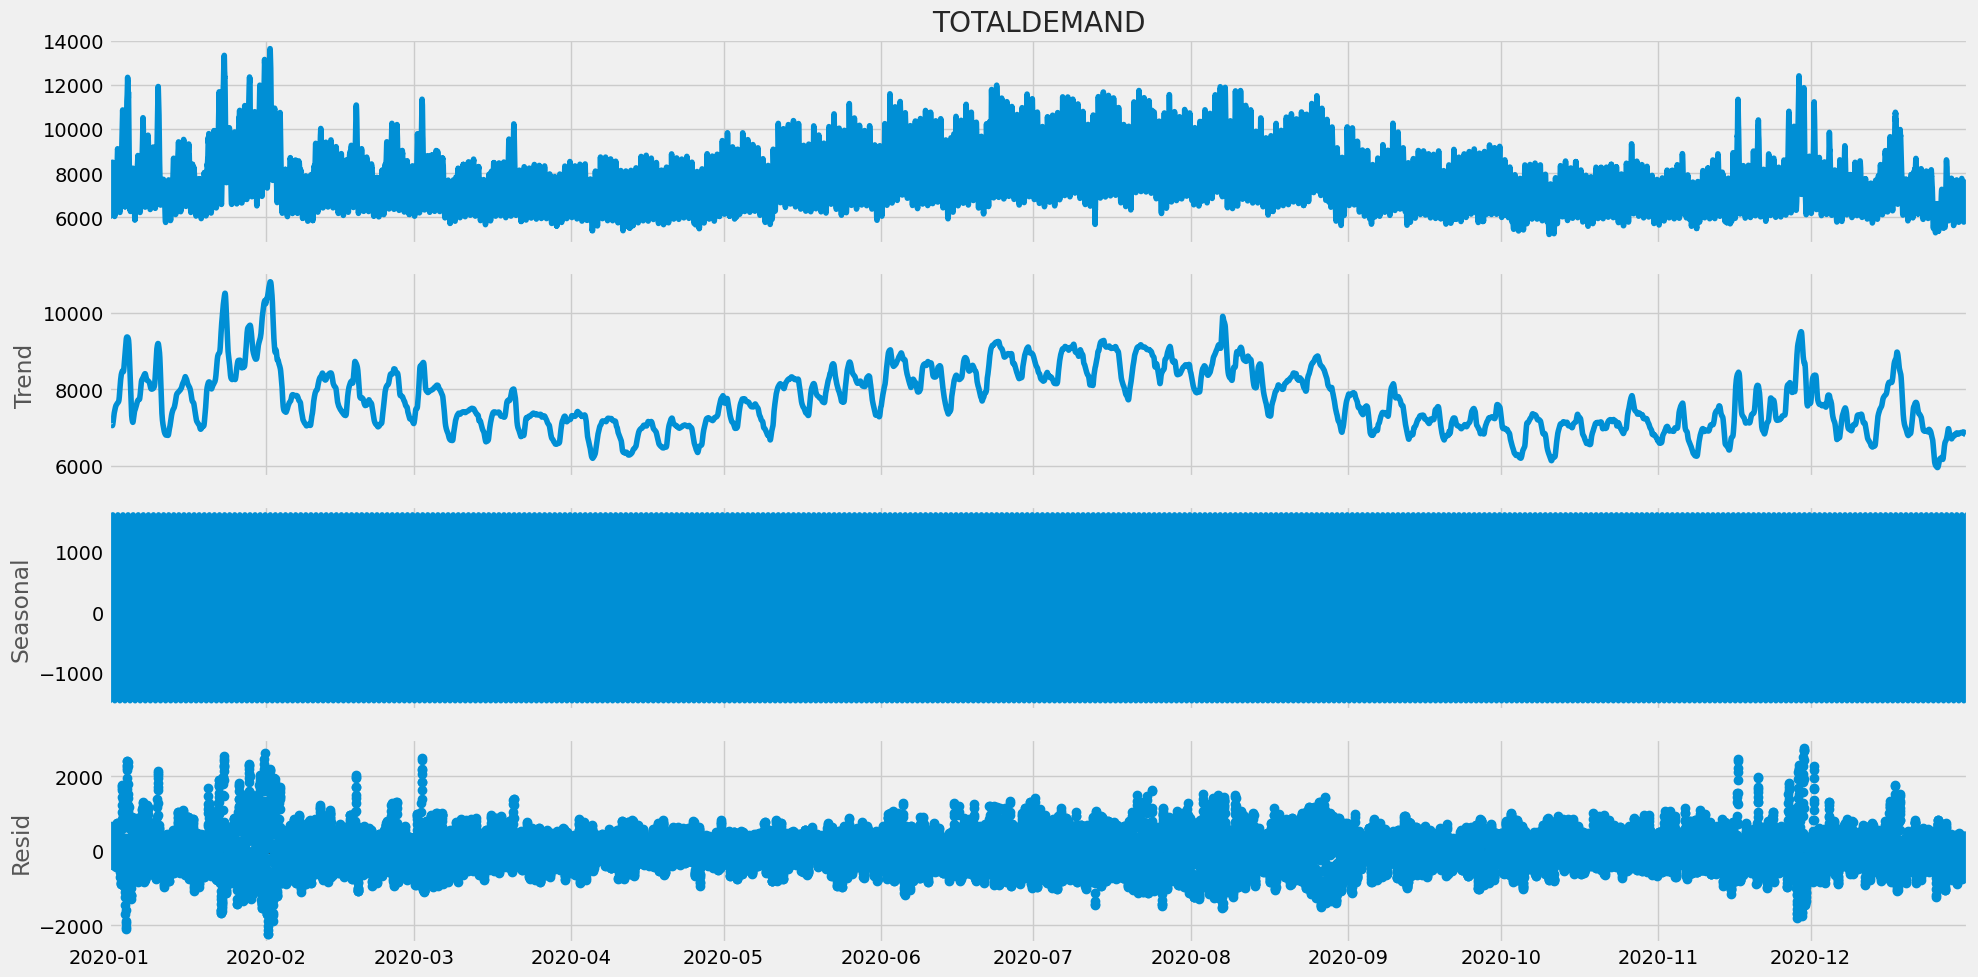

In [40]:
one_year_data = nsw_df.loc['2020']

res_one_year = seasonal_decompose(
    one_year_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res_one_year.plot()

### decompose for one week

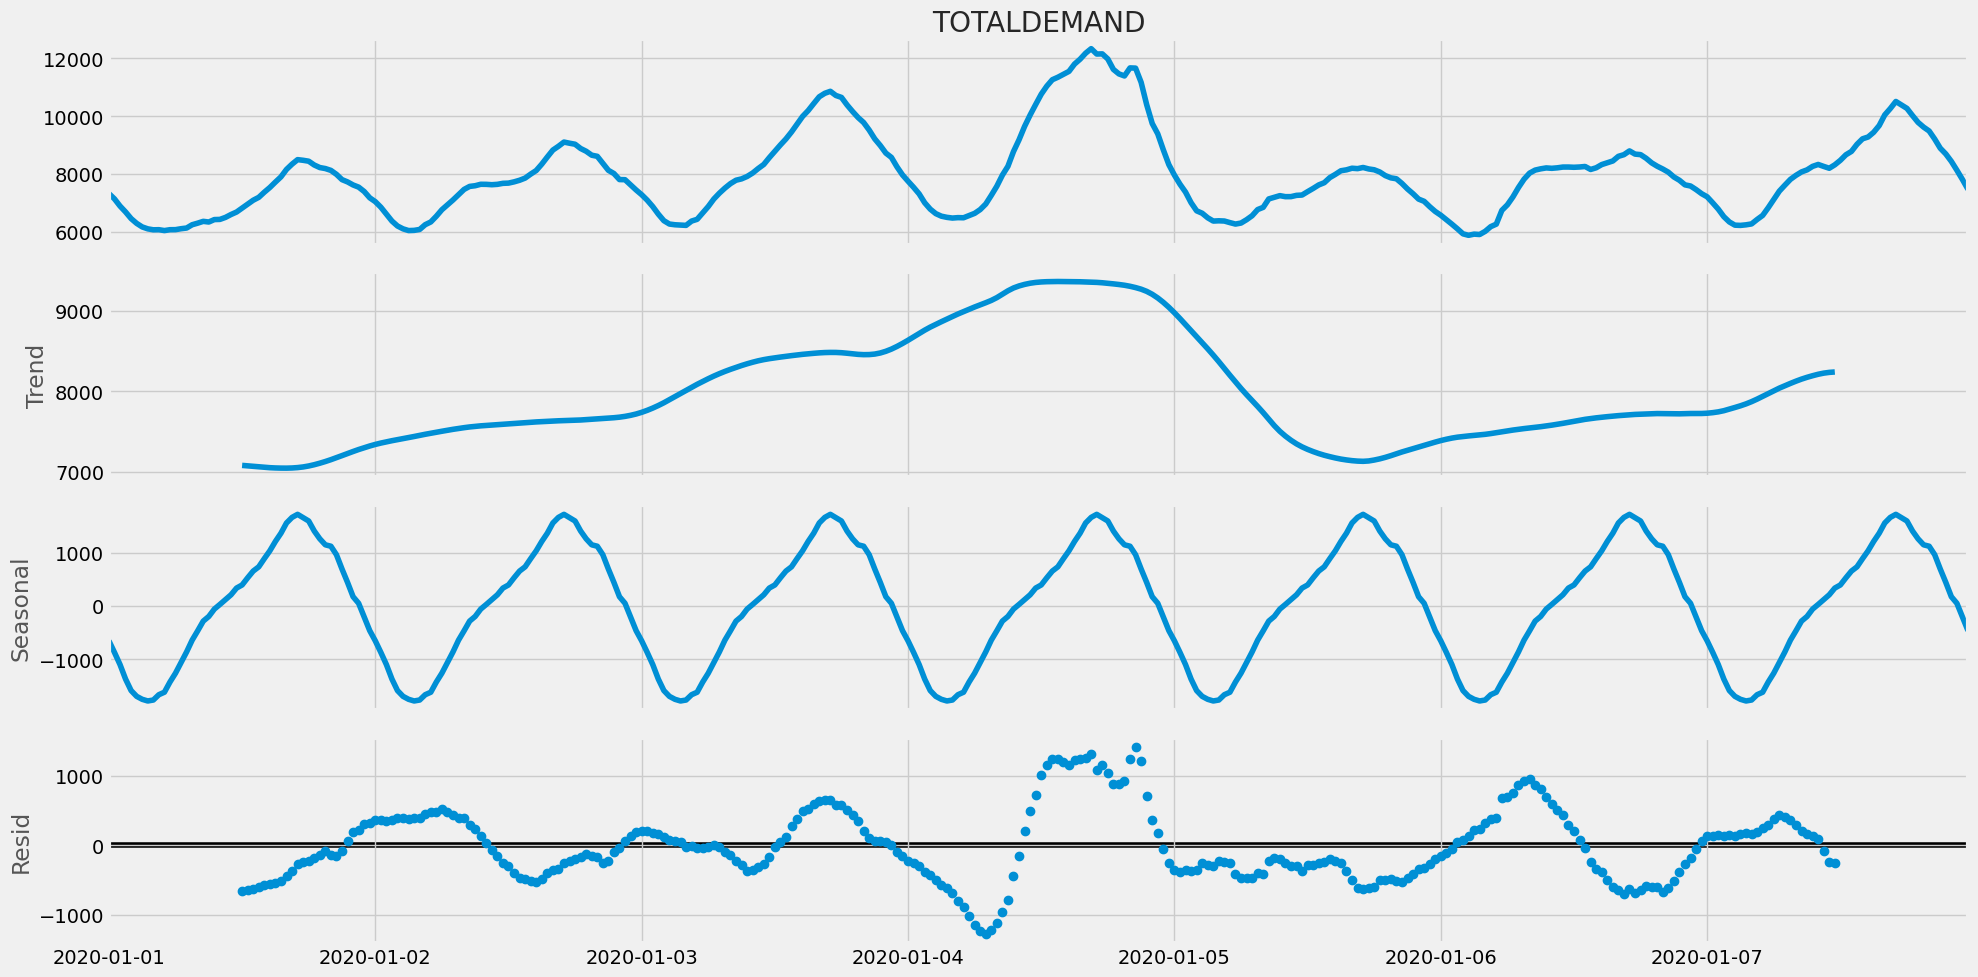

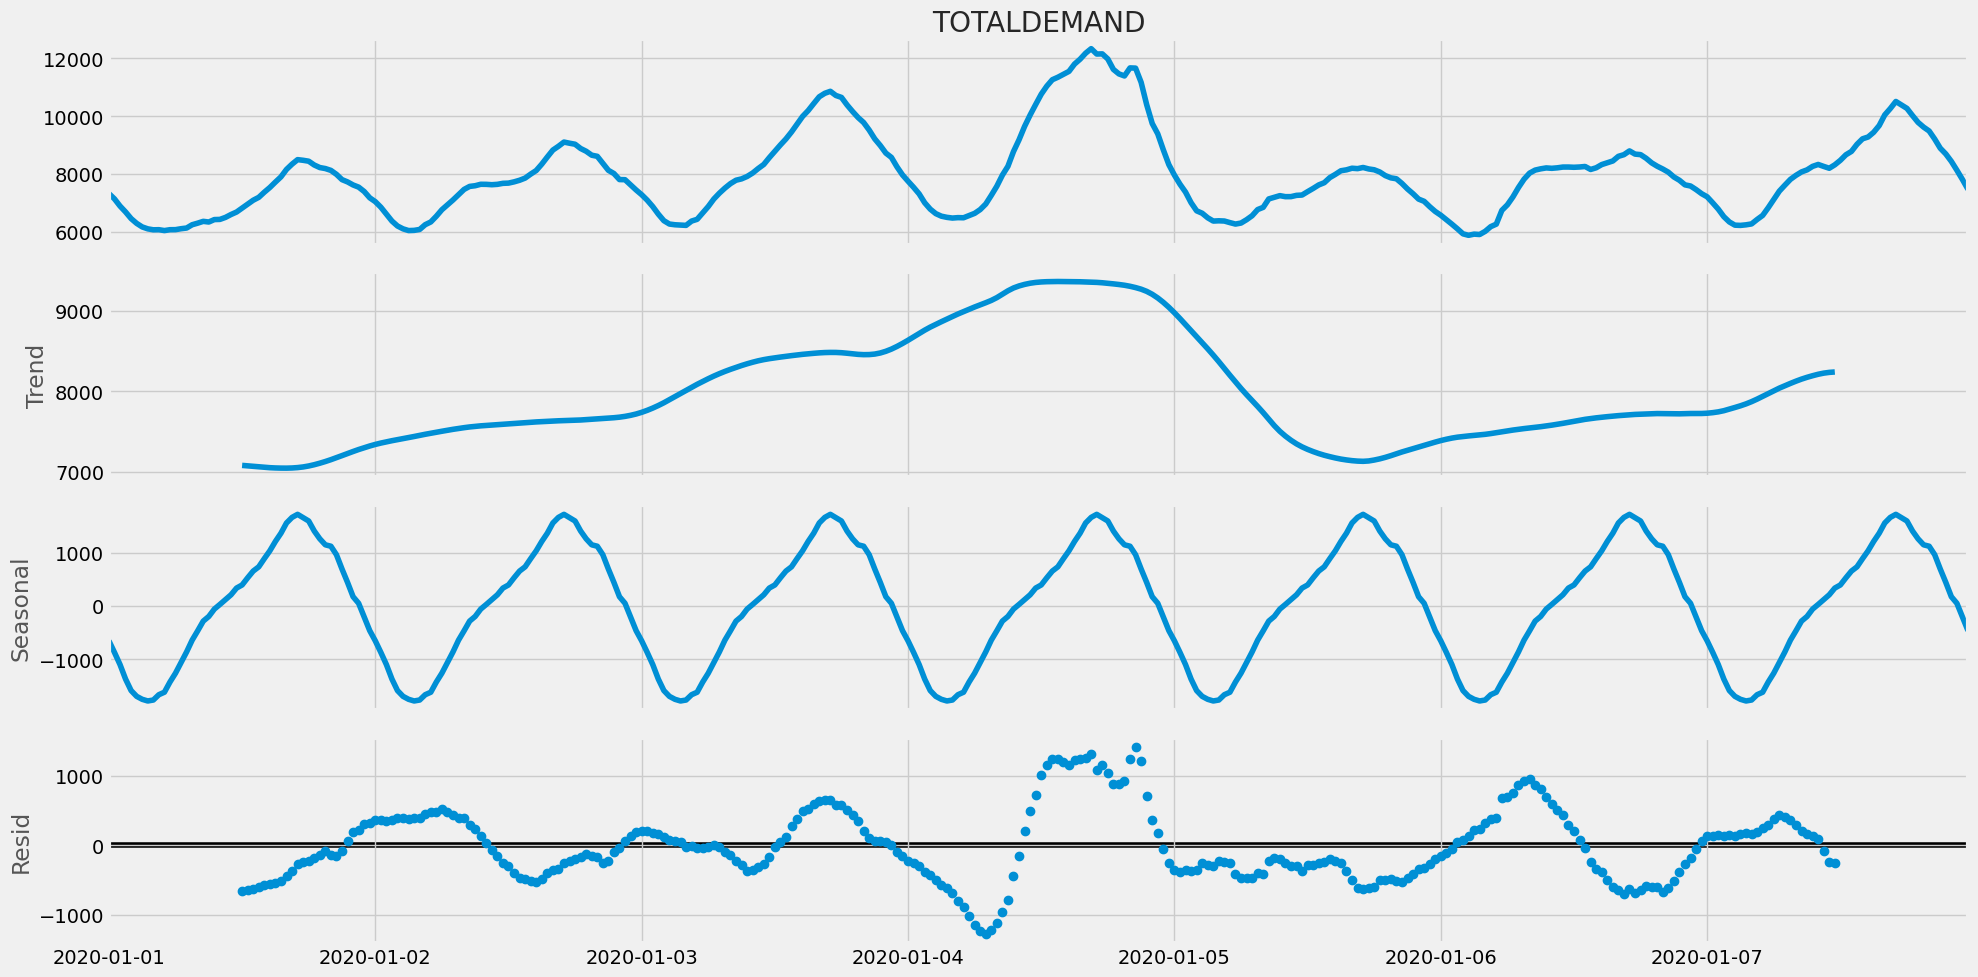

In [41]:
one_week_data = nsw_df['2020-01-01':'2020-01-07']

res_one_week = seasonal_decompose(
    one_week_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)

res_one_week.plot()

### Decompose for 2 days

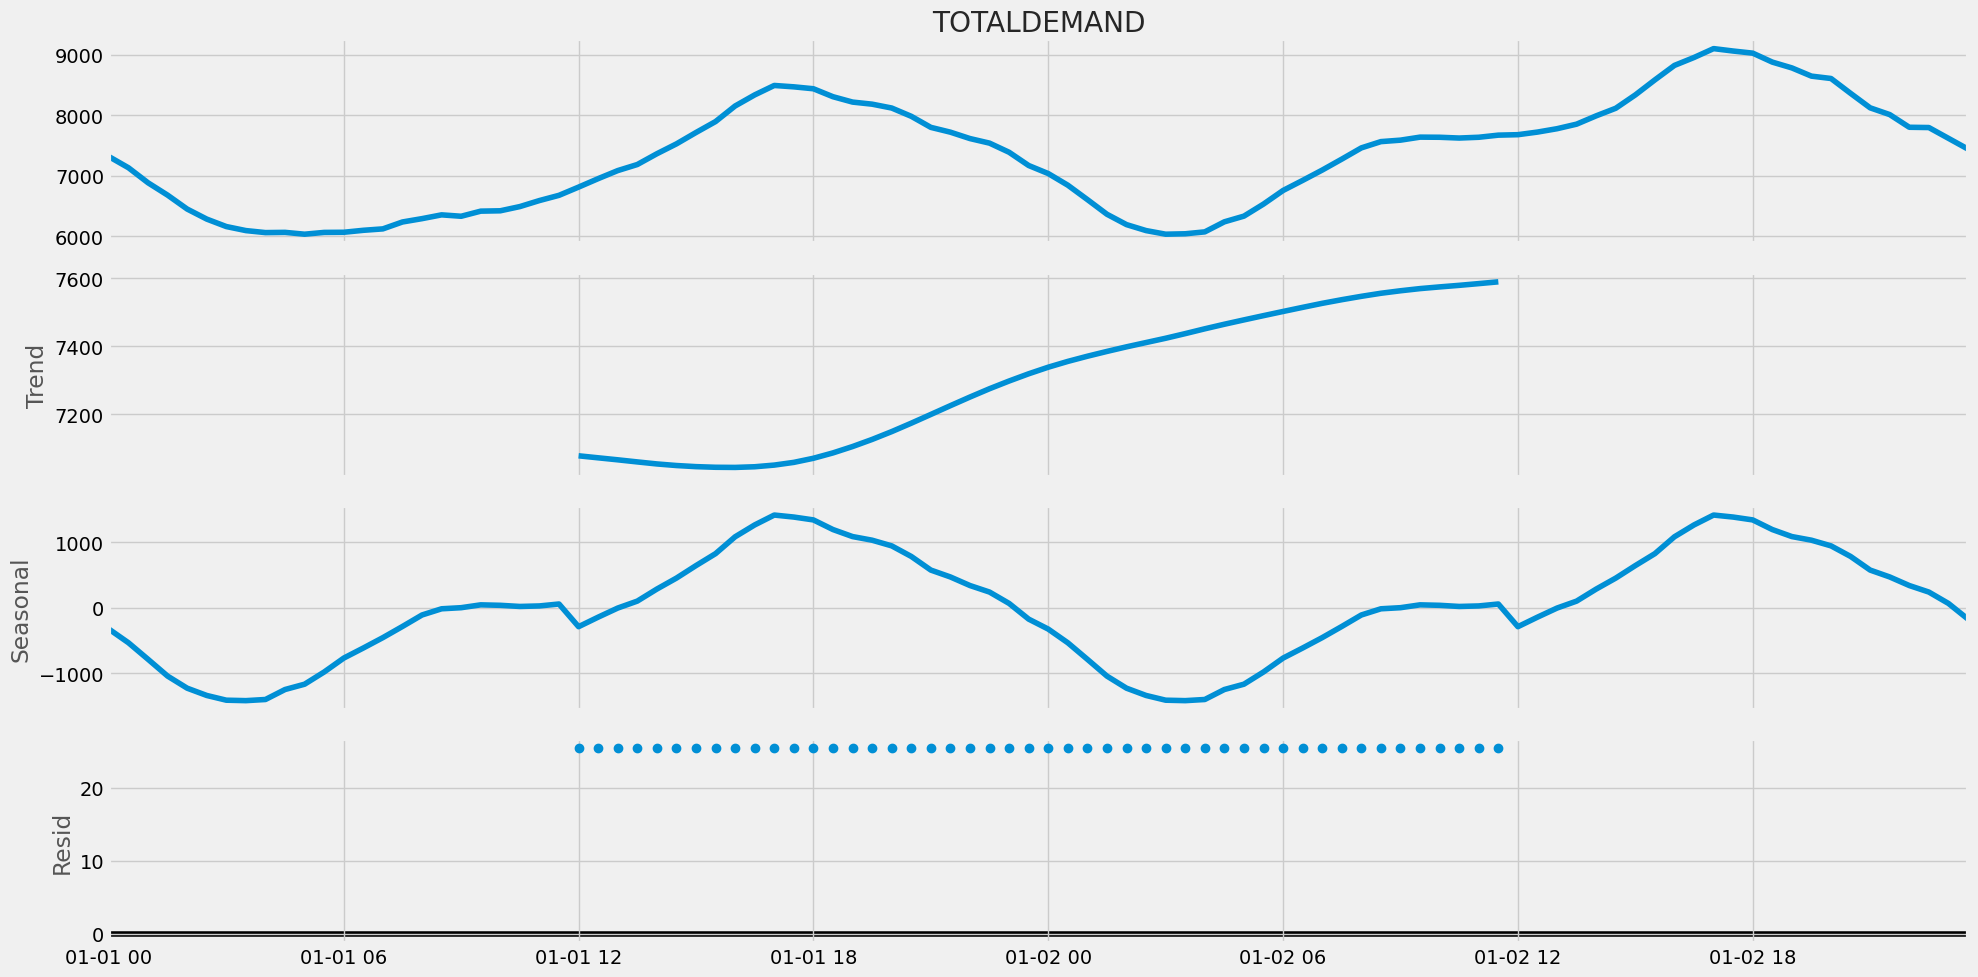

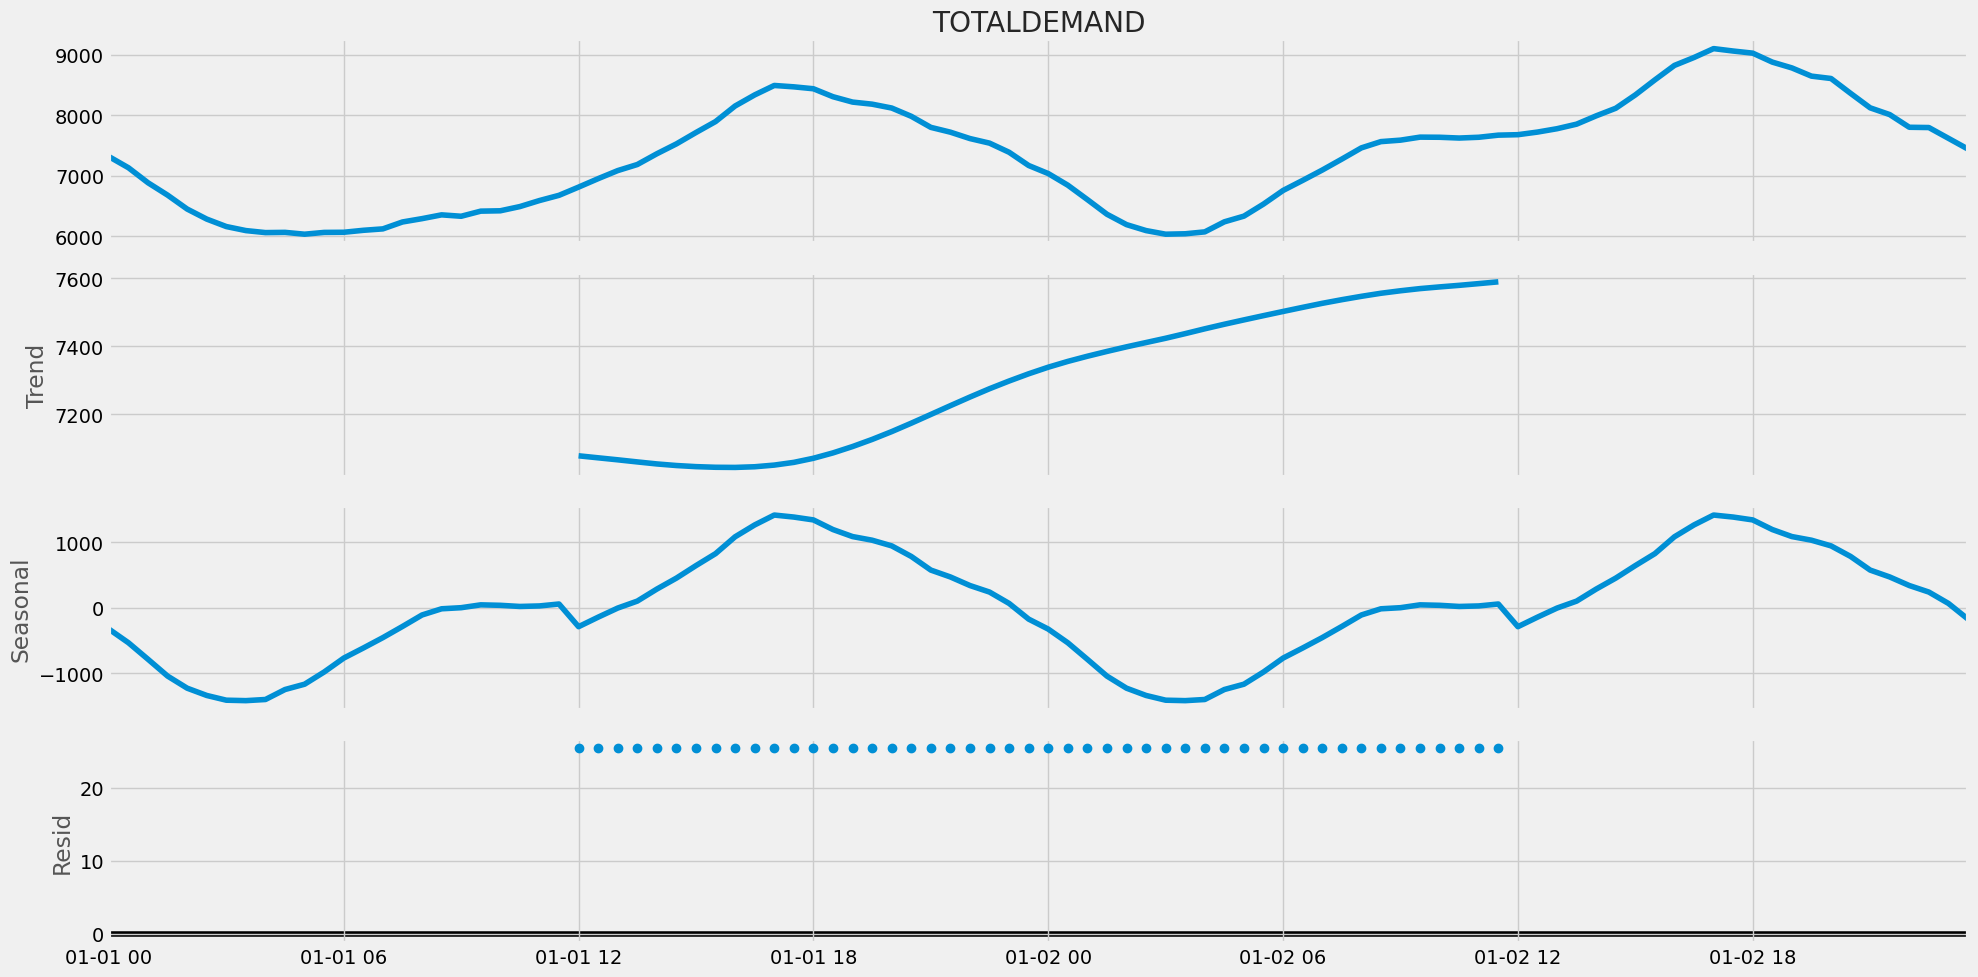

In [42]:
one_day_data = nsw_df['2020-01-01 00:00:00': '2020-01-02 23:30:00']

res_one_day = seasonal_decompose(
    one_day_data['TOTALDEMAND'], 
    model='additive',
    period=48
)

res_one_day.plot()

# Autocorrelation analysis (ACF and PACF)

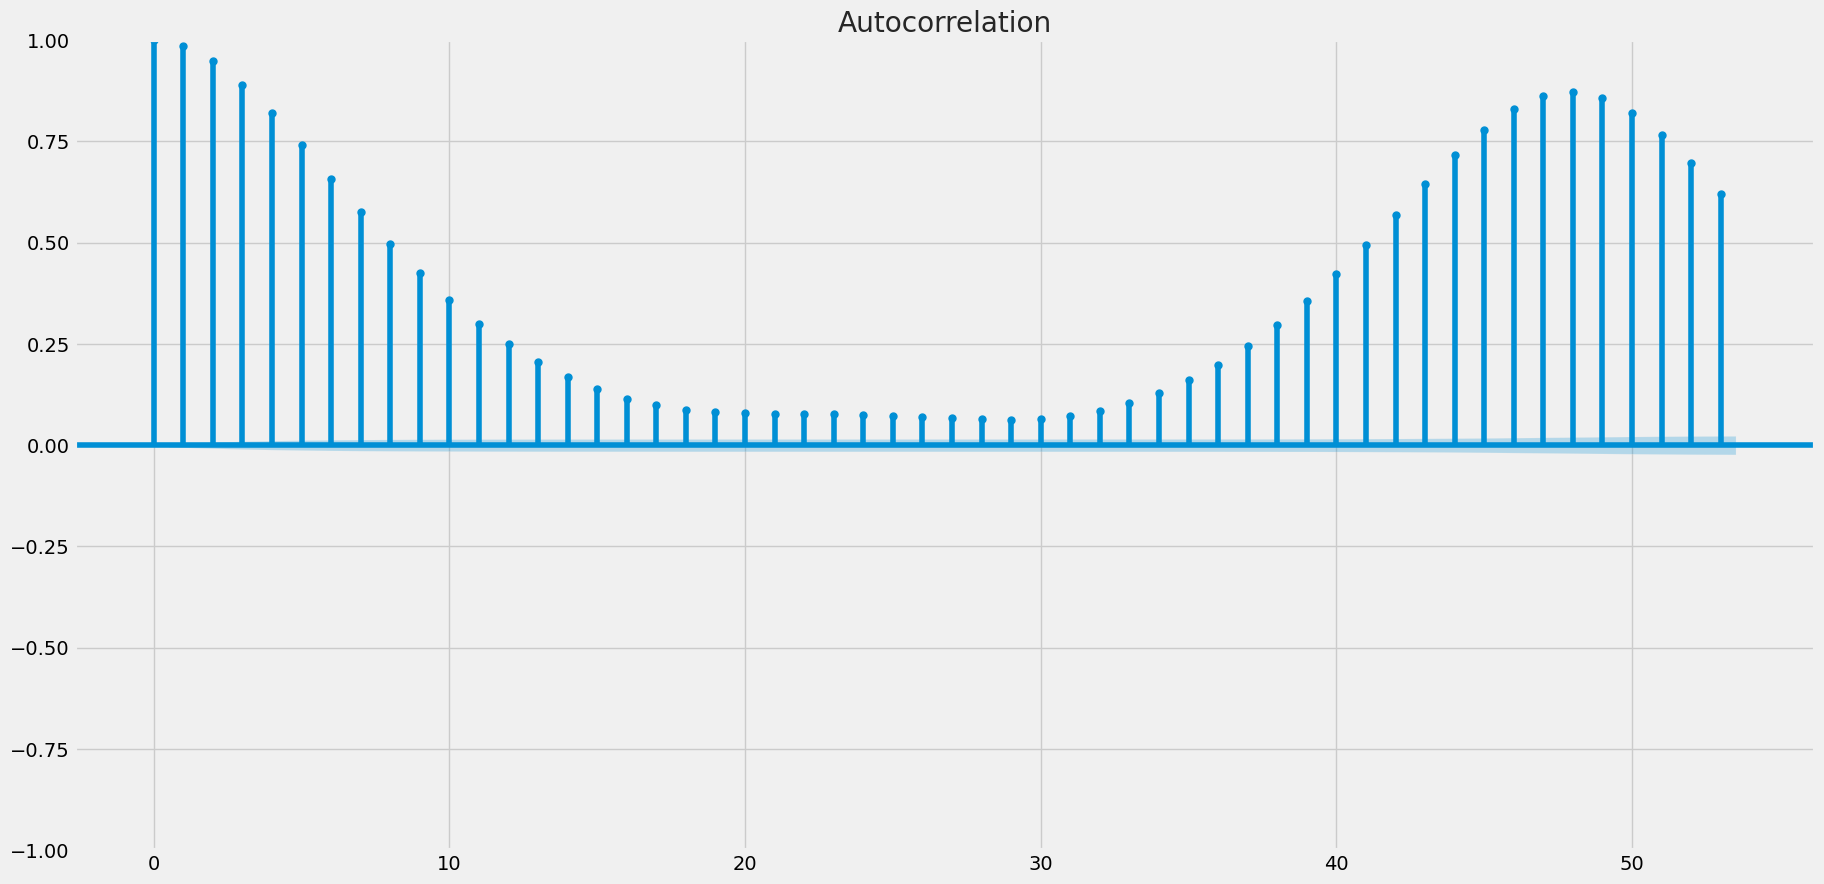

In [43]:
tsa.plot_acf(nsw_df['TOTALDEMAND'])
plt.show()

Here's what we can interpret from the ACF plot to inform the sequence length for an LSTM:
- **Significant Lags**: The plot shows peaks at regular intervals, which suggests seasonality in the data. These significant lags indicate that the data points are correlated with their past values at these intervals.
- **Seasonality Intervals**: The distances between the peaks can help identify the seasonality interval. In the context of sequence length for an LSTM, you might want to ensure that the sequence length covers at least one full seasonal cycle to capture the seasonality pattern.
- **Decay of Correlation**: The strength of the correlation generally seems to decay as the lag increases, but there is a repeating pattern of rising and falling, which is typical in time series with seasonal effects.
- **Cut-off Point**: There isn't a clear cut-off point where the correlation drops to near zero, which suggests the influence of past values might extend quite far back. This could imply that a longer sequence might be beneficial for the LSTM to learn from.
- **Practical Considerations**: While the ACF plot suggests that data is seasonally correlated over several lags, practical constraints such as the availability of data, computational power, and the risk of overfitting with very long sequences should also be considered.
- **Optimal Sequence Length**: The optimal sequence length would likely be a multiple of the seasonality interval identified from the plot, ensuring that at least one, or possibly multiple, full seasonal patterns are included within each sequence.

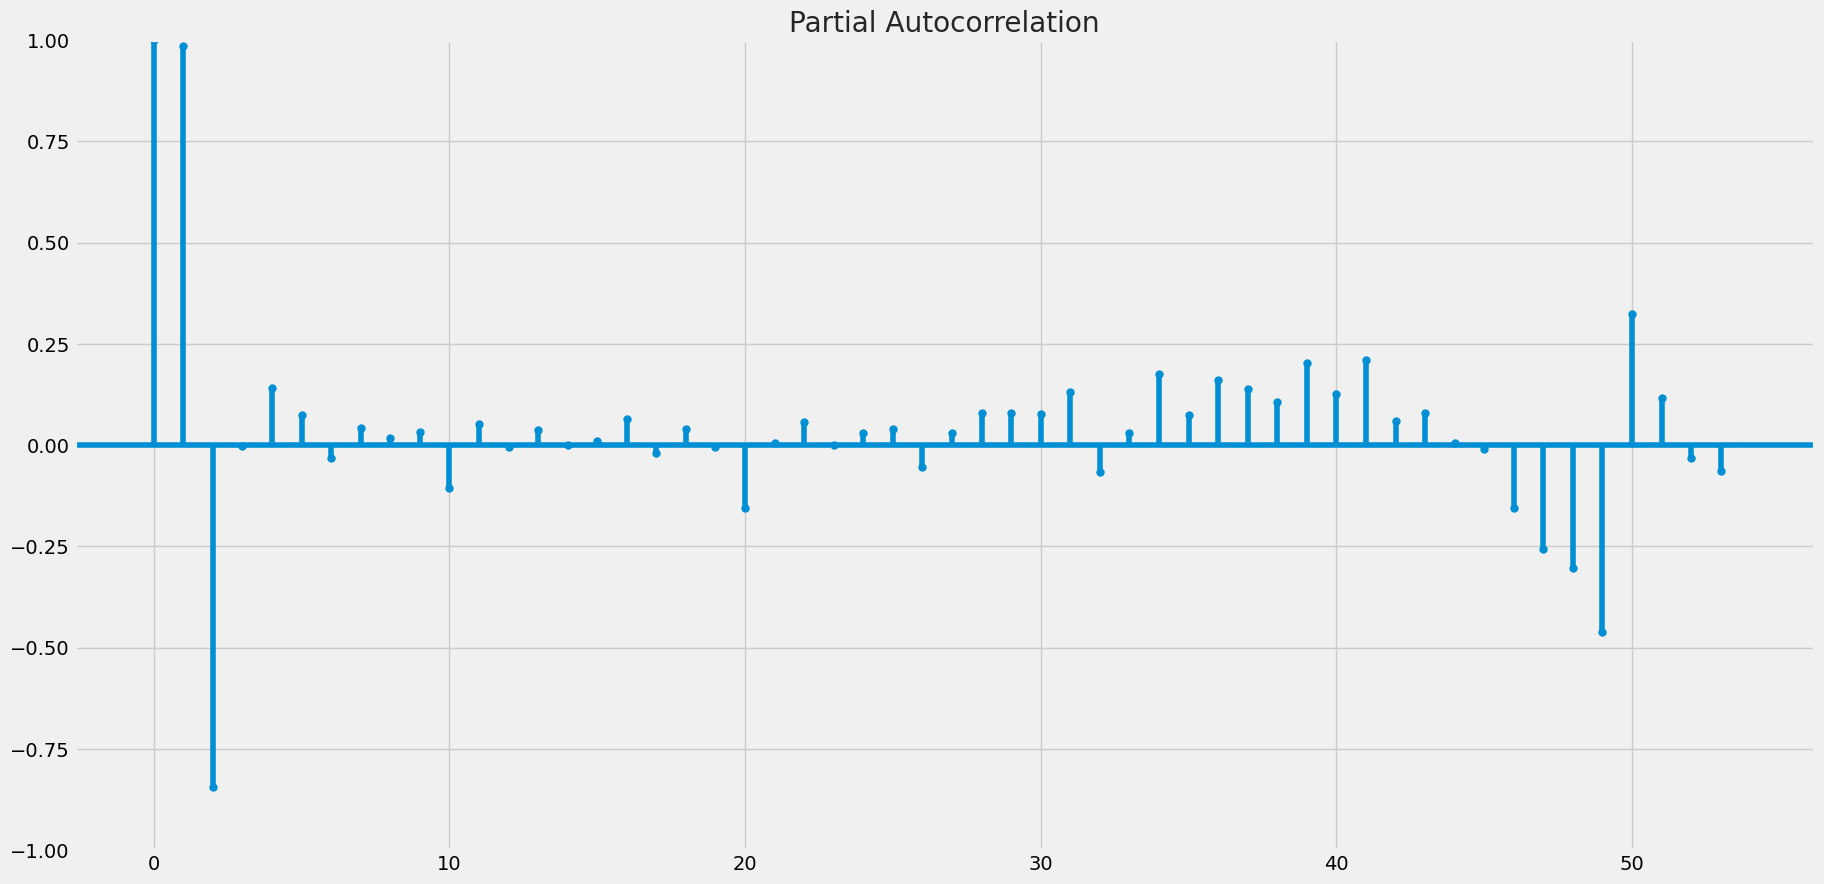

In [44]:
tsa.plot_pacf(nsw_df['TOTALDEMAND'])
plt.show()

# Observations
The Partial Autocorrelation Function (PACF) plot provides insight into the relationship between a time series and its lags after removing the effects of earlier lags. It's helpful for identifying the order of an autoregressive (AR) process.

From the PACF plot you've provided, we observe a few things:

- There is a significant spike at lag 1, which quickly diminishes after lag 2 and stays within what would typically be the confidence interval (not shown on this plot but usually at around +/- 0.2 for large datasets).
- Beyond the initial lags, most of the partial autocorrelations appear to be insignificant, as they are relatively small in magnitude and seem to be within the expected range of random fluctuation.
- The spikes that do occur at later lags appear somewhat sporadic and do not show a clear repeating pattern that would indicate seasonality.

This pattern suggests that the time series may be well modeled by an AR process of order 1 or possibly 2, since the partial autocorrelation is significant at lag 1 and possibly at lag 2. After these initial lags, the partial autocorrelations are not consistently significant, which indicates that incorporating additional lags into the model may not provide additional value.

In [45]:
nsw_df

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-01 00:30:00      7809.31     7680.510417        22.80  21.50   
2010-01-01 01:00:00      7483.69     7428.971370        22.60  20.98   
2010-01-01 01:30:00      7117.23     7084.802162        22.50  20.06   
2010-01-01 02:00:00      6812.03     6751.369600        22.50  17.93   
2010-01-01 02:30:00      6544.33     6484.270789        22.40  17.43   
...                          ...             ...          ...    ...   
2021-03-17 22:00:00      7419.77     7317.702687        19.70  32.00   
2021-03-17 22:30:00      7417.91     7266.887647        19.50  37.01   
2021-03-17 23:00:00      7287.32     7173.866522        19.05  34.49   
2021-03-17 23:30:00      7172.39     7043.236857        18.80  32.55   
2021-03-18 00:00:00      7094.51     6961.076901        18.60  32.63   

                     daily_avg_actual  daily_avg_forecast  forecast_error  \
2010-01-01 00:30:00               NaN                 NaN     -212.791200   
2010-01-01 01:00:00               NaN                 NaN     -212.791200   
2010-01-01 01:30:00               NaN                 NaN     -212.791200   
2010-01-01 02:00:00               NaN                 NaN     -212.791200   
2010-01-01 02:30:00               NaN                 NaN     -212.791200   
...                               ...                 ...             ...   
2021-03-17 22:00:00               NaN                 NaN     -133.433099   
2021-03-17 22:30:00               NaN                 NaN     -133.433099   
2021-03-17 23:00:00               NaN                 NaN     -133.433099   
2021-03-17 23:30:00               NaN                 NaN     -133.433099   
2021-03-18 00:00:00           7094.51         6961.076901     -133.433099   

                     smoothed_forecast_demand  year  quarter  month  dow  doy  \
2010-01-01 00:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:30:00               7699.974365  2010        1      1    4    1   
...                                       ...   ...      ...    ...  ...  ...   
2021-03-17 22:00:00               7400.366626  2021        1      3    2   76   
2021-03-17 22:30:00               7399.723912  2021        1      3    2   76   
2021-03-17 23:00:00               7399.132502  2021        1      3    2   76   
2021-03-17 23:30:00               7398.573481  2021        1      3    2   76   
2021-03-18 00:00:00               7398.131553  2021        1      3    3   77   

                     hour  season  smoothed_total_demand  \
2010-01-01 00:30:00     0       1                    NaN   
2010-01-01 01:00:00     1       1                    NaN   
2010-01-01 01:30:00     1       1                    NaN   
2010-01-01 02:00:00     2       1                    NaN   
2010-01-01 02:30:00     2       1                    NaN   
...                   ...     ...                    ...   
2021-03-17 22:00:00    22       2            7422.855208   
2021-03-17 22:30:00    22       2            7424.357917   
2021-03-17 23:00:00    23       2            7425.781458   
2021-03-17 23:30:00    23       2            7428.187917   
2021-03-18 00:00:00     0       2            7430.172917   

                     smoothed_temperature  minutes_past_midnight  
2010-01-01 00:30:00                   NaN                     30  
2010-01-01 01:00:00                   NaN                     60  
2010-01-01 01:30:00                   NaN                     90  
2010-01-01 02:00:00                   NaN                    120  
2010-01-01 02:30:00                   NaN                    150  
...                                   ...                    ...  
2021-03-17 22:00:00             19.705694                   1320  
2

In [46]:
nsw_df['TEMPERATURE'].isna().sum()

0

In [47]:
nsw_df.isna().sum()

TOTALDEMAND                      0
FORECASTDEMAND                   0
TEMPERATURE                      0
rrp                              0
daily_avg_actual            192418
daily_avg_forecast          192418
forecast_error                   0
smoothed_forecast_demand         0
year                             0
quarter                          0
month                            0
dow                              0
doy                              0
hour                             0
season                           0
smoothed_total_demand           47
smoothed_temperature            47
minutes_past_midnight            0
dtype: int64

In [48]:
nsw_df.columns

Index(['TOTALDEMAND', 'FORECASTDEMAND', 'TEMPERATURE', 'rrp',
       'daily_avg_actual', 'daily_avg_forecast', 'forecast_error',
       'smoothed_forecast_demand', 'year', 'quarter', 'month', 'dow', 'doy',
       'hour', 'season', 'smoothed_total_demand', 'smoothed_temperature',
       'minutes_past_midnight'],
      dtype='object')

In [49]:
nsw_df.dtypes

TOTALDEMAND                 float64
FORECASTDEMAND              float64
TEMPERATURE                 float64
rrp                         float64
daily_avg_actual            float64
daily_avg_forecast          float64
forecast_error              float64
smoothed_forecast_demand    float64
year                          int32
quarter                       int32
month                         int32
dow                           int32
doy                           int32
hour                          int32
season                        int64
smoothed_total_demand       float64
smoothed_temperature        float64
minutes_past_midnight         int32
dtype: object

In [50]:
nsw_df.isna().sum()

TOTALDEMAND                      0
FORECASTDEMAND                   0
TEMPERATURE                      0
rrp                              0
daily_avg_actual            192418
daily_avg_forecast          192418
forecast_error                   0
smoothed_forecast_demand         0
year                             0
quarter                          0
month                            0
dow                              0
doy                              0
hour                             0
season                           0
smoothed_total_demand           47
smoothed_temperature            47
minutes_past_midnight            0
dtype: int64

In [51]:
def Degree_Days2(df, HDD_ct=17, CDD_ct=19.5):
    Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
    DD = pd.DataFrame(index=df.index, columns=['HDD', 'CDD'])
    for i in range(0,Tbar.shape[0]):
        DD['HDD'].iloc[48*(i):48*(i+1)] = max(0, HDD_ct-Tbar.iloc[i])
        DD['CDD'].iloc[48*(i):48*(i+1)] = max(0, Tbar.iloc[i]-CDD_ct)
    return Tbar, DD

In [52]:
Degree_Days2(nsw_df['TEMPERATURE'])

/tmp/ipykernel_158103/1511996872.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_158103/1511996872.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_158103/1511996872.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

(2009-12-31 21:00:00    25.260976
 2010-01-01 21:00:00    25.053125
 2010-01-02 21:00:00    19.935590
 2010-01-03 21:00:00    20.605208
 2010-01-04 21:00:00    22.425000
                          ...    
 2021-03-13 21:00:00    19.361806
 2021-03-14 21:00:00    17.135417
 2021-03-15 21:00:00    17.468229
 2021-03-16 21:00:00    19.749444
 2021-03-17 21:00:00    19.164286
 Freq: 24h, Name: TEMPERATURE, Length: 4095, dtype: float64,
                     HDD       CDD
 2010-01-01 00:30:00   0  5.760976
 2010-01-01 01:00:00   0  5.760976
 2010-01-01 01:30:00   0  5.760976
 2010-01-01 02:00:00   0  5.760976
 2010-01-01 02:30:00   0  5.760976
 ...                  ..       ...
 2021-03-17 22:00:00   0  0.249444
 2021-03-17 22:30:00   0  0.249444
 2021-03-17 23:00:00   0  0.249444
 2021-03-17 23:30:00   0  0.249444
 2021-03-18 00:00:00   0  0.249444
 
 [196512 rows x 2 columns])

In [53]:
Tbar, DD = Degree_Days2(nsw_df['TEMPERATURE'])
# final_df['HDD'] = DD['HDD']
# final_df['CDD'] = DD['CDD']
# fix_me: this is a daily metric for now. repeat same value for each 30 min sample on that day
# fix_me: can we combine these so we don't have 0 values?

/tmp/ipykernel_158103/1511996872.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_158103/1511996872.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  Tbar = df.resample('24H', offset='21H').mean() # mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_158103/1511996872.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


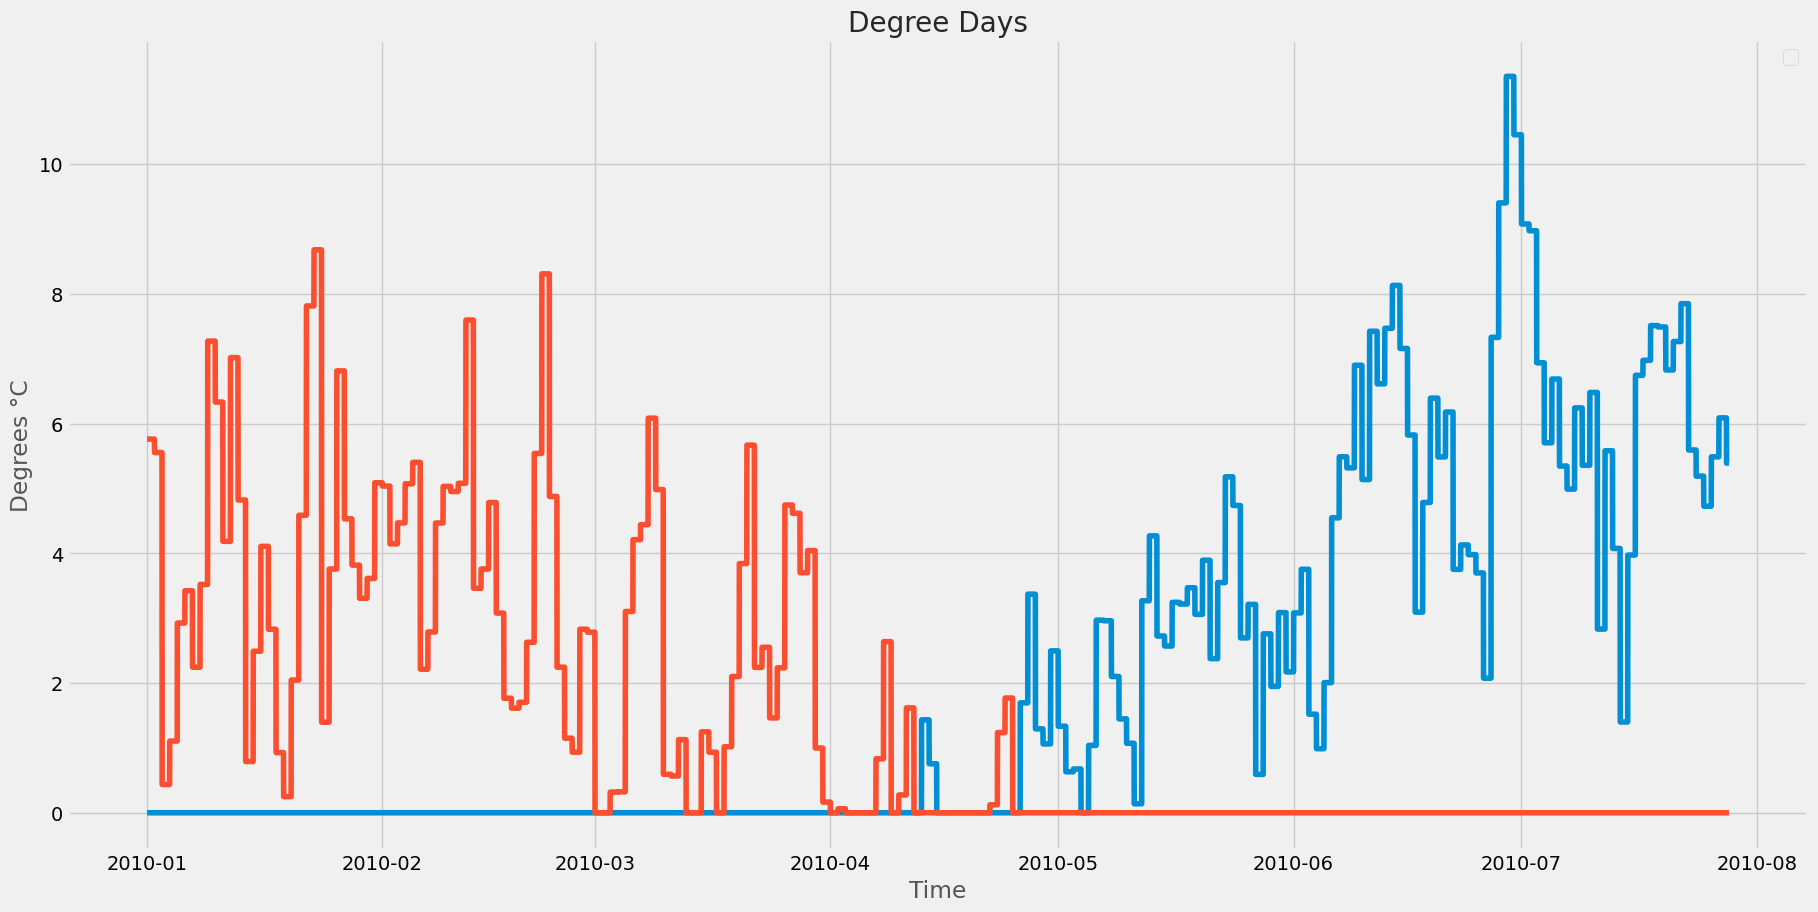

In [54]:
plt.plot(DD.iloc[1: 10000])
plt.title("Degree Days")
plt.xlabel("Time")
plt.ylabel("Degrees °C")
plt.legend()
plt.show()
# todo: fix warnings
# todo: these are the plotted CDD and HDD vars

In [55]:
temp_df = nsw_df[['TEMPERATURE', 'month', 'season']]

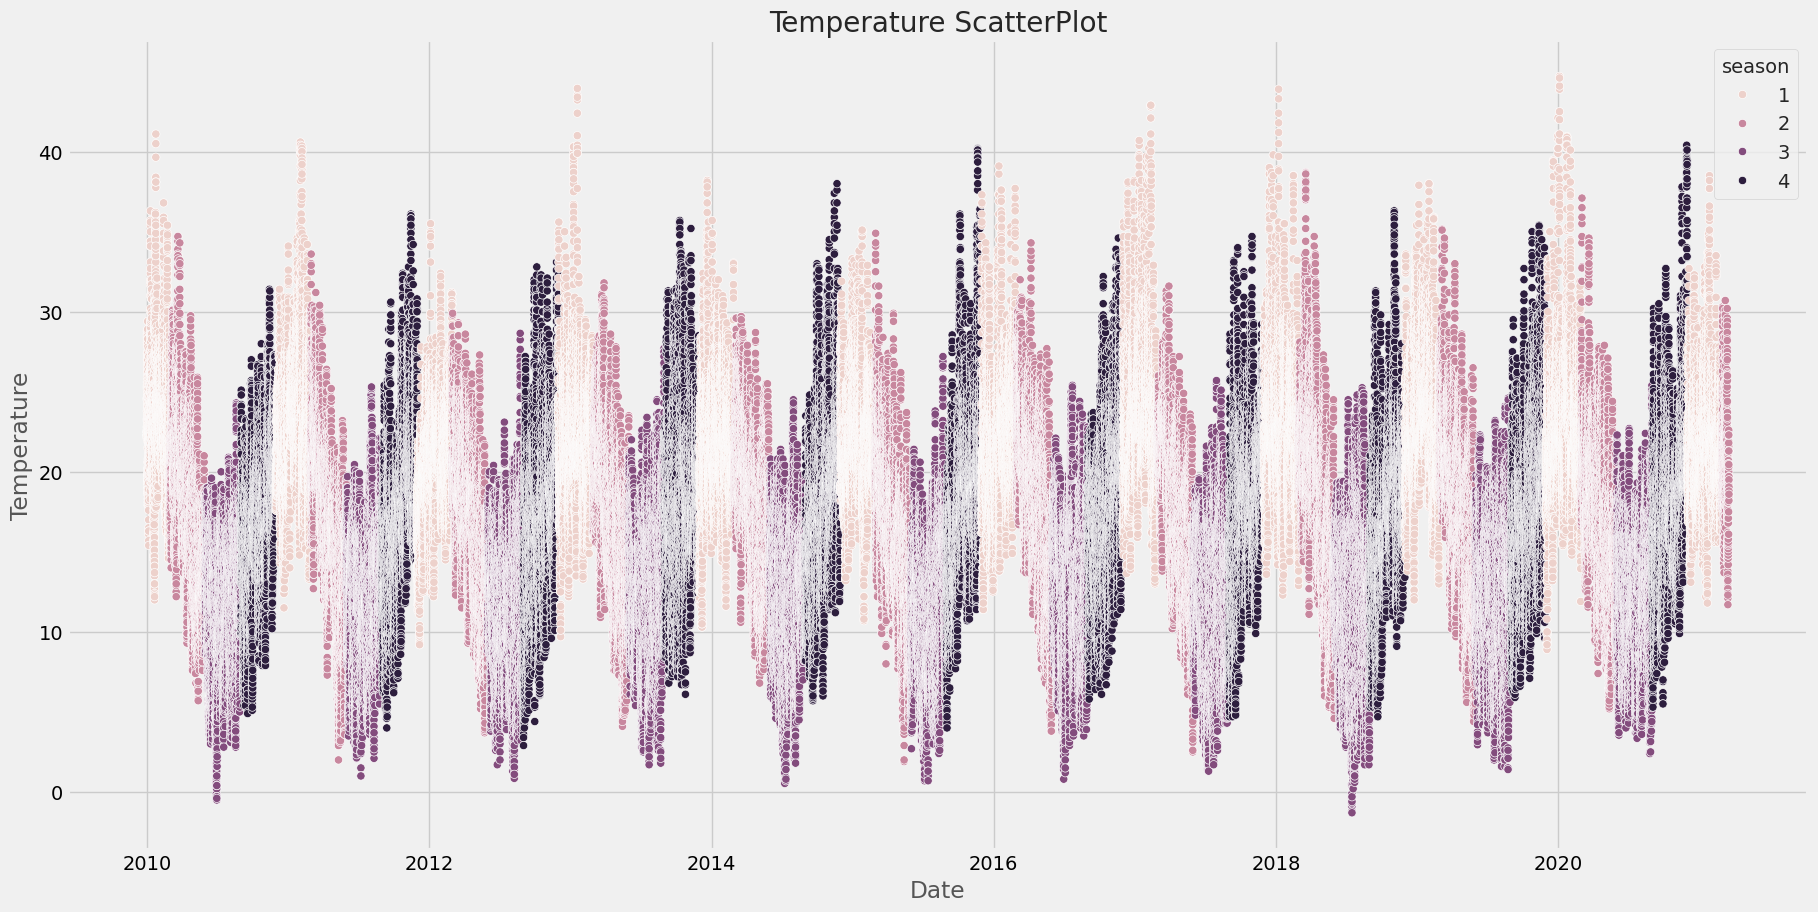

In [56]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(data=temp_df, x=temp_df.index, y='TEMPERATURE', hue='season')
plt.title('Temperature ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

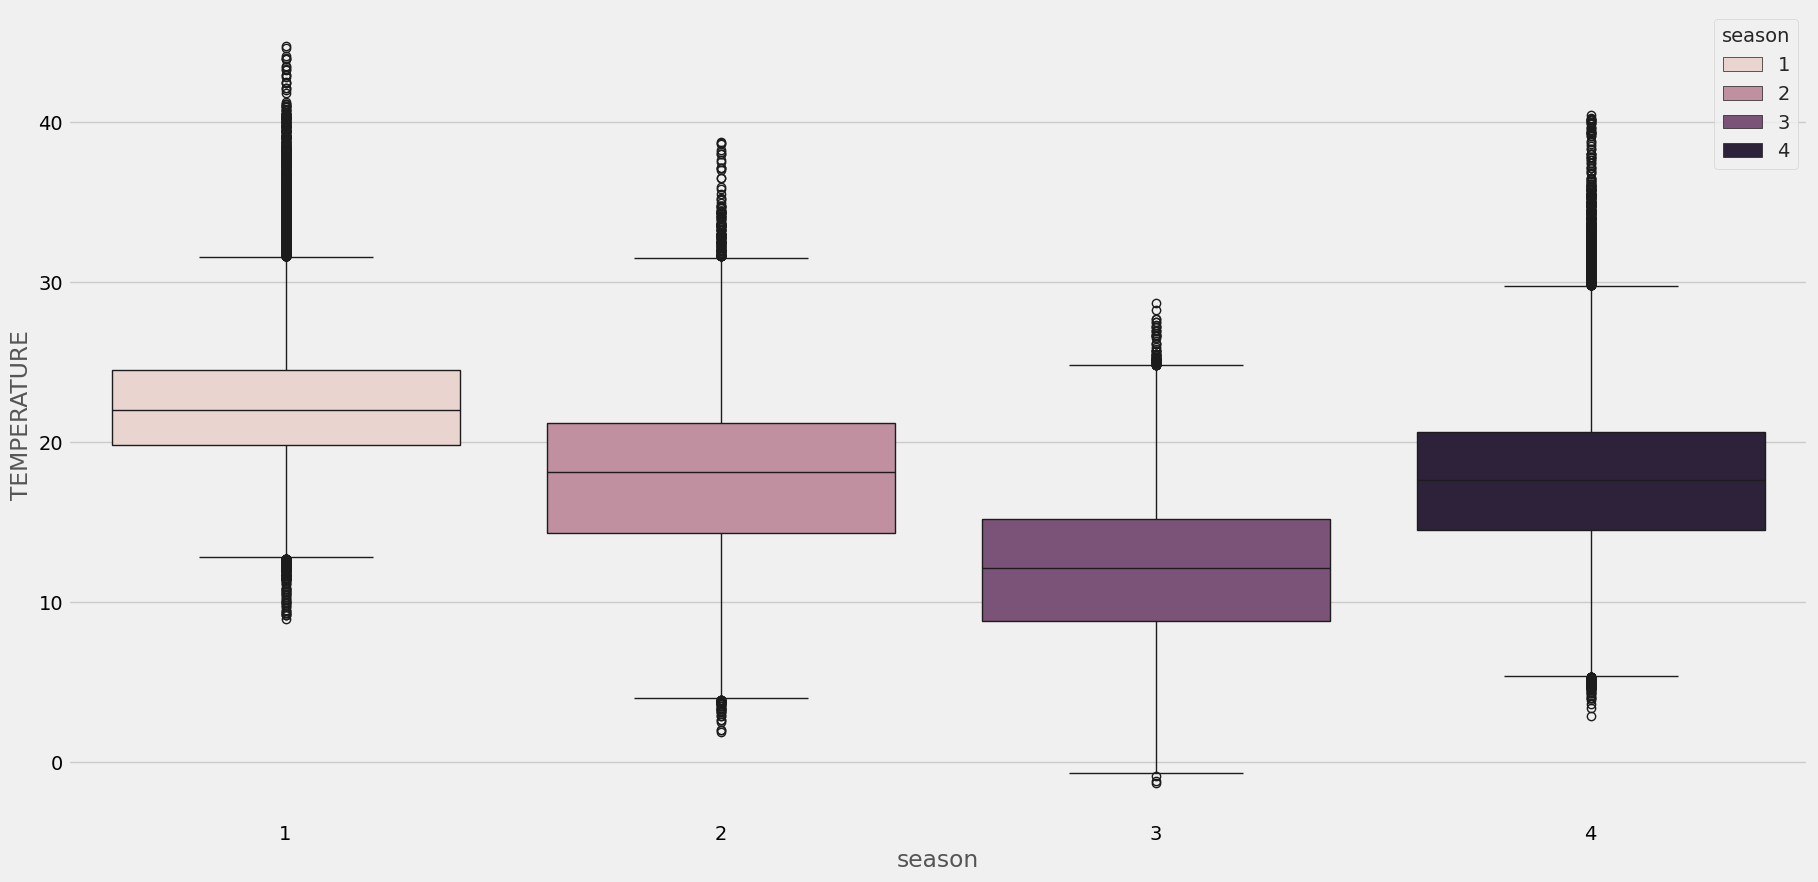

In [57]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.boxplot(data=temp_df, x='season', y='TEMPERATURE', hue='season')
plt.show()

In [58]:
temp_highest_allowed = round(temp_df['TEMPERATURE'].mean() + 3 * temp_df['TEMPERATURE'].std(), 2)
temp_lowest_allowed = round(temp_df['TEMPERATURE'].mean() - 3 * temp_df['TEMPERATURE'].std(), 2)
print('Highest Allowed:', temp_highest_allowed)
print('Lowest Allowed:', temp_lowest_allowed)

Highest Allowed: 35.16
Lowest Allowed: -0.1


In [59]:
temp_outliers = temp_df[(temp_df['TEMPERATURE'] > temp_highest_allowed) | (temp_df['TEMPERATURE'] < temp_lowest_allowed)]
print('Total Rows:', len(temp_outliers))

Total Rows: 551


In [60]:
# todo: create a separate temp column, check with if statement, cap values if outside threshold
# final_df.loc['2013-02-01']  # problem
# final_df.loc['2016-07-15']  # there is a problem from 16 - 18
# todo: somehow we need to check that that each day has 48 samples

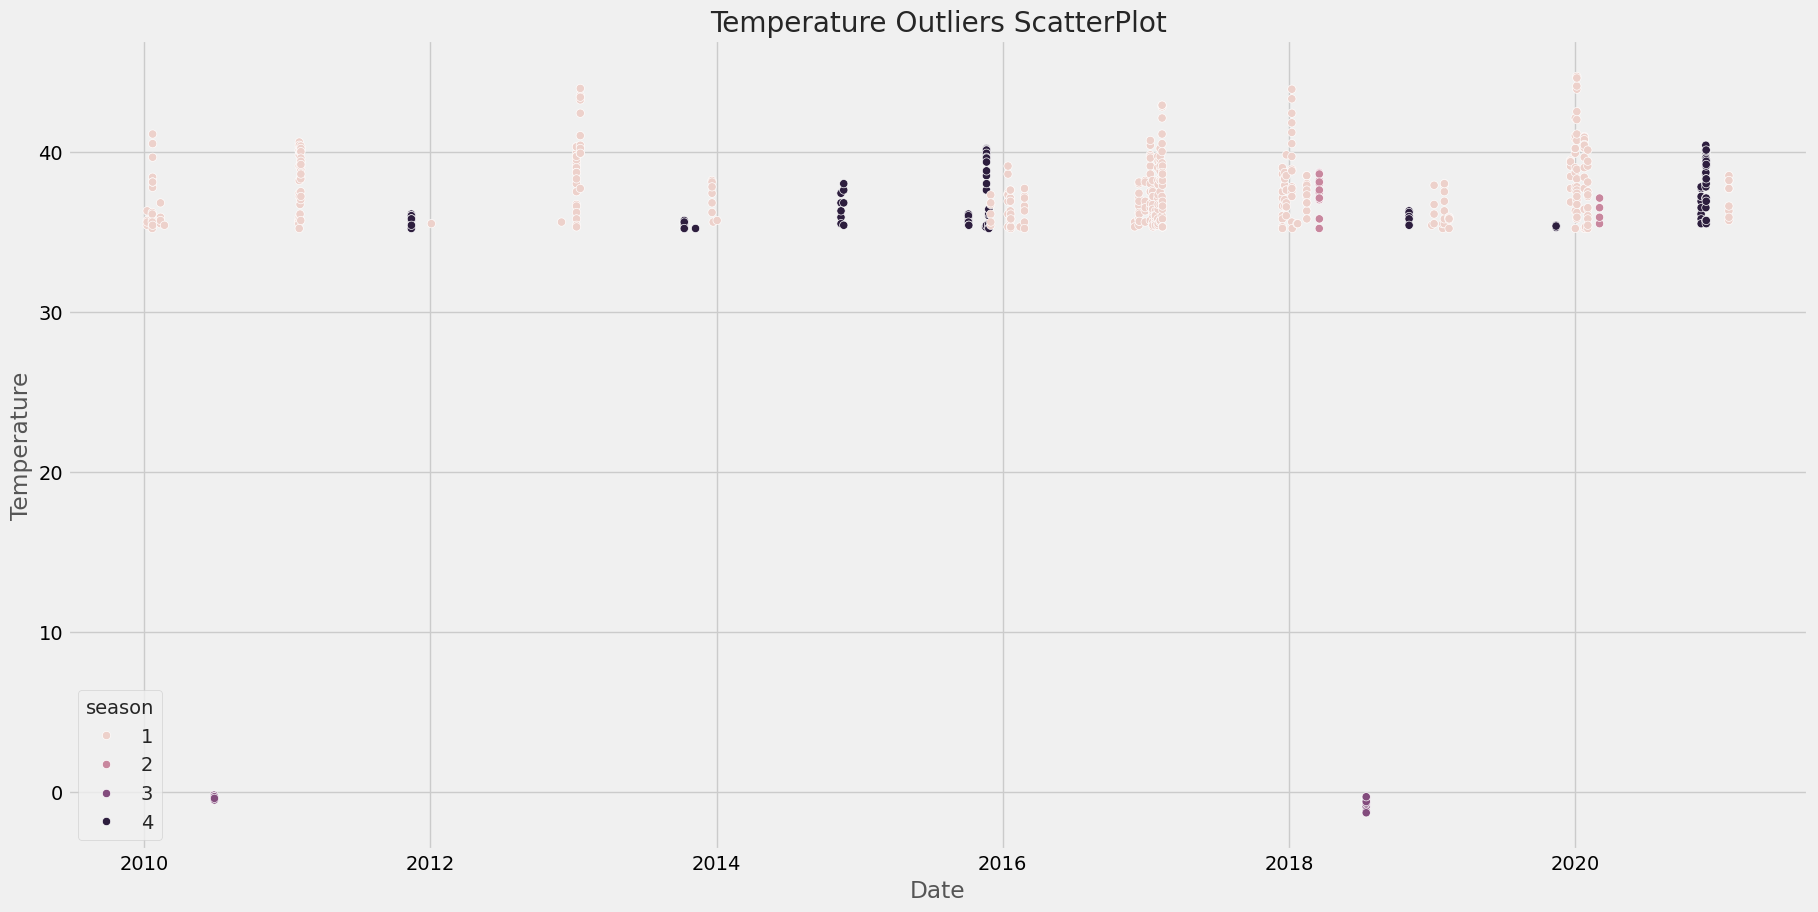

In [61]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(data=temp_outliers, x=temp_outliers.index, y='TEMPERATURE', hue='season')
plt.title('Temperature Outliers ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [62]:
high_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] > temp_highest_allowed]
t_high_df = high_outliers['month'].value_counts()
t_high_df = t_high_df.reset_index()
t_high_df.columns = ['Month', 'Count']
t_high_df_sorted = t_high_df.sort_values(by='Month', ascending=True)
print(t_high_df_sorted)

   Month  Count
0      1    205
1      2    125
4      3     19
5     10     14
2     11     94
3     12     79


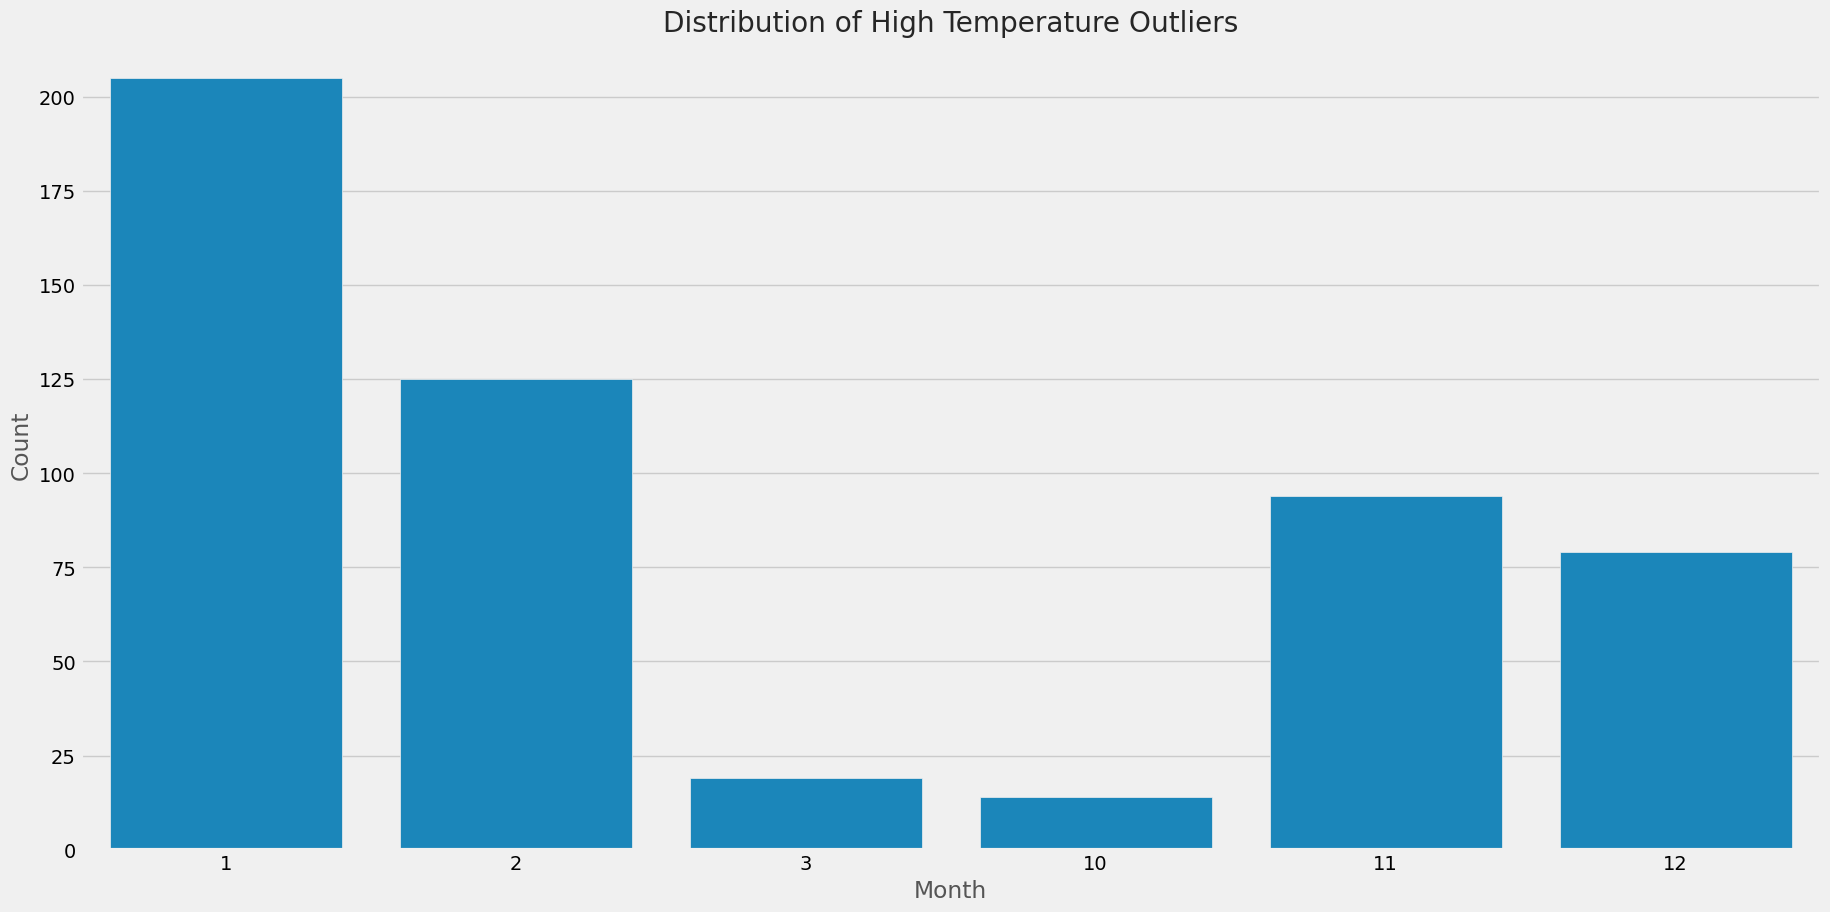

In [63]:
# histogram
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.barplot(data=t_high_df_sorted, x='Month', y='Count')
plt.title('Distribution of High Temperature Outliers')
plt.show()

In [64]:
low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE'] < temp_lowest_allowed]
t_low_df = low_outliers['month'].value_counts()
t_low_df = t_low_df.reset_index()
t_low_df.columns = ['Month','Count']
t_low_df_sorted = t_low_df.sort_values(by='Month', ascending=True)
print(t_low_df_sorted)

   Month  Count
1      6      5
0      7     10


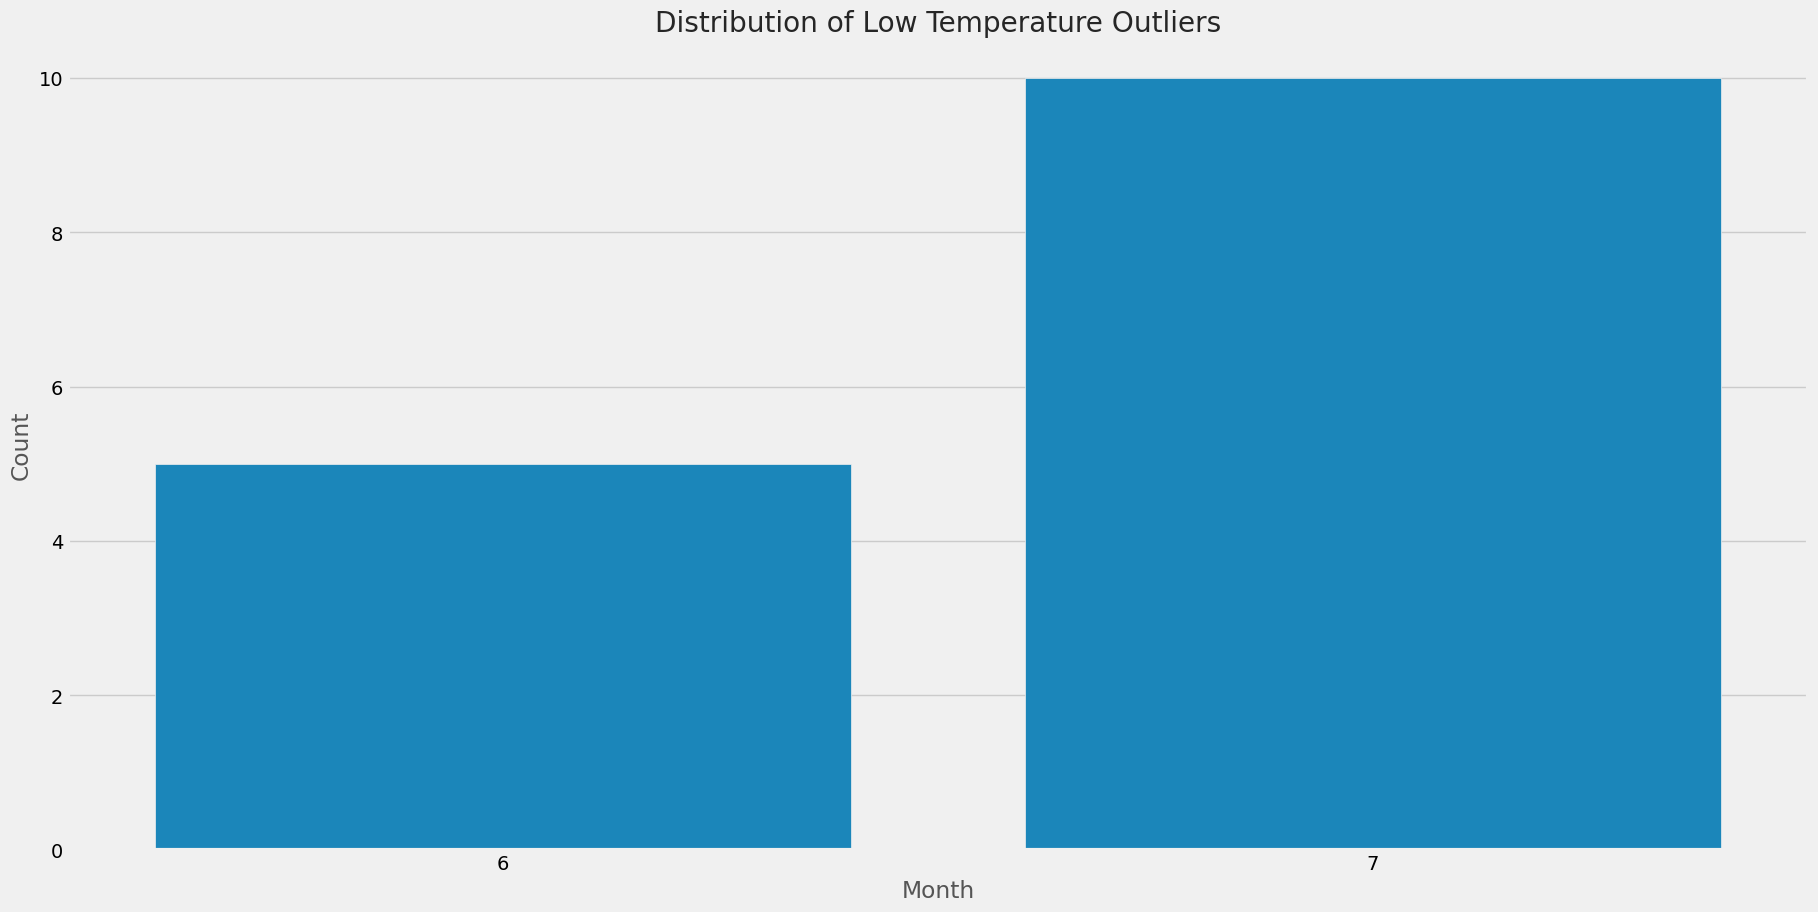

In [65]:
# Histogram
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.barplot(data=t_low_df, x='Month', y='Count')
plt.title('Distribution of Low Temperature Outliers')
plt.show()

In [66]:
price_outlier_df = nsw_df[['rrp', 'month', 'season']]

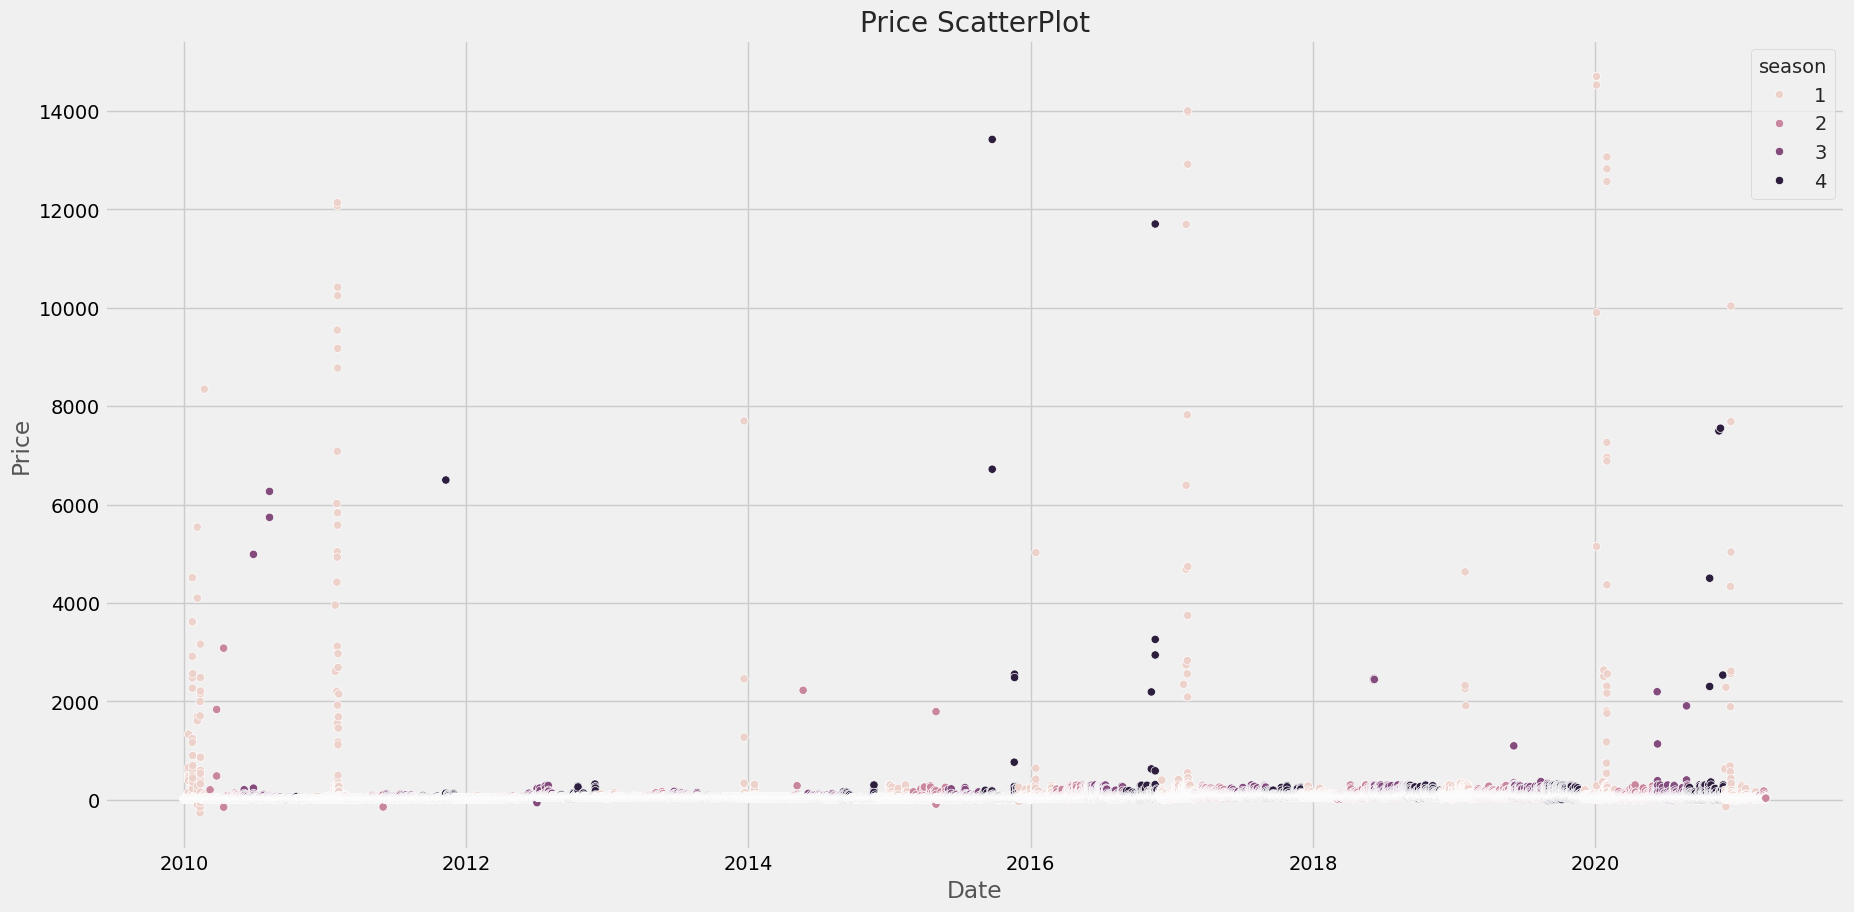

In [67]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(data=price_outlier_df, x=price_outlier_df.index, y='rrp', hue='season')
plt.title('Price ScatterPlot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [68]:
nsw_df.head()

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-01 00:30:00      7809.31     7680.510417         22.8  21.50   
2010-01-01 01:00:00      7483.69     7428.971370         22.6  20.98   
2010-01-01 01:30:00      7117.23     7084.802162         22.5  20.06   
2010-01-01 02:00:00      6812.03     6751.369600         22.5  17.93   
2010-01-01 02:30:00      6544.33     6484.270789         22.4  17.43   

                     daily_avg_actual  daily_avg_forecast  forecast_error  \
2010-01-01 00:30:00               NaN                 NaN       -212.7912   
2010-01-01 01:00:00               NaN                 NaN       -212.7912   
2010-01-01 01:30:00               NaN                 NaN       -212.7912   
2010-01-01 02:00:00               NaN                 NaN       -212.7912   
2010-01-01 02:30:00               NaN                 NaN       -212.7912   

                     smoothed_forecast_demand  year  quarter  month  dow  doy  \
2010-01-01 00:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 01:30:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:00:00               7699.974365  2010        1      1    4    1   
2010-01-01 02:30:00               7699.974365  2010        1      1    4    1   

                     hour  season  smoothed_total_demand  \
2010-01-01 00:30:00     0       1                    NaN   
2010-01-01 01:00:00     1       1                    NaN   
2010-01-01 01:30:00     1       1                    NaN   
2010-01-01 02:00:00     2       1                    NaN   
2010-01-01 02:30:00     2       1                    NaN   

                     smoothed_temperature  minutes_past_midnight  
2010-01-01 00:30:00                   NaN                     30  
2010-01-01 01:00:00                   NaN                     60  
2010-01-01 01:30:00                   NaN                     90  
2010-01-01 02:00:00                   NaN                    120  
2010-01-01 02:30:00                   NaN                    150

In [69]:
price_highest_allowed = round(price_outlier_df['rrp'].mean() + 3 * price_outlier_df['rrp'].std(), 2)
price_lowest_allowed = round(price_outlier_df['rrp'].mean() - 3 * price_outlier_df['rrp'].std(), 2)

In [70]:
price_outliers = price_outlier_df[(price_outlier_df['rrp']>price_highest_allowed) | (price_outlier_df['rrp']<price_lowest_allowed)]
print(len(price_outliers))

152


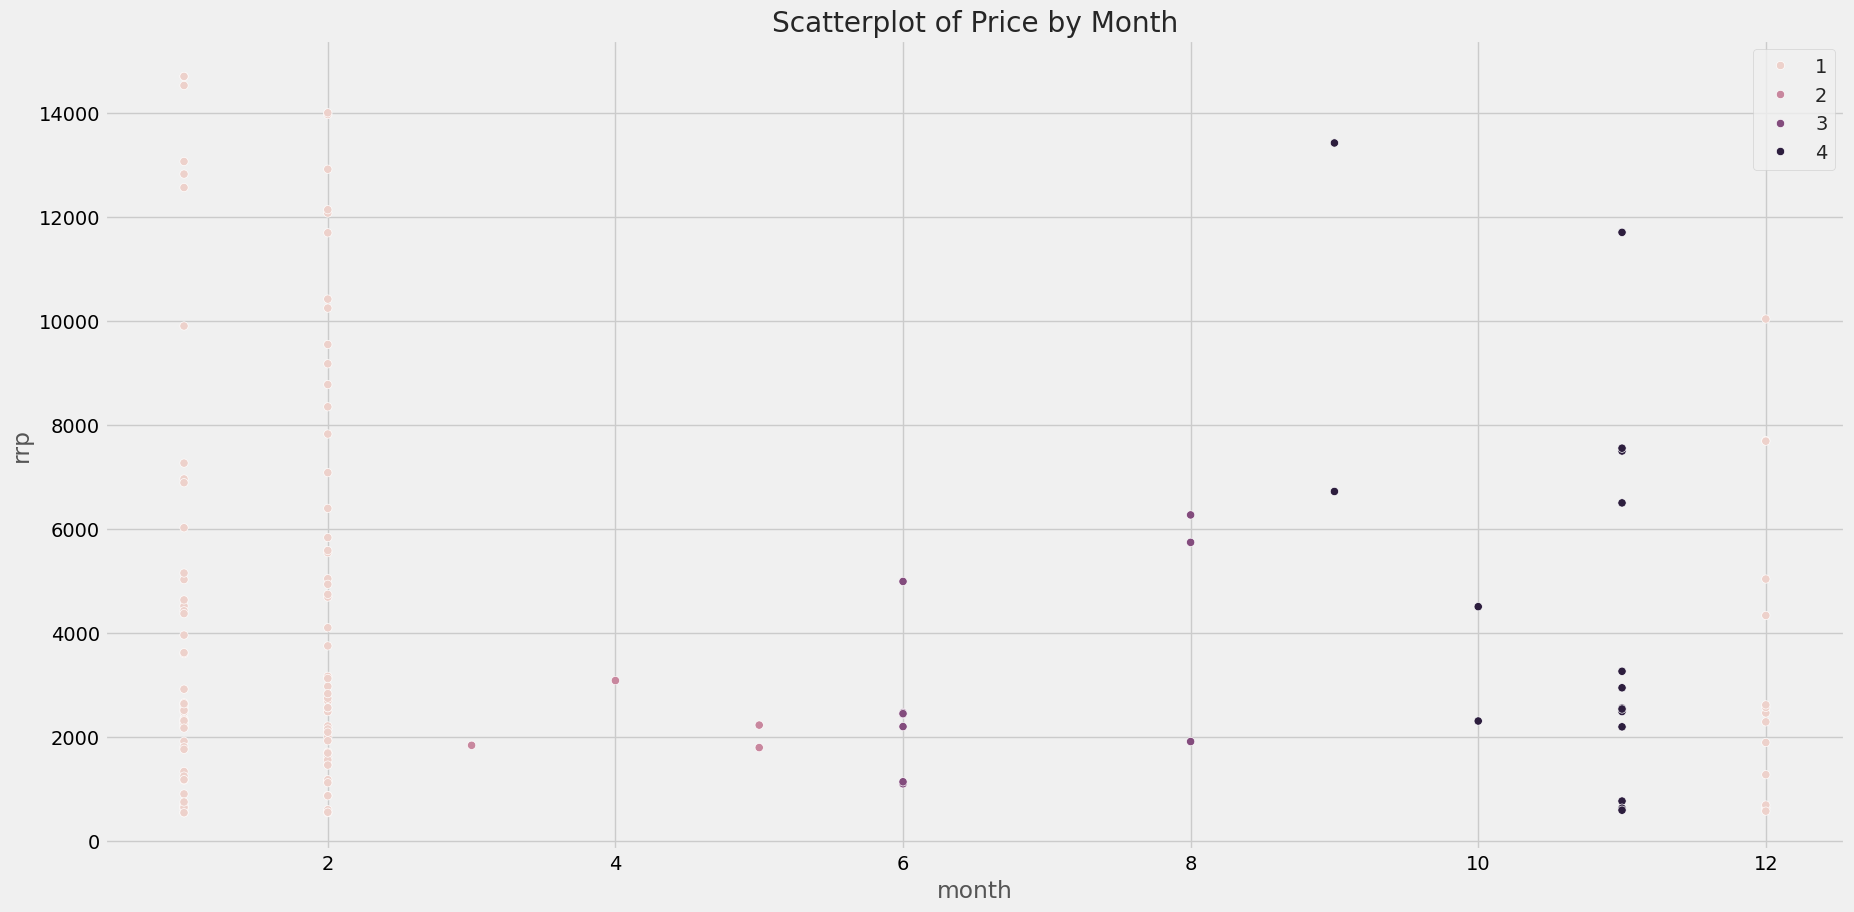

In [71]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=price_outliers,x='month', y='rrp', hue='season')
plt.title('Scatterplot of Price by Month')
plt.legend()
plt.show()

In [72]:
# low_outliers = temp_outliers.loc[temp_outliers['TEMPERATURE']<temp_lowest_allowed]
price_out_df = price_outliers['month'].value_counts()
price_out_df = price_out_df.reset_index()
price_out_df.columns = ['Month', 'Count']
price_out_df_sorted = price_out_df.sort_values(by='Month', ascending=True)
# print(price_out_df_sorted)

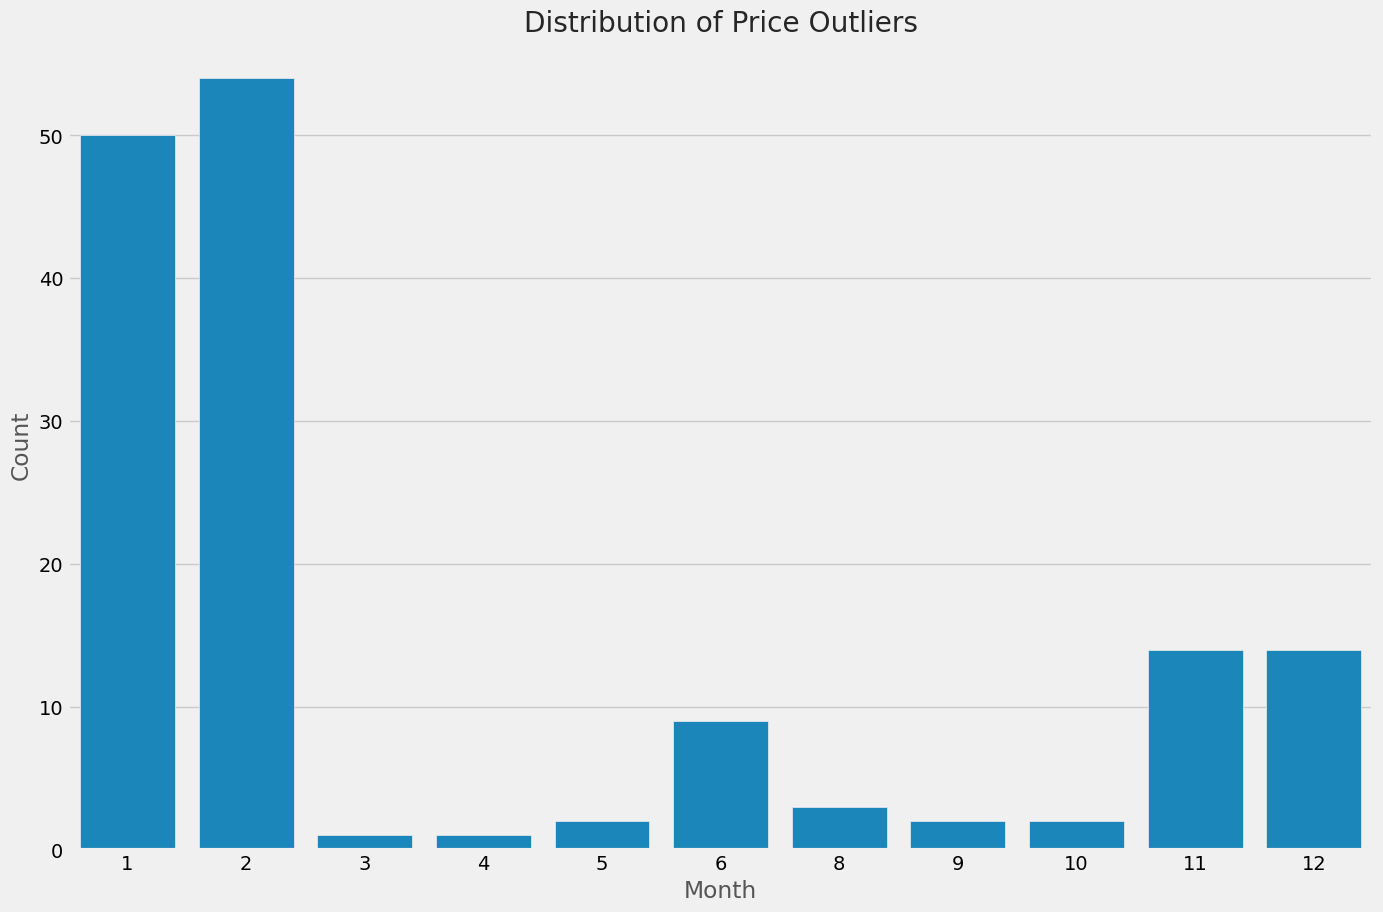

In [73]:
# Histogram
plt.figure(figsize=(15, 10))
sns.barplot(data=price_out_df_sorted, x='Month', y='Count')
plt.title('Distribution of Price Outliers')
plt.show()

In [74]:
total_demand_highest_allowed = round(nsw_df['TOTALDEMAND'].mean() + 3 * nsw_df['TOTALDEMAND'].std(), 2)
total_demand_lowest_allowed = round(nsw_df['TOTALDEMAND'].mean() - 3 * nsw_df['TOTALDEMAND'].std(), 2)
print(total_demand_highest_allowed)
print(total_demand_lowest_allowed)
# fix_me: we have misalignment between this and NS_test

12011.75
4214.54


In [75]:
total_demand_outliers = nsw_df[(nsw_df['TOTALDEMAND'] > total_demand_highest_allowed) | (nsw_df['TOTALDEMAND'] < total_demand_lowest_allowed)]
print(len(total_demand_outliers))

875


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


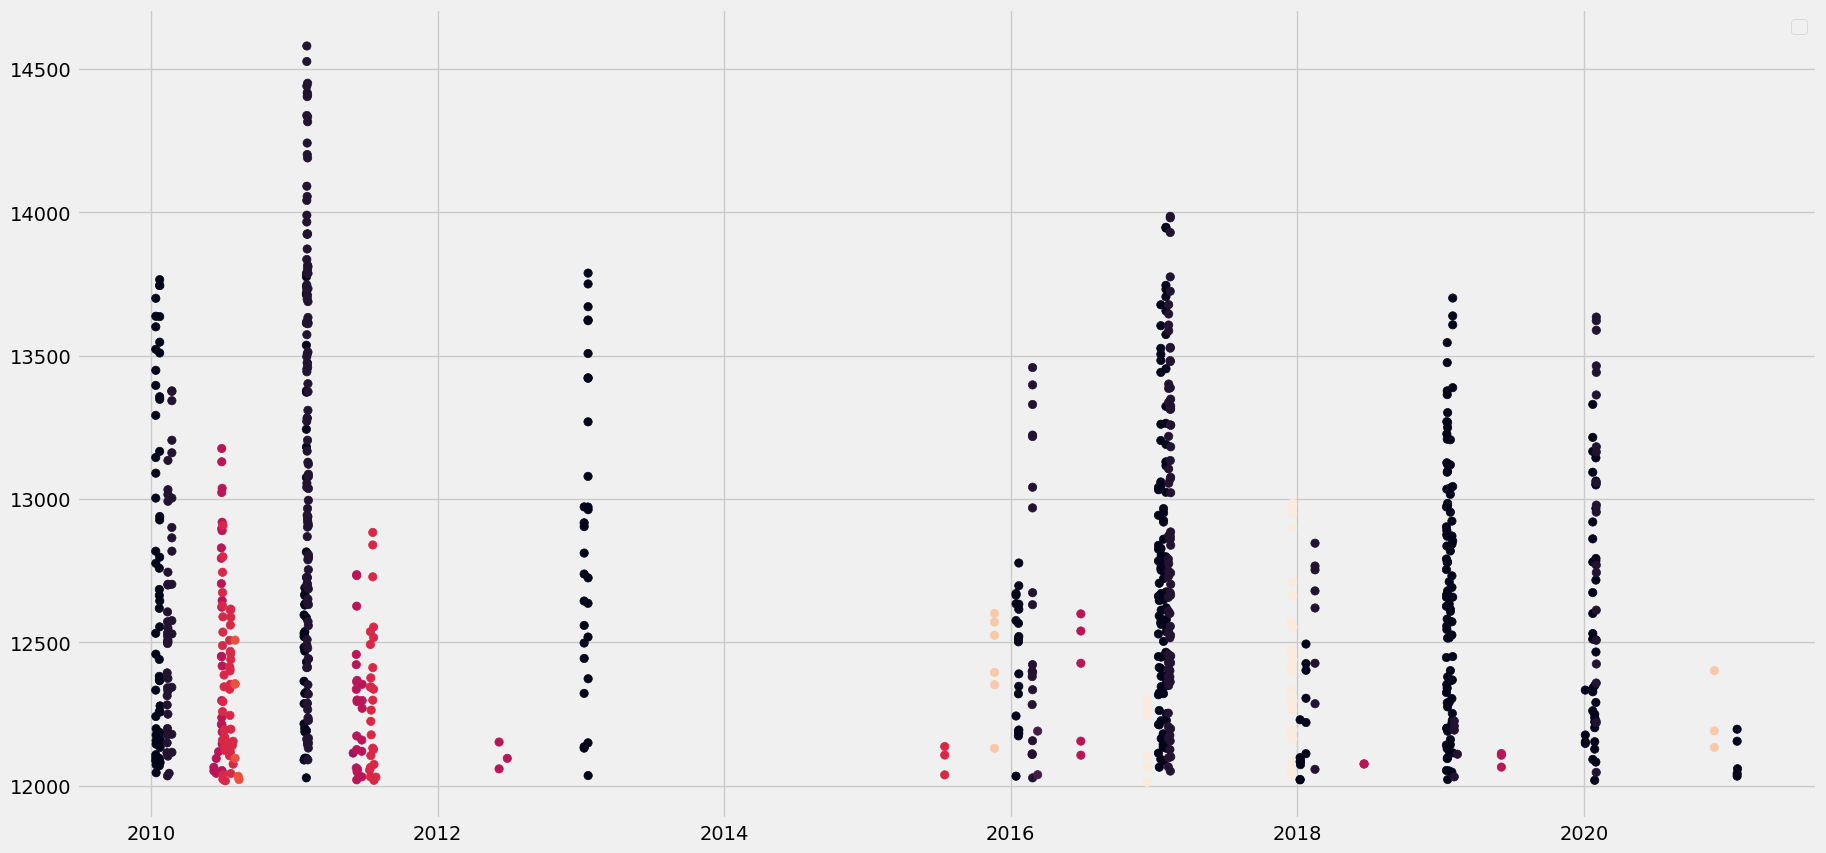

In [76]:
plt.figure(figsize=(20, 10))
plt.scatter(
    total_demand_outliers.index, 
    total_demand_outliers['TOTALDEMAND'], 
    c=total_demand_outliers['month']
)
plt.legend()
plt.show()

In [77]:
print(total_demand_outliers['month'].value_counts())

month
1     407
2     281
7      73
6      64
12     32
11      9
8       6
3       2
5       1
Name: count, dtype: int64


# Outlier handling Isolation Forest

In [78]:
handle_outliers = nsw_df[['TEMPERATURE', 'rrp', 'TOTALDEMAND', 'month', 'season']]
# fix_me: deal with Nans

In [79]:
nsw_df = nsw_df.iloc[48:]

In [80]:
nsw_df.head()

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE    rrp  \
2010-01-02 00:30:00      7343.30     7216.295694         24.3  20.67   
2010-01-02 01:00:00      7099.73     6977.373562         24.2  19.27   
2010-01-02 01:30:00      6779.80     6641.794324         24.2  17.92   
2010-01-02 02:00:00      6497.47     6339.068400         24.1  15.63   
2010-01-02 02:30:00      6347.69     6146.808421         23.9  14.32   

                     daily_avg_actual  daily_avg_forecast  forecast_error  \
2010-01-02 00:30:00               NaN                 NaN       91.620905   
2010-01-02 01:00:00               NaN                 NaN       91.620905   
2010-01-02 01:30:00               NaN                 NaN       91.620905   
2010-01-02 02:00:00               NaN                 NaN       91.620905   
2010-01-02 02:30:00               NaN                 NaN       91.620905   

                     smoothed_forecast_demand  year  quarter  month  dow  doy  \
2010-01-02 00:30:00               7699.974365  2010        1      1    5    2   
2010-01-02 01:00:00               7690.566078  2010        1      1    5    2   
2010-01-02 01:30:00               7681.336748  2010        1      1    5    2   
2010-01-02 02:00:00               7672.747139  2010        1      1    5    2   
2010-01-02 02:30:00               7665.716673  2010        1      1    5    2   

                     hour  season  smoothed_total_demand  \
2010-01-02 00:30:00     0       1            7781.995417   
2010-01-02 01:00:00     1       1            7773.996250   
2010-01-02 01:30:00     1       1            7766.966458   
2010-01-02 02:00:00     2       1            7760.413125   
2010-01-02 02:30:00     2       1            7756.316458   

                     smoothed_temperature  minutes_past_midnight  
2010-01-02 00:30:00             25.233333                     30  
2010-01-02 01:00:00             25.266667                     60  
2010-01-02 01:30:00             25.302083                     90  
2010-01-02 02:00:00             25.335417                    120  
2010-01-02 02:30:00             25.366667                    150

In [81]:
nsw_df.to_parquet(os.path.join(CFG.data_path, 'nsw_df_2.parquet'))

In [82]:
random_state = np.random.RandomState(42)

model = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=float(0.003)
)

model.fit(handle_outliers[['TEMPERATURE']])
print(model.get_params())
handle_outliers['Iso_forest_scores'] = model.decision_function(handle_outliers[['TEMPERATURE']])
handle_outliers['anomaly_score'] = model.predict(handle_outliers[['TEMPERATURE']])
handle_outliers[handle_outliers['anomaly_score'] == -1].head()
anomaly_df = handle_outliers[handle_outliers['anomaly_score'] == -1]
no_anomaly_df = handle_outliers[handle_outliers['anomaly_score'] == 1]

{'bootstrap': False, 'contamination': 0.003, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


/tmp/ipykernel_158103/4256642741.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle_outliers['Iso_forest_scores'] = model.decision_function(handle_outliers[['TEMPERATURE']])
/tmp/ipykernel_158103/4256642741.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle_outliers['anomaly_score'] = model.predict(handle_outliers[['TEMPERATURE']])


In [83]:
anomaly_df.columns

Index(['TEMPERATURE', 'rrp', 'TOTALDEMAND', 'month', 'season',
       'Iso_forest_scores', 'anomaly_score'],
      dtype='object')

In [84]:
anomaly_df

TEMPERATURE     rrp  TOTALDEMAND  month  season  \
2010-01-09 12:30:00         35.4   55.31     10675.20      1       1   
2010-01-09 13:00:00         36.3   54.09     10842.61      1       1   
2010-01-09 13:30:00         35.7   60.02     10953.88      1       1   
2010-01-09 14:00:00         35.6   58.62     11056.98      1       1   
2010-01-22 12:00:00         36.2  290.81     12797.49      1       1   
...                          ...     ...          ...    ...     ...   
2021-01-26 12:30:00         37.7   35.54      9871.84      1       1   
2021-01-26 13:00:00         38.2   36.75     10147.46      1       1   
2021-01-26 13:30:00         38.5   36.23     10414.34      1       1   
2021-01-26 14:00:00         38.2   37.57     10660.18      1       1   
2021-01-26 14:30:00         35.9   39.55     10965.30      1       1   

                     Iso_forest_scores  anomaly_score  
2010-01-09 12:30:00          -0.001002             -1  
2010-01-09 13:00:00          -0.012113             -1  
2010-01-09 13:30:00          -0.006032             -1  
2010-01-09 14:00:00          -0.006032             -1  
2010-01-22 12:00:00          -0.010080             -1  
...                                ...            ...  
2021-01-26 12:30:00          -0.019784             -1  
2021-01-26 13:00:00          -0.021327             -1  
2021-01-26 13:30:00          -0.022874             -1  
2021-01-26 14:00:00          -0.021327             -1  
2021-01-26 14:30:00          -0.008053             -1  

[587 rows x 7 columns]

In [85]:
print('Total Anomalies:', len(anomaly_df))
print('Total non-Anomaly:', len(no_anomaly_df))
# fix_me: we have an inconsistency here

Total Anomalies: 587
Total non-Anomaly: 195925


In [86]:
lag_test = nsw_df['TEMPERATURE'].shift(2)
lag_test

2010-01-02 00:30:00      NaN
2010-01-02 01:00:00      NaN
2010-01-02 01:30:00    24.30
2010-01-02 02:00:00    24.20
2010-01-02 02:30:00    24.20
                       ...  
2021-03-17 22:00:00    18.80
2021-03-17 22:30:00    19.70
2021-03-17 23:00:00    19.70
2021-03-17 23:30:00    19.50
2021-03-18 00:00:00    19.05
Name: TEMPERATURE, Length: 196464, dtype: float64

In [87]:
varShifted = nsw_df['TEMPERATURE'].shift(2)
varShifted = varShifted.interpolate(
    method='linear', 
    limit_direction='both', 
    axis=0
)
varShifted

2010-01-02 00:30:00    24.30
2010-01-02 01:00:00    24.30
2010-01-02 01:30:00    24.30
2010-01-02 02:00:00    24.20
2010-01-02 02:30:00    24.20
                       ...  
2021-03-17 22:00:00    18.80
2021-03-17 22:30:00    19.70
2021-03-17 23:00:00    19.70
2021-03-17 23:30:00    19.50
2021-03-18 00:00:00    19.05
Name: TEMPERATURE, Length: 196464, dtype: float64

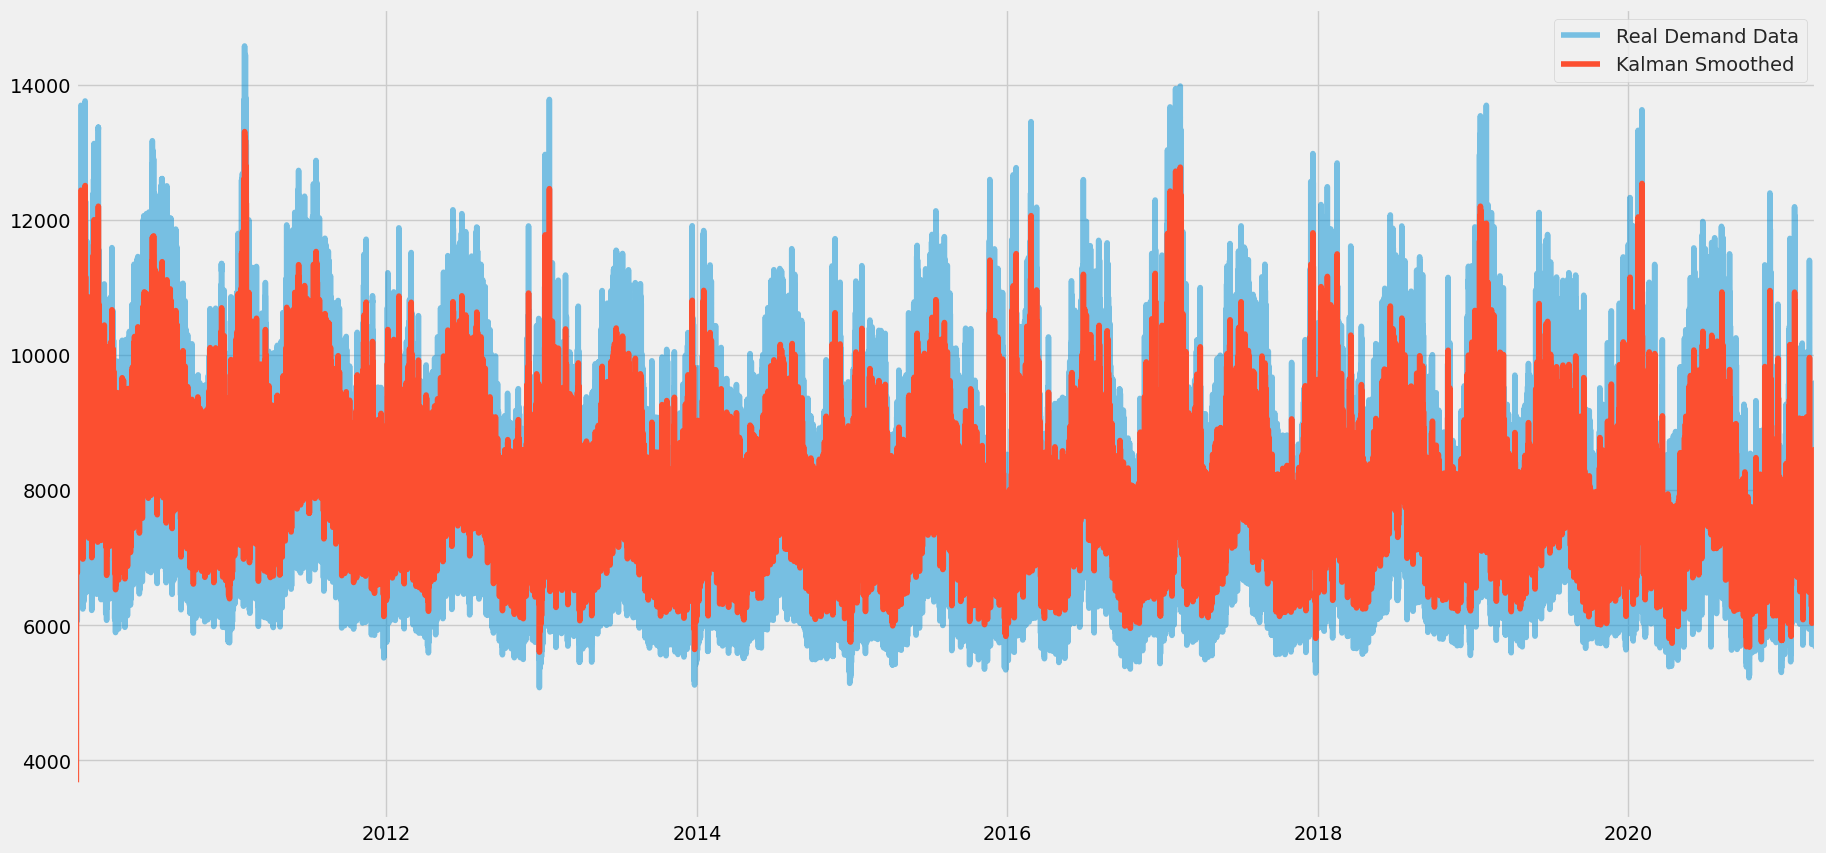

In [88]:
from utils import KalmanFilterAverage, KalmanFilterRegression, half_life
# state_means, _ = KalmanFilterRegression(self.KalmanFilterAverage(x),
#                                     self.KalmanFilterAverage(y), delta=1e-7)
from pykalman import KalmanFilter
test = nsw_df['TOTALDEMAND']

# Smoothing the input data helps to reduce the impact of random noise in the 
# data and produce a more stable estimate of the underlying trend, 
# which can lead to more accurate and reliable estimates of the system's state.

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01
    )
# use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(test.values)
state_means = pd.Series(state_means.flatten(), index=test.index)

nsw_df['TOTALDEMAND'].plot(alpha=0.5, label='Real Demand Data')
state_means.plot(label='Kalman Smoothed')
plt.legend()

# Rolling & lagged statistics

# Feature Engineering - Date-Time Features

In [89]:
demand = nsw_df[['TOTALDEMAND']].copy()
demand.loc[:, 'dow'] = demand.index.dayofweek
demand.loc[:, 'doy'] = demand.index.dayofyear
demand.loc[:, 'year'] = demand.index.year
demand.loc[:, 'month'] = demand.index.month
demand.loc[:, 'quarter'] = demand.index.quarter
demand.loc[:, 'hour'] = demand.index.hour
# todo: half hour
# demand.loc[:, 'weekday'] = demand.index.weekday_names  ## errors
# demand.loc[:, 'woy'] = demand.index.weekofyear  ## errors
demand.loc[:, 'dom'] = demand.index.day